In [1]:
!python --version

Python 3.10.4


In [ ]:
!pip show torch

In [ ]:
!ls -lh data/Mar09_01:31:43PM_24839/movie_coref.pt

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Run Coreference Model

In [2]:
from movie_coref.preprocess import preprocess_scripts as preprocess 
from movie_coref.movie_coref import MovieCoreference

# SCRIPT_FILE and PARSE_FILE are the filepaths to the script and parse file
# you can preprocess more than one movie by providing multiple script and parse files
# movie_data will be a list of processed movie scripts
SCRIPT_FILE = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_raw_norm.txt'
PARSE_FILE = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_tags_norm.txt'
COMBINED_FILE = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_combined_norm.txt'

movie_data = preprocess([SCRIPT_FILE], [PARSE_FILE])

# Instantiate the coreference model and pass the preprocessed data
movie_coref = MovieCoreference(
    preprocessed_data=movie_data,
    weights_file='data/Mar09_01:31:43PM_24839/movie_coref.pt',
    hierarchical=False,  # or False for fusion mode
    document_len=5120,
    overlap_len=2048,
    n_representative_mentions=3
)

# Perform the inference
# movie_data will contain the predicted clusters
movie_data = movie_coref.predict()

100%|██████████| 1/1 [00:05<00:00,  5.70s/script]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
coref prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Subdocument: 829482_raw_norm.txt_5113
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5099
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5118
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5104
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5112
Subdocument: 829482_raw_norm.txt_3013


coref prediction: 100%|██████████| 1/1 [02:15<00:00, 135.07s/it]


In [6]:
from movie_coref.preprocess import preprocess_scripts as preprocess 
from movie_coref.movie_coref import MovieCoreference

# SCRIPT_FILE and PARSE_FILE are the filepaths to the script and parse file
# you can preprocess more than one movie by providing multiple script and parse files
# movie_data will be a list of processed movie scripts
SCRIPT_FILE1 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_raw_norm.txt'
PARSE_FILE1 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_tags_norm.txt'
COMBINED_FILE1 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_combined_norm.txt'

SCRIPT_FILE2 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1219289/1219289_raw_norm.txt'
PARSE_FILE2 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1219289/1219289_tags_norm.txt'
COMBINED_FILE2 = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1219289/1219289_combined_norm.txt'

movie_data = preprocess([SCRIPT_FILE1,SCRIPT_FILE2], [PARSE_FILE1,PARSE_FILE2])

# Instantiate the coreference model and pass the preprocessed data
movie_coref = MovieCoreference(
    preprocessed_data=movie_data,
    weights_file='data/Mar09_01:31:43PM_24839/movie_coref.pt',
    hierarchical=True,  # or False for fusion mode
    document_len=5120,
    overlap_len=2048,
    n_representative_mentions=3
)

# Perform the inference
# movie_data will contain the predicted clusters
movie_data = movie_coref.predict()

coref prediction: 100%|██████████| 2/2 [03:23<00:00, 101.73s/it]


In [20]:
import os
import json
from multiprocessing import Pool
from movie_coref.preprocess import preprocess_scripts as preprocess
from movie_coref.movie_coref import MovieCoreference

def process_single_script(script_file, parse_file, weights_file, hierarchical, document_len, overlap_len):
    """
    Processes a single script and parse file, performs coreference prediction, and saves the result.

    Args:
        script_file: Path to the raw script file.
        parse_file: Path to the parse file.
        weights_file: Path to the coreference model weights.
        hierarchical: Boolean for hierarchical or fusion-based mode.
        document_len: Length of the document.
        overlap_len: Overlap length for splitting.

    Returns:
        Path to the saved JSON file for the processed movie data.
    """
    movie_dir = os.path.dirname(script_file)  # Determine the movie folder
    movie_id = os.path.basename(movie_dir)  # Extract the movie ID from the folder name
    output_file = os.path.join(movie_dir, f"{movie_id}_movie_data.json")  # Output JSON file path

    if os.path.exists(output_file):
        print(f"Skipping {script_file}: already processed.")
        return output_file

    try:
        # Preprocess the script
        movie_data = preprocess([script_file], [parse_file])

        # Instantiate and run the coreference model
        movie_coref = MovieCoreference(
            preprocessed_data=movie_data,
            weights_file=weights_file,
            hierarchical=hierarchical,
            document_len=document_len,
            overlap_len=overlap_len,
            n_representative_mentions=3
        )
        movie_data = movie_coref.predict()

        # Save the result to the movie folder
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(movie_data, f, ensure_ascii=False, indent=4)
        print(f"Processed and saved: {script_file}")
        return output_file
    except Exception as e:
        print(f"Error processing {script_file}: {e}")
        return None

In [261]:
# script_files, tags_files, _ = find_norm_files()  # Assuming this function provides the necessary file paths
script_files, tags_files = SCRIPT_FILE1, PARSE_FILE1
weights_file = "data/Mar09_01:31:43PM_24839/movie_coref.pt"
hierarchical = False
document_len = 5120
overlap_len = 2048

processed_files = process_single_script(script_files, tags_files, weights_file, hierarchical, document_len, overlap_len)
print(f"Processed {len(processed_files)} scripts successfully.")

100%|██████████| 1/1 [00:05<00:00,  5.26s/script]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
coref prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Subdocument: 829482_raw_norm.txt_5113
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5099
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5118
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5104
Subdocument: 829482_raw_norm.txt_5120
Subdocument: 829482_raw_norm.txt_5112
Subdocument: 829482_raw_norm.txt_3013


coref prediction: 100%|██████████| 1/1 [02:19<00:00, 139.18s/it]

Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_raw_norm.txt
Processed 107 scripts successfully.


In [257]:
processed_files

'/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/movie_data.json'

In [2]:
import os

def find_norm_files(pct=None):
    """
    Find all script, tags, and combined `_norm.txt` files within the directory structure.
    Optionally return a percentage of the files.

    Args:
        pct (float): A float between 0 and 1 specifying the percentage of files to return.
                     If None, return all files.

    Returns:
        script_files: List of paths to `_raw_norm.txt` files.
        tags_files: List of paths to `_tags_norm.txt` files.
        combined_files: List of paths to `_combined_norm.txt` files.
    """
    scripts_dir = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts'
    script_files = []
    tags_files = []
    combined_files = []

    for imdb_id_folder in os.listdir(scripts_dir):
        movie_dir = os.path.join(scripts_dir, imdb_id_folder)
        if os.path.isdir(movie_dir):
            # Construct paths for each type of file
            raw_script_path = os.path.join(movie_dir, f'{imdb_id_folder}_raw_norm.txt')
            tags_path = os.path.join(movie_dir, f'{imdb_id_folder}_tags_norm.txt')
            combined_path = os.path.join(movie_dir, f'{imdb_id_folder}_combined_norm.txt')

            # Check for existence and add to the corresponding lists
            if os.path.exists(raw_script_path) and os.path.exists(tags_path):
                script_files.append(raw_script_path)
                tags_files.append(tags_path)
                if os.path.exists(combined_path):  # Combined is optional
                    combined_files.append(combined_path)
                else:
                    combined_files.append(None)  # Placeholder if combined file is missing

    # Limit files by percentage if `pct` is provided
    if pct is not None:
        if not (0 <= pct <= 1):
            raise ValueError("pct must be a float between 0 and 1.")
        limit = int(len(script_files) * pct)
        script_files = script_files[:limit]
        tags_files = tags_files[:limit]
        combined_files = combined_files[:limit]

    print(f"Found {len(script_files)} script files, {len(tags_files)} tags files, and {len(combined_files)} combined files.")
    return script_files, tags_files, combined_files


In [7]:
import os
import json
from movie_coref.preprocess import preprocess_scripts as preprocess
from movie_coref.movie_coref import MovieCoreference

def process_multiple_scripts(script_files, parse_files, weights_file, hierarchical, document_len, overlap_len):
    """
    Processes multiple scripts and parse files sequentially, performs coreference prediction, and saves the results.

    Args:
        script_files: List of paths to raw script files.
        parse_files: List of paths to parse files.
        weights_file: Path to the coreference model weights.
        hierarchical: Boolean for hierarchical or fusion-based mode.
        document_len: Length of the document.
        overlap_len: Overlap length for splitting.

    Returns:
        List of paths to the saved JSON files for the processed movie data.
    """
    output_files = []
    
    for script_file, parse_file in zip(script_files, parse_files):
        movie_dir = os.path.dirname(script_file)  # Determine the movie folder
        movie_id = os.path.basename(movie_dir)  # Extract the movie ID from the folder name
        output_file = os.path.join(movie_dir, f"{movie_id}_movie_data.json")  # Output JSON file path

        if os.path.exists(output_file):
            print(f"Skipping {script_file}: already processed.")
            output_files.append(output_file)
            continue

        try:
            # Preprocess the script
            print(f"Processing script: {script_file}")
            movie_data = preprocess([script_file], [parse_file])

            # Instantiate and run the coreference model
            movie_coref = MovieCoreference(
                preprocessed_data=movie_data,
                weights_file=weights_file,
                hierarchical=hierarchical,
                document_len=document_len,
                overlap_len=overlap_len,
                n_representative_mentions=3
            )
            movie_data = movie_coref.predict()

            # Save the result to the movie folder
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(movie_data, f, ensure_ascii=False, indent=4)
            print(f"Processed and saved: {script_file}")
            output_files.append(output_file)
        except Exception as e:
            print(f"Error processing {script_file}: {e}")
    
    return output_files

if __name__ == "__main__":
    script_files, tags_files, _ = find_norm_files(pct=1)  # Adjust the `pct` argument as needed

    weights_file = "data/Mar09_01:31:43PM_24839/movie_coref.pt"
    hierarchical = False
    document_len = 5120
    overlap_len = 2048

    processed_files = process_multiple_scripts(
        script_files, tags_files, weights_file, hierarchical, document_len, overlap_len
    )

    print(f"Processed {len(processed_files)} scripts successfully.")

Found 416 script files, 416 tags files, and 416 combined files.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/86250/86250_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/32138/32138_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/70379/70379_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/120696/120696_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/95016/95016_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/90756/90756_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1013753/1013753_raw_norm.txt: already processed.
Skippi

coref prediction:   0%|          | 0/1 [01:49<?, ?it/s]


Error processing /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1148204/1148204_raw_norm.txt: 
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/974661/974661_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1646971/1646971_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/251736/251736_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/244244/244244_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1265990/1265990_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/117731/117731_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/

coref prediction:   0%|          | 0/1 [03:54<?, ?it/s]


Error processing /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/87363/87363_raw_norm.txt: 
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/844286/844286_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/118688/118688_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/112346/112346_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/112722/112722_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/185431/185431_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/391198/391198_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Pro

coref prediction:   0%|          | 0/1 [00:03<?, ?it/s]

Invalid overlap for document 94737_raw_norm.txt: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0), (98, 0), (99, 0), (100, 0), (101, 0), (102, 0), (103, 0), (104, 0), (105, 0), 


coref prediction:   0%|          | 0/1 [03:11<?, ?it/s]


Error processing /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/259324/259324_raw_norm.txt: 
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/993846/993846_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/88206/88206_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1234548/1234548_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/1129445/1129445_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/122690/122690_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/104990/104990_raw_norm.txt: already processed.
Skipping /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266

coref prediction: 100%|██████████| 1/1 [09:01<00:00, 541.42s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/95294/95294_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/454876/454876_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [04:38<00:00, 279.00s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/454876/454876_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/2132285/2132285_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [04:09<00:00, 249.42s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/2132285/2132285_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/111161/111161_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [04:20<00:00, 260.85s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/111161/111161_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/100477/100477_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [00:58<00:00, 58.81s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/100477/100477_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/253754/253754_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [01:56<00:00, 116.46s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/253754/253754_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/467406/467406_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [03:41<00:00, 221.82s/it]


Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/467406/467406_raw_norm.txt
Processing script: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/343818/343818_raw_norm.txt


coref prediction: 100%|██████████| 1/1 [03:01<00:00, 181.60s/it]

Processed and saved: /Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/343818/343818_raw_norm.txt
Processed 412 scripts successfully.


In [8]:
import os

def check_progress(script_files, parse_files):
    """
    Checks the progress of processed files by looking for the existence of movie_data.json files.

    Args:
        script_files: List of script file paths.
        parse_files: List of parse file paths.

    Returns:
        A tuple containing:
        - count_processed: Number of processed files.
        - count_remaining: Number of remaining files to process.
        - remaining_script_files: List of script files yet to be processed.
        - remaining_parse_files: List of parse files yet to be processed.
        - processed_jsons: List of paths to the processed JSON files.
    """
    processed_jsons = []
    remaining_script_files = []
    remaining_parse_files = []

    for script_file, parse_file in zip(script_files, parse_files):
        movie_dir = os.path.dirname(script_file)  # Movie directory
        movie_id = os.path.basename(movie_dir)  # Extract movie ID
        output_file = os.path.join(movie_dir, f"{movie_id}_movie_data.json")  # Output JSON path

        if os.path.exists(output_file):
            processed_jsons.append(output_file)
        else:
            remaining_script_files.append(script_file)
            remaining_parse_files.append(parse_file)

    count_processed = len(processed_jsons)
    count_remaining = len(remaining_script_files)

    return count_processed, count_remaining, remaining_script_files, remaining_parse_files, processed_jsons

# Example usage
if __name__ == "__main__":
    # Replace these with the full lists of script and parse files
    script_files, parse_files, _ = find_norm_files()

    count_processed, count_remaining, remaining_scripts, remaining_parses, processed_jsons = check_progress(script_files, parse_files)

    print(f"Number of files processed: {count_processed}")
    print(f"Number of files remaining: {count_remaining}")

Found 416 script files, 416 tags files, and 416 combined files.
Number of files processed: 412
Number of files remaining: 4


In [69]:
import os
import json

def load_processed_data_and_combined_lines(processed_jsons):
    """
    Loads all processed JSON files and their corresponding combined lines into lists.

    Args:
        processed_jsons: List of file paths to processed JSON files.

    Returns:
        A tuple of two lists:
        - all_movie_data: List of loaded JSON data from the files.
        - all_combined_lines: List of combined lines corresponding to the processed JSONs.
    """
    all_movie_data = []
    all_combined_lines = []

    for json_file_path in processed_jsons:
        try:
            # Load the JSON file
            with open(json_file_path, 'r', encoding='utf-8') as f:
                movie_data = json.load(f)
                all_movie_data.append(movie_data)
            
            # Derive the combined lines file path
            movie_dir = os.path.dirname(json_file_path)
            movie_id = os.path.basename(movie_dir)
            combined_file_path = os.path.join(movie_dir, f"{movie_id}_combined_norm.txt")

            # Load the combined lines
            if os.path.exists(combined_file_path):
                with open(combined_file_path, 'r', encoding='utf-8') as fr:
                    combined_lines = fr.read().splitlines()  # Preserve all lines as-is
                    all_combined_lines.append(combined_lines)

            else:
                print(f"Combined lines file not found: {combined_file_path}")
                all_combined_lines.append(None)  # Placeholder for missing files

        except Exception as e:
            print(f"Error loading {json_file_path}: {e}")
            all_movie_data.append(None)
            all_combined_lines.append(None)

    return all_movie_data, all_combined_lines

In [70]:
all_movie_data, all_combined_lines = load_processed_data_and_combined_lines(processed_jsons)

In [73]:
superbad = all_movie_data[272]

In [74]:
superbad[0]['movie']

'829482_raw_norm.txt'

### Script Lines + Explore clusters

In [3]:
movie_data[0].keys()

dict_keys(['movie', 'rater', 'token', 'pos', 'ner', 'parse', 'speaker', 'dep_head', 'dep', 'sent_offset', 'clusters'])

In [4]:
len(movie_data[0]['token'])

30548

In [ ]:
def count_character_mentions(clusters):
    """Counts the number of mentions for each character/entity ID."""
    counts = {entity_id: len(spans) for entity_id, spans in enumerate(clusters)}
    return counts

def get_character_lines(clusters, script_lines):
    """Returns lines from the script corresponding to each character's spans."""
    for entity_id, spans in enumerate(clusters):
        print(f"Entity ID {entity_id}:")
        for start, end in spans:
            # Join lines corresponding to the span
            lines = script_lines[start:end + 1]
            print(f"  Mention Lines: {' '.join(lines)} (Span: [{start}, {end}])")

def get_entity_tokens(entity_id, clusters, tokens):
    """Returns the list of tokens corresponding to a specific character/entity ID."""
    if entity_id >= len(clusters) or entity_id < 0:
        print(f"Entity ID {entity_id} is out of range.")
        return []
    
    entity_tokens = []
    for start, end in clusters[entity_id]:
        # Append tokens corresponding to the span
        entity_tokens.extend(tokens[start:end + 1])
    
    return entity_tokens

In [6]:
with open(SCRIPT_FILE, "r", encoding="utf-8") as fr:
            script_lines = fr.read().splitlines()  # Use splitlines() to preserve all lines as-is

clusters = movie_data[0]["clusters"]  # Replace with the actual clusters data
mention_counts = count_character_mentions(clusters)
tokens = movie_data[0]["token"]

# Print counts
for entity_id, count in mention_counts.items():
    print(f"Entity ID {entity_id}: {count} mentions")

Entity ID 0: 1208 mentions
Entity ID 1: 882 mentions
Entity ID 2: 8 mentions
Entity ID 3: 6 mentions
Entity ID 4: 8 mentions
Entity ID 5: 2 mentions
Entity ID 6: 3 mentions
Entity ID 7: 135 mentions
Entity ID 8: 154 mentions
Entity ID 9: 2 mentions
Entity ID 10: 10 mentions
Entity ID 11: 2 mentions
Entity ID 12: 4 mentions
Entity ID 13: 3 mentions
Entity ID 14: 591 mentions
Entity ID 15: 2 mentions
Entity ID 16: 5 mentions
Entity ID 17: 2 mentions
Entity ID 18: 5 mentions
Entity ID 19: 2 mentions
Entity ID 20: 4 mentions
Entity ID 21: 9 mentions
Entity ID 22: 6 mentions
Entity ID 23: 10 mentions
Entity ID 24: 2 mentions
Entity ID 25: 4 mentions
Entity ID 26: 19 mentions
Entity ID 27: 2 mentions
Entity ID 28: 20 mentions
Entity ID 29: 32 mentions
Entity ID 30: 7 mentions
Entity ID 31: 3 mentions
Entity ID 32: 6 mentions
Entity ID 33: 10 mentions
Entity ID 34: 5 mentions
Entity ID 35: 3 mentions
Entity ID 36: 141 mentions
Entity ID 37: 137 mentions
Entity ID 38: 2 mentions
Entity ID 39: 

In [7]:

# Specify the entity ID to retrieve tokens
entity_id = 3
entity_tokens = get_entity_tokens(entity_id, clusters, tokens)

# Print tokens for the entity
print(f"Tokens for Entity ID {entity_id}: {entity_tokens}")

Tokens for Entity ID 3: ['EVAN', "'", 'S', 'MOM', 'MOM', 'I', 'EVAN', "'", 'S', 'MOTHER', 'EVAN', "'", 'S', 'MOM', 'EVAN', "'", 'S', 'MOM']


In [8]:
script_lines

['                                SUPERBAD',
 '                               Written by',
 '                      Seth Rogen & Evan Goldberg',
 '                                                      July 20, 2006',
 '    OPENING CREDITS OVER SUPER-FUNKY BLAXPLOITATION-STYLE MUSIC,',
 '    which builds to an exciting crescendo filling us with the',
 '    expectation of a thrilling, action-packed opening sequence.',
 '    Instead we get:',
 "    INT. SETH'S CAR - MORNING",
 '    Seth, seventeen, a bit heavyset, in the midst of a sad',
 '    attempt at growing a goatee and clearly a terrible driver,',
 '    cruises along while fiddling with the CD player. He pulls out',
 '    his cell and dials.',
 '                           SETH',
 '              Yo.',
 '    INTERCUT WITH:',
 "    INT. EVAN'S HOUSE - KITCHEN - CONTINUOUS",
 '2                                                                   2',
 '    Evan, seventeen, a little too tall and slim, a boy who',
 '    clearly never figured 

In [9]:
def search_lines(keyword, script_lines):
    """Search for lines that contain the given keyword, returning line and index."""
    return [(index, line) for index, line in enumerate(script_lines) if keyword in line]

In [10]:
keyword = "Liat"
matching_lines = search_lines(keyword, script_lines)

# Print matching lines with indices
print(f"Lines containing '{keyword}':")
for index, line in matching_lines:
    print(f"Line {index}: {line}")

Lines containing 'Liat':
Line 152:                  Holy shit. Liat was two years ago? I


In [11]:
script_lines[150:155]

['                 last month, and it was sick.',
 '                           EVAN',
 '                 Holy shit. Liat was two years ago? I',
 '                 guess so. She was insanely hot, though.',
 '                           SETH']

In [12]:
script_lines[375:380]

['     We return to Evan talking to Helen in the halls.',
 '                         EVAN',
 "               ...you would've loved it.",
 '                         HELEN',
 '               That sounds so fun. I would love to go do']

### Combined Files

In [13]:
COMBINED_FILE = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/829482/829482_combined_norm.txt'
with open(COMBINED_FILE, "r", encoding="utf-8") as fr:
            combined_lines = fr.read().splitlines()  # Use splitlines() to preserve all lines as-is

In [14]:
combined_lines

['M: SUPERBAD',
 'M: Written by',
 'M: Seth Rogen & Evan Goldberg',
 'M: July 20, 2006',
 'N: OPENING CREDITS OVER SUPER-FUNKY BLAXPLOITATION-STYLE MUSIC,',
 'N: which builds to an exciting crescendo filling us with the',
 'N: expectation of a thrilling, action-packed opening sequence.',
 'N: Instead we get:',
 "S: INT. SETH'S CAR - MORNING",
 'N: Seth, seventeen, a bit heavyset, in the midst of a sad',
 'N: attempt at growing a goatee and clearly a terrible driver,',
 'N: cruises along while fiddling with the CD player. He pulls out',
 'N: his cell and dials.',
 'C: SETH',
 'D: Yo.',
 'T: INTERCUT WITH:',
 "S: INT. EVAN'S HOUSE - KITCHEN - CONTINUOUS",
 'N: 2                                                                   2',
 'N: Evan, seventeen, a little too tall and slim, a boy who',
 'N: clearly never figured out how to style his hair, is finishing',
 'N: off a bowl of cereal. He is on his cell phone.',
 'C: EVAN',
 "D: What's up?",
 'C: SETH',
 'D: I was doing research last nig

In [15]:
keyword = "Yeah, Evan."
matching_lines = search_lines(keyword, combined_lines)
matching_lines

[(4033, 'C: Yeah, Evan. I know.')]

In [16]:
combined_lines[4030:4043]

['D: can start this relationship on something',
 'D: more than just that.',
 'C: HELEN',
 'C: Yeah, Evan. I know.',
 'E: (in a sultry, whispery voice)',
 'D: I need you to eat my hairy love crack.',
 'C: EVAN',
 'D: Jesus Christ.',
 'N: Evan sits up.',
 'C: HELEN',
 "D: What's wrong?",
 'N: Beat.',
 'C: EVAN']

In [17]:
combined_lines[4496:4515]

['N: 150                                                                    150',
 'N: They walk through the department store, when suddenly, Evan',
 'N: sees Helen and Jules looking at comforters.',
 'N: ANGLE ON: Helen and Jules',
 'N: (CONTINUED)',
 'N: 150   CONTINUED:                                                        150',
 'C: HELEN',
 "D: Again, I'm so sorry. I can't believe I",
 'D: actually did that.',
 'C: JULES',
 "D: I feel sorry that I'm making you buy me a",
 'D: new one.',
 'C: HELEN',
 "D: I have to. It's puke.",
 'N: ANGLE ON: Seth and Evan',
 'C: EVAN',
 'D: Holy shit!',
 'N: Helen looks like hell and Jules has a horrible black eye.',
 'C: SETH']

## Engineer Bechdel Test with Coreference Resolution Model

In [75]:
def extract_character_names(script_lines):
    """
    Extracts a set of unique character names from the script lines based on strict 'C: ' tags,
    removing spaces within names for consistent formatting.

    Args:
        script_lines: List of script lines from the file.

    Returns:
        A set of unique character names with spaces removed.
    """
    character_names = set()

    for line in script_lines:
        # Ensure the line starts with 'C: ' exactly
        if line[:3] == 'C: ':
            # Extract the name after 'C: ' and normalize it
            name = line[3:].strip().replace(" ", "")  # Remove spaces within names
            if name:  # Avoid adding empty or invalid names
                character_names.add(name)
    
    return character_names

def identify_characters(tokens, clusters, character_names):
    """
    Associates characters with gender-specific pronouns, counting occurrences and handling ties.
    Combines tokens within spans to ensure proper entity recognition.
    
    Args:
        tokens: List of all tokens in the script.
        clusters: Coreference resolution clusters.
        character_names: Set of known character names from the script.

    Returns:
        Dictionary mapping entity IDs to their associated name and pronoun:
        {entity_id: {'ID_NAME': <character_name>, 'PRONOUN': <gender>}}.
    """
    character_pronouns = {}

    # Expanded pronouns and identifiers for gender
    male_pronouns = {'he', 'his', 'him', 'dad', 'father', 'boy', 'man'}
    female_pronouns = {'she', 'her', 'hers', 'mom', 'mother', 'girl', 'woman'}

    for entity_id, spans in enumerate(clusters):
        # Extract and combine tokens for each entity span
        entity_tokens = [
            "".join(tokens[start:end + 1])  # Combine tokens into one string for each span
            for start, end in spans
        ]
        
        # Flatten all spans into one list for analysis
        flattened_tokens = [token.strip() for token in entity_tokens]

        # Identify the name (capitalized token that matches known character names)
        entity_name = next((token for token in flattened_tokens if token in character_names), f"Entity_{entity_id}")

        # Count occurrences of male and female identifiers
        male_count = sum(1 for token in flattened_tokens if token.lower() in male_pronouns)
        female_count = sum(1 for token in flattened_tokens if token.lower() in female_pronouns)

        # Determine gender based on counts
        if male_count > female_count:
            gender = "male"
        elif female_count > male_count:
            gender = "female"
        else:
            gender = "unknown"

        # Add to the dictionary with entity_id as the key
        character_pronouns[entity_id] = {
            'ID_NAME': entity_name,
            'PRONOUN': gender
        }

    return character_pronouns

In [76]:
def reconstruct_script(tokens, parse_tags):
    """
    Reconstructs the script by grouping tokens based on their parse tags.

    Args:
        tokens: List of tokens from the script (e.g., movie_data[0]['tokens']).
        parse_tags: List of parse tags corresponding to the tokens (e.g., movie_data[0]['parse']).

    Returns:
        A list of reconstructed lines as strings, each grouped by its parse tag.
    """
    reconstructed_script = []
    current_line = []
    current_tag = parse_tags[0]  # Start with the first tag

    for token, tag in zip(tokens, parse_tags):
        if tag == current_tag:  # Continue grouping tokens with the same tag
            current_line.append(token)
        else:  # Tag changed, finish the current line and start a new one
            reconstructed_script.append(f"{current_tag}: {' '.join(current_line)}")
            current_line = [token]  # Start a new line with the current token
            current_tag = tag  # Update the tag

    # Append the last line after looping
    if current_line:
        reconstructed_script.append(f"{current_tag}: {' '.join(current_line)}")

    return reconstructed_script

def create_secondary_script(tokens, clusters, character_pronouns):
    """
    Creates a secondary script where tokens associated with entities are replaced by their character names,
    combining ranges of tokens into a single unified character name. The script is then reconstructed
    into lines grouped by their parse tags.

    Args:
        tokens: List of all tokens in the script.
        parse_tags: List of parse tags corresponding to the tokens.
        clusters: Coreference resolution clusters.
        character_pronouns: Dictionary mapping entity IDs to {'ID_NAME': <name>, 'PRONOUN': <gender>}.

    Returns:
        List representing the reconstructed secondary script with tokens replaced by character names.
    """
    # Map each token index to a character name using character_pronouns
    token_to_character_map = {}

    # Iterate over clusters and assign character names from character_pronouns
    for entity_id, spans in enumerate(clusters):
        character_name = character_pronouns[entity_id]['ID_NAME']  # Get character name from character_pronouns
        for start, end in spans:
            for idx in range(start, end + 1):  # Map all tokens in the span to the character name
                token_to_character_map[idx] = character_name

    # Create the secondary script
    secondary_script = [
        token_to_character_map.get(idx, token)  # Replace with character name if it exists
        for idx, token in enumerate(tokens)
    ]

    return secondary_script

In [77]:
def split_into_scenes(script_lines):
    """Splits script lines into scenes based on the 'S' tag."""
    scenes = []
    current_scene = []
    
    for line in script_lines:
        if line.startswith('S:'):
            if current_scene:  # Save the previous scene
                scenes.append(current_scene)
            current_scene = [line]  # Start a new scene
        else:
            current_scene.append(line)
    
    if current_scene:  # Add the last scene
        scenes.append(current_scene)
    
    return scenes

def extract_conversations(scene):
    """Extracts conversations (character-dialogue pairs) from a scene."""
    conversations = []
    current_character = None
    
    for line in scene:
        if line.startswith('C:'):  # Character tag
            current_character = line[3:].strip()
        elif line.startswith('D:') and current_character:  # Dialogue tag
            conversations.append((current_character, line[3:].strip()))
    
    return conversations

In [78]:
def extract_female_conversations_with_target(scene, character_pronouns, character_names):
    """
    Extracts valid female-to-female conversations from a scene, considering explicit 'E' tags
    and dialogue sequences directed to other characters.

    Args:
        scene: List of lines from the script, including 'C', 'E', and 'D' tags.
        character_pronouns: Dictionary mapping character names to {'ID_NAME': name, 'PRONOUN': gender}.
        character_names: Set of known character names.

    Returns:
        List of valid female-to-female conversation blocks.
    """
    female_characters = {info['ID_NAME'] for info in character_pronouns.values() if info['PRONOUN'] == "female"}
    female_conversations = []
    current_conversation = []
    current_speaker = None  # Tracks the current C tag speaker
    previous_speaker = None  # Tracks the last C tag speaker before the current one
    directed_to = None  # Tracks the target of the dialogue from 'E' tags
    previous_directed_to = None  # Tracks the previous directed_to value
    dialogue_buffer = []  # Temporarily stores dialogue before determining the target

    for i, line in enumerate(scene):
        tag, content = line[:1], line[3:].strip()

        if tag == 'C':  # Character tag
            previous_speaker = current_speaker  # Update previous speaker
            current_speaker = content  # Update current speaker
            # If the conversation breaks, finalize the current conversation
            if current_conversation and not (
                current_speaker in female_characters and directed_to in female_characters
            ):
                female_conversations.append(current_conversation)
                current_conversation = []
            dialogue_buffer = []  # Reset dialogue buffer
            directed_to = None  # Reset directed_to for each new speaker
            

        elif tag == 'E':  # Explicit direction tag
            # Extract the directed-to character name
            words = content.replace("(", "").replace(")", "").split()
            directed_to = next((word.upper() for word in words if word.upper() in character_names), None)

        elif tag == 'D':  # Dialogue tag
            dialogue_buffer.append(content)  # Temporarily store dialogue
            
            # Resolve `directed_to` using the context
            if not directed_to:
                for j in range(i + 1, len(scene)):
                    next_tag, next_content = scene[j][:1], scene[j][3:].strip()
                    if next_tag == 'C':  # Found a C tag
                        directed_to = next_content
                        break
                    elif next_tag != 'D':  # Found a non-D tag
                        directed_to = previous_speaker  # Default to previous_speaker
                        break
                else:  # If no valid tag found, default to None
                    directed_to = None

            # Add dialogue to the conversation if `directed_to` resolves and matches female criteria
            if current_speaker in female_characters and current_speaker != directed_to and directed_to in female_characters and previous_directed_to is None:
                for dialogue in dialogue_buffer:
                    current_conversation.append((current_speaker, directed_to, dialogue))
                dialogue_buffer = []  # Clear buffer after appending

            elif current_speaker == previous_directed_to and directed_to == previous_speaker and current_speaker != directed_to and current_speaker in female_characters and directed_to in female_characters:
                for dialogue in dialogue_buffer:
                    current_conversation.append((current_speaker, directed_to, dialogue))
                dialogue_buffer = []  # Clear buffer after appending

        else:  # Non-conversation tags (e.g., 'N')
            # If a non-conversation tag appears, finalize the current conversation
            if current_conversation and current_speaker != directed_to:
                female_conversations.append(current_conversation)
                current_conversation = []
            dialogue_buffer = []  # Clear dialogue buffer
            directed_to = None  # Reset directed_to

        previous_directed_to = directed_to
    # Append the last conversation if valid
    if current_conversation:
        female_conversations.append(current_conversation)

    return female_conversations

def no_man_conversation(female_conversations, character_pronouns):
    """
    Checks if female-to-female conversations discuss something other than a man.

    Args:
        female_conversations: List of female-to-female conversation blocks.
        secondary_script: List representing the script with tokens replaced by character names.
        character_pronouns: Dictionary mapping character names to their gender.

    Returns:
        List of results indicating if each conversation passes Criterion 3.
    """
    male_characters = {info['ID_NAME'] for info in character_pronouns.values() if info['PRONOUN'] == "male"}

    results = []
    for conversation in female_conversations:
        # Flatten all dialogue in the conversation
        dialogue_text = " ".join(dialogue for _, _, dialogue in conversation)
        # Check if any male character is mentioned in the dialogue
        mentions_male = any(male_char in dialogue_text for male_char in male_characters)
        results.append(not mentions_male)

    return results

def score_scene(scene, character_pronouns, character_names):
    """Scores a scene on the Bechdel Test criteria."""
    # Criterion 1: Are there two women in the scene?
    female_count = sum(1 for info in character_pronouns.values() if info['PRONOUN'] == "female")
    criterion_1 = female_count > 1

    female_conversations = extract_female_conversations_with_target(scene, character_pronouns, character_names)

    # Criterion 2: Do two women talk to each other? True if there is at least one female-to-female conversation
    # Criterion 2 is 
    criterion_2 = len(female_conversations) > 0

    # Criterion 3: Do they talk about something other than a man?
    criterion_3 = sum(no_man_conversation(female_conversations, character_pronouns)) > 0

    return criterion_1, criterion_2, criterion_3

In [247]:
imdb_movie_id = 1231587
json_file_path = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/'+str(imdb_movie_id)+'/'+str(imdb_movie_id)+'_movie_data.json'
COMBINED_FILE = '/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/scripts/'+str(imdb_movie_id)+'/'+str(imdb_movie_id)+'_combined_norm.txt'

with open(json_file_path, 'r', encoding='utf-8') as f:
                movie_data = json.load(f)

with open(COMBINED_FILE, "r", encoding="utf-8") as fr:
            combined_lines = fr.read().splitlines()  # Use splitlines() to preserve all lines as-is
            
tokens = movie_data[0]['token']
parse_tags = movie_data[0]['parse']
clusters = movie_data[0]['clusters']
character_names = extract_character_names(combined_lines)
character_pronouns = identify_characters(tokens, clusters, character_names)

secondary_script = create_secondary_script(tokens, clusters, character_pronouns)
secondary_script

reconstructed = reconstruct_script(tokens, parse_tags)
reconstructed_scenes = split_into_scenes(reconstructed)

temp_script = reconstruct_script(secondary_script, parse_tags)
scenes = split_into_scenes(temp_script)

In [249]:
# Initialize total scores and a dictionary to store scene scores
s_1 = 0
s_2 = 0
s_3 = 0
scene_scores = {}

# Iterate through scenes and score each one
for scene_id, scene in enumerate(scenes):
    score_1, score_2, score_3 = score_scene(scene, character_pronouns, character_names)
    
    # Add scores to totals
    s_1 += score_1
    s_2 += score_2
    s_3 += score_3

    # Store scores in the dictionary
    scene_scores[scene_id] = {
        "Score 1": score_1,
        "Score 2": score_2,
        "Score 3": score_3
    }

# Print total scores
print(f"Total S1: {s_1}")
print(f"Total S2: {s_2}")
print(f"Total S3: {s_3}")

# Optional: Print the scores dictionary for analysis
print("Scene Scores:")
for scene_id, scores in scene_scores.items():
    print(f"Scene {scene_id}: {scores}")

Total S1: 91
Total S2: 1
Total S3: 1
Scene Scores:
Scene 0: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 1: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 2: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 3: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 4: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 5: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 6: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 7: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 8: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 9: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 10: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 11: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 12: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 13: {'Score 1': True, 'Score 2': False, 'Score 3': False}
Scene 14: {'Score 1': True, 'Score 2': False, 'Score 3': False}

In [250]:
# Find scene_ids that pass Test 2
test_2_pass_ids = [scene_id for scene_id, scores in scene_scores.items() if scores["Score 2"] == 1]

print(f"Scene IDs that pass Test 2: {test_2_pass_ids}")

Scene IDs that pass Test 2: [44]


In [83]:
reconstructed_scenes[150]

['S: INT . DEPARTMENT STORE',
 'N: 150 150 They walk through the department store , when suddenly , Evan sees Helen and Jules looking at comforters . ANGLE ON : Helen and Jules ( CONTINUED ) 150 CONTINUED : 150',
 'C: HELEN',
 "D: Again , I ' m so sorry . I can ' t believe I actually did that .",
 'C: JULES',
 "D: I feel sorry that I ' m making you buy me a new one .",
 'C: HELEN',
 "D: I have to . It ' s puke .",
 'N: ANGLE ON : Seth and Evan',
 'C: EVAN',
 'D: Holy shit !',
 'N: Helen looks like hell and Jules has a horrible black eye .',
 'C: SETH',
 'D: Is that them ?',
 'N: They stare at the two girls from afar .',
 'C: EVAN',
 'D: Should we hide ?',
 'N: Helen looks and notices them . She waves and points them out to Jules . Seth and Evan wave back . The girls get up and start to walk over .',
 'C: SETH',
 'E: ( pretending to smile )',
 "D: Fuck that , man . I can ' t talk to her , look what I did to her !",
 'C: EVAN',
 'E: ( pretending to smile )',
 'D: Helen called me a pussy 

In [251]:
reconstructed_scenes[44]

['S: INT . HOUSE PARTY - NIGHT',
 'N: It \' s like the 80s exploded . Music , clothes , hair , attitude -- it \' s all on overdrive . In one section , PARTY - GOERS marvel at DUCK HUNT , while in another area , people make out and dance . Adam , Nick , Lou , and Jacob walk in the front door . They have updated their " looks " with 80s sweaters and other era - appropriate attire . They all look ridiculous , except for Jacob , whose youth lends him hipster appeal .',
 'C: ADAM',
 'D: This sweater makes me look like a jerkof f .',
 "N: LOU ( BREATHES DEEPLY ) It ' s good to be home . In a corner , Phil puts his ARM in a SHARK TANK . Just as the shark goes to bite , he PULLS HIS ARM OUT , unscathed . A small crowd claps . Our guys are confused and upset .",
 'C: NICK',
 'D: Was this like an 80s thing ?',
 'C: LOU',
 "D: If he doesn ' t lose that arm soon , I ' m gon na take it from him myself . With that , Lou wanders off toward another room , leering at and groping girls as he goes .",
 "

In [129]:
extract_female_conversations_with_target(scenes[44], character_pronouns, character_names)

[[('MICHELLE', 'SANDY', 'Come on ! SANDY have to !'),
  ('SANDY', 'MICHELLE', "OK , but you can ' t laugh .")]]

In [38]:
def process_movies(all_movie_data, all_combined_lines):
    """
    Processes movies by extracting necessary information, performing coreference resolution,
    scoring scenes, and storing results.

    Args:
        all_movie_data: List of loaded movie JSON data.
        all_combined_lines: List of combined lines corresponding to the movies.

    Returns:
        A list of dictionaries, each containing scores and relevant information for a movie.
    """
    results = []

    for idx, (movie_data, combined_lines) in enumerate(zip(all_movie_data, all_combined_lines)):
        if movie_data is None or combined_lines is None:
            print(f"Skipping movie at index {idx}: Missing data.")
            results.append(None)
            continue

        try:
            # Extract IMDb movie ID
            imdb_movie_id = movie_data[0]['movie'].split("_")[0] if 'movie' in movie_data[0] else f"unknown_{idx}"

            # Extract necessary information
            tokens = movie_data[0]['token']
            parse_tags = movie_data[0]['parse']
            clusters = movie_data[0]['clusters']

            # Extract character names and identify pronouns
            character_names = extract_character_names(combined_lines)
            character_pronouns = identify_characters(tokens, clusters, character_names)

            # Create secondary script and reconstruct scenes
            secondary_script = create_secondary_script(tokens, clusters, character_pronouns)
            reconstructed = reconstruct_script(tokens, parse_tags)
            reconstructed_scenes = split_into_scenes(reconstructed)

            temp_script = reconstruct_script(secondary_script, parse_tags)
            scenes = split_into_scenes(temp_script)

            # Initialize scores and store scene-level scores
            s_1 = s_2 = s_3 = 0
            scene_scores = {}

            # Score each scene
            for scene_id, scene in enumerate(scenes):
                score_1, score_2, score_3 = score_scene(scene, character_pronouns, character_names)

                # Update totals
                s_1 += score_1
                s_2 += score_2
                s_3 += score_3

                # Store individual scene scores
                scene_scores[scene_id] = {"score_1": score_1, "score_2": score_2, "score_3": score_3}

            # Store results for this movie
            results.append({
                "movie_index": idx,
                "imdb_movie_id": imdb_movie_id,
                "total_scores": {"s_1": s_1, "s_2": s_2, "s_3": s_3},
                "scene_scores": scene_scores,
                "character_pronouns": character_pronouns,
                "character_names": list(character_names),
                "secondary_script": secondary_script,
                "reconstructed_scenes": reconstructed_scenes,
                "scenes": scenes,
            })

            print(f"Processed movie at index {idx} (IMDb ID: {imdb_movie_id}): S1={s_1}, S2={s_2}, S3={s_3}")

        except Exception as e:
            print(f"Error processing movie at index {idx}: {e}")
            results.append(None)

    return results


# Example usage:
if __name__ == "__main__":
    # Assume `all_movie_data` and `all_combined_lines` are preloaded
    processed_results = process_movies(all_movie_data, all_combined_lines)

    # Access results for analysis
    for idx, result in enumerate(processed_results):
        if result:
            print(f"Movie {idx} (IMDb ID: {result['imdb_movie_id']}) Total Scores: {result['total_scores']}")
            print(f"Number of Scenes: {len(result['scenes'])}")
        else:
            print(f"Movie {idx} processing failed or was skipped.")

Processed movie at index 0 (IMDb ID: 86250): S1=110, S2=1, S3=1
Processed movie at index 1 (IMDb ID: 32138): S1=1, S2=1, S3=1
Processed movie at index 2 (IMDb ID: 70379): S1=101, S2=0, S3=0
Processed movie at index 3 (IMDb ID: 120696): S1=146, S2=1, S3=1
Processed movie at index 4 (IMDb ID: 95016): S1=116, S2=4, S3=2
Processed movie at index 5 (IMDb ID: 90756): S1=231, S2=1, S3=0
Processed movie at index 6 (IMDb ID: 1013753): S1=157, S2=0, S3=0
Processed movie at index 7 (IMDb ID: 51036): S1=94, S2=0, S3=0
Processed movie at index 8 (IMDb ID: 113820): S1=124, S2=15, S3=14
Processed movie at index 9 (IMDb ID: 493464): S1=109, S2=0, S3=0
Processed movie at index 10 (IMDb ID: 119174): S1=1, S2=0, S3=0
Processed movie at index 11 (IMDb ID: 100405): S1=162, S2=14, S3=12
Processed movie at index 12 (IMDb ID: 119173): S1=184, S2=8, S3=5
Processed movie at index 13 (IMDb ID: 1655420): S1=169, S2=6, S3=3
Processed movie at index 14 (IMDb ID: 1311071): S1=167, S2=0, S3=0
Processed movie at index

In [90]:
import pandas as pd
df = pd.DataFrame(processed_results)

df['score_1'] = df.total_scores.apply(lambda x: 1 if x['s_1'] > 0 else 0)
df['score_2'] = df.total_scores.apply(lambda x: 1 if x['s_2'] > 0 else 0)
df['score_3'] = df.total_scores.apply(lambda x: 1 if x['s_3'] > 0 else 0)
scores = df.copy()


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [22]:
def extract_conversations_from_scene(scene, model_name='sentence-transformers/all-MiniLM-L6-v2', eps=0.5, min_samples=2):
    """
    Extracts conversations from a scene using semantic clustering.

    Args:
        scene (list): List of dialogue lines in the scene.
        model_name (str): SentenceTransformer model to use for embeddings.
        eps (float): The maximum distance for DBSCAN clustering.
        min_samples (int): The minimum number of lines required to form a cluster.

    Returns:
        List[List[str]]: List of conversations, where each conversation is a list of lines.
    """
    if not scene:
        print("Scene is empty. Returning no conversations.")
        return []

    # Load sentence-transformer model
    model = SentenceTransformer(model_name)
    
    # Generate embeddings for each line in the scene
    embeddings = model.encode(scene)

    if embeddings.ndim != 2 or len(embeddings) == 0:
        print("Embeddings are invalid. Returning no conversations.")
        return []

    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = clustering.fit_predict(embeddings)
    
    # Organize lines into conversations
    conversations = {}
    for line, label in zip(scene, labels):
        if label == -1:  # Outlier lines are ignored
            continue
        if label not in conversations:
            conversations[label] = []
        conversations[label].append(line)
    
    # Convert to list format
    return list(conversations.values())

In [24]:
def preprocess_scene(scene):
    """
    Preprocesses a given scene by modifying character and narration lines.

    Args:
        scene (list): List of lines in the scene, where each line starts with a tag (e.g., 'C', 'D', 'N').

    Returns:
        list: Preprocessed scene with modified lines.
    """
    preprocessed_scene = []
    current_speaker = None

    for line in scene:
        tag, content = line[:1], line[3:].strip()
        
        if tag == 'C':  # Character tag
            current_speaker = content  # Set the current speaker
        elif tag == 'D' and current_speaker:  # Dialogue tag
            # Combine the speaker with the dialogue
            # preprocessed_scene.append(f"{current_speaker} says: {content}")
            preprocessed_scene.append(f"{content}")
            current_speaker = None  # Reset the current speaker after dialogue
        elif tag == 'N':  # Narration tag
            # Prefix narration with a descriptive phrase
            preprocessed_scene.append(f"This happens in the scene: {content}")
        else:
            # Handle any unrecognized tags (optional)
            preprocessed_scene.append(content)

    return preprocessed_scene

In [29]:
from transformers import pipeline

def extract_conversations_from_scene_qa(scene, model_name="deepset/roberta-base-squad2"):
    """
    Extracts conversations from a scene using a QA-based approach.

    Args:
        scene (list): List of lines in the scene.
        model_name (str): Pre-trained QA model to use for extracting spans.

    Returns:
        List[List[str]]: List of conversations, where each conversation is a list of lines.
    """
    # Load the QA pipeline
    qa_pipeline = pipeline("question-answering", model=model_name)

    # Combine scene into a single string
    context = "\n".join(scene)

    # Extract conversations iteratively
    conversations = []
    remaining_context = context

    while True:
        # Ask the QA model for the next conversation
        question = "What is the next conversation in this scene?"
        result = qa_pipeline(question=question, context=remaining_context)
        conversation = result.get("answer", "").strip()

        if not conversation or conversation not in remaining_context:
            break  # Stop if no new conversation is detected

        # Split the detected conversation into lines and add to the list
        conversations.append([line.strip() for line in conversation.split("\n") if line.strip()])

        # Remove the detected conversation from the remaining context
        remaining_context = remaining_context.replace(conversation, "", 1).strip()

    return conversations

In [31]:

# Example usage
scene = [
    'C: HELEN',
    "D: Again, I'm so sorry. I can't believe I actually did that.",
    'C: JULES',
    "D: I feel sorry that I'm making you buy me a new one.",
    'C: HELEN',
    "D: I have to. It's puke.",
    'N: ANGLE ON: SETH and EVAN',
    'C: EVAN',
    'D: Holy shit!',
    'C: SETH',
    'D: Is that them?',
    'C: EVAN',
    'D: Should we hide?',
]

# Preprocess the scene
def preprocess_scene(scene):
    """
    Preprocesses a scene by formatting lines with context and quotes for dialogue and narration.

    Args:
        scene (list): List of lines with tags (C, D, N).

    Returns:
        list: Preprocessed scene with formatted lines.
    """
    preprocessed = []
    for line in scene:
        tag, content = line.split(": ", 1)
        if tag == "C":  # Character tags
            preprocessed.append(f"{content.strip()} says, ")
        elif tag == "D":  # Dialogue tags
            preprocessed[-1] += f' "{content.strip()}"'  # Append dialogue in quotes to the previous character line
        elif tag == "N":  # Narration tags
            preprocessed.append(f'This happens in the scene: "{content.strip()}"')  # Narration in quotes
    return preprocessed

In [33]:
scene = [
    'C: HELEN',
    "D: Again, I'm so sorry. I can't believe I actually did that.",
    'C: JULES',
    "D: I feel sorry that I'm making you buy me a new one.",
    'C: HELEN',
    "D: I have to. It's puke.",
    'N: ANGLE ON: SETH and EVAN',
    'C: EVAN',
    'D: Holy shit!',
    'C: SETH',
    'D: Is that them?',
    'C: EVAN',
    'D: Should we hide?',
]

preprocessed_scene = preprocess_scene(scene)

# Detect conversations
conversations = extract_conversations_from_scene_qa(preprocessed_scene)

# Print conversations
for idx, conversation in enumerate(conversations, 1):
    print(f"Conversation {idx}:")
    for line in conversation:
        print(line)
    print()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Conversation 1:
"ANGLE ON: SETH and EVAN

Conversation 2:
EVAN says,  "Holy shit!"

Conversation 3:
SETH says,  "Is that them

Conversation 4:
Should we hide?"

Conversation 5:
puke

Conversation 6:
I'm so sorry

Conversation 7:
I can't believe I actually did that."

Conversation 8:
I feel sorry that I'm making you buy me a new one

Conversation 9:
I have to

Conversation 10:
It's ."

Conversation 11:
"
?"

Conversation 12:
EVAN

Conversation 13:
JULES



In [59]:
# Example scene
scene = [
    'C: HELEN',
    "D: Again, I'm so sorry. I can't believe I actually did that.",
    'C: JULES',
    "D: I feel sorry that I'm making you buy me a new one.",
    'C: HELEN',
    "D: I have to. It's puke.",
    'N: ANGLE ON: SETH and EVAN',
    'C: EVAN',
    'D: Holy shit!',
    'C: SETH',
    'D: Is that them?',
    'C: EVAN',
    'D: Should we hide?',
]

preprocessed_scene = preprocess_scene(scene)
# Detect conversations
conversations = extract_conversations_from_scene(preprocessed_scene)

# Print conversations
for idx, conversation in enumerate(conversations, 1):
    print(f"Conversation {idx}:")
    for line in conversation:
        print(line)
    print()

NameError: name 'extract_conversations_from_scene' is not defined

In [14]:
from huggingface_hub import whoami

print(whoami())

{'type': 'user', 'id': '673fc93aa7d9472da3c0faf3', 'name': 'alecnaidoo12', 'fullname': 'Alec Naidoo', 'isPro': False, 'avatarUrl': '/avatars/71f1bbdaba3bd57f7cd3779fcf70009c.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'bechdel-test-token', 'role': 'fineGrained', 'createdAt': '2024-11-22T00:09:13.171Z', 'fineGrained': {'canReadGatedRepos': True, 'global': [], 'scoped': [{'entity': {'_id': '673fc93aa7d9472da3c0faf3', 'type': 'user', 'name': 'alecnaidoo12'}, 'permissions': ['repo.content.read']}]}}}}


In [13]:
!huggingface-cli cache info

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,auth,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag,version,upload-large-folder}: invalid choice: 'cache' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'auth', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag', 'version', 'upload-large-folder')


In [11]:
del tokenizer
del model

In [33]:
preprocessed_scene = preprocess_scene(scene)
preprocessed_scene

['HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
 'JULES says,  "I feel sorry that I\'m making you buy me a new one."',
 'HELEN says,  "I have to. It\'s puke."',
 'This happens in the scene: "ANGLE ON: SETH and EVAN"',
 'EVAN says,  "Holy shit!"',
 'SETH says,  "Is that them?"',
 'EVAN says,  "Should we hide?"']

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load a pretrained model for classification
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define candidates
candidates = ["JULES", "HELEN", "EVAN", "SETH"]

# Load the model for classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(candidates))

# Preprocessed scene with narration lines included
preprocessed_scene = [
    'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
    'JULES says,  "I feel sorry that I\'m making you buy me a new one."',
    'HELEN says,  "I have to. It\'s puke."',
    'This happens in the scene: "ANGLE ON: SETH and EVAN"',
    'EVAN says,  "Holy shit!"',
    'SETH says,  "Is that them?"',
    'EVAN says,  "Should we hide?"'
]

# Loop through the scene and classify each line
for idx, line in enumerate(preprocessed_scene):
    if line.startswith("This happens in the scene:"):
        # Handle narration
        print(f"Narration: {line}")
        continue

    # Parse the line into speaker and dialogue
    try:
        current_speaker, current_line = line.split(" says, ", 1)
    except ValueError:
        print(f"Skipping malformed line: {line}")
        continue

    # Get the previous speaker (or NONE if this is the first line)
    previous_speaker = "NONE"
    for prev_idx in range(idx - 1, -1, -1):
        prev_line = preprocessed_scene[prev_idx]
        if not prev_line.startswith("This happens in the scene:"):
            previous_speaker = prev_line.split(" says, ", 1)[0]
            break

    # Construct context from all previous lines (excluding narration)
    previous_lines = " ".join(
        l for l in preprocessed_scene[:idx] if not l.startswith("This happens in the scene:")
    )
    if not previous_lines:
        previous_lines = "NONE"

    # Prepare input for the model
    input_text = (
        f"Previous Speaker: {previous_speaker}\n"
        f"Context: {previous_lines}\n"
        f"Current Speaker: {current_speaker}\n"
        f"Current Line: {current_line.strip()}\n"
        f"Candidates: {', '.join([c for c in candidates if c != current_speaker])}"
    )
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

    # Predict recipient
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits).item()
    recipient = candidates[predicted_label]
    print(f"{current_speaker} (Previous Speaker: {previous_speaker}) -> {recipient}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HELEN (Previous Speaker: NONE) -> EVAN
JULES (Previous Speaker: HELEN) -> EVAN
HELEN (Previous Speaker: JULES) -> EVAN
Narration: This happens in the scene: "ANGLE ON: SETH and EVAN"
EVAN (Previous Speaker: HELEN) -> EVAN
SETH (Previous Speaker: EVAN) -> EVAN
EVAN (Previous Speaker: SETH) -> EVAN


In [13]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

current_speaker = "HELEN"
current_line = "I have to. It's puke."
previous_line = "JULES said: I feel sorry that I'm making you buy me a new one."
candidates = ["JULES", "EVAN", "SETH"]

# Prepare hypothesis
hypotheses = [f"{current_speaker} is speaking to {candidate}" for candidate in candidates]

# Perform zero-shot classification
result = classifier(current_line, hypotheses)
recipient = candidates[result['labels'][0]]
print(f"Predicted recipient: {recipient}")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


TypeError: list indices must be integers or slices, not str

In [17]:
scene

['C: HELEN',
 "D: Again, I'm so sorry. I can't believe I actually did that.",
 'C: JULES',
 "D: I feel sorry that I'm making you buy me a new one.",
 'C: HELEN',
 "D: I have to. It's puke.",
 'N: ANGLE ON: SETH and EVAN',
 'C: EVAN',
 'D: Holy shit!',
 'C: SETH',
 'D: Is that them?',
 'C: EVAN',
 'D: Should we hide?']

In [111]:
from transformers import AutoTokenizer

# Load the tokenizer for BART
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

def precompute_token_lengths(preprocessed_scene):
    """
    Precompute the token lengths for all lines in the scene.
    
    Args:
        preprocessed_scene (list): List of strings representing the scene.
    
    Returns:
        list: List of token lengths corresponding to each line.
    """
    return [len(tokenizer(line, truncation=False)["input_ids"]) for line in preprocessed_scene]

def get_context_within_limit(preprocessed_scene, token_lengths, idx, max_tokens=1024):
    """
    Extract a context window around a line in the scene, within the token limit.
    
    Args:
        preprocessed_scene (list): List of strings representing the scene.
        token_lengths (list): Precomputed token lengths for each line in the scene.
        idx (int): Index of the current line in the scene.
        max_tokens (int): Maximum number of tokens allowed by the model (default: 1024).
    
    Returns:
        str: The context window with surrounding lines and the current line.
    """
    # Measure the number of tokens in the current line
    current_line = preprocessed_scene[idx]
    current_line_tokens = token_lengths[idx]
    
    # Calculate half of the remaining tokens for before and after the line
    remaining_tokens = max_tokens - current_line_tokens - 10  # -10 extra tokens to be safe
    tokens_per_side = remaining_tokens // 2

    # Collect tokens before the current line
    tokens_before = 0
    context_before = []
    for i in range(idx - 1, -1, -1):  # Traverse backwards
        tokens = token_lengths[i]
        if tokens_before + tokens > tokens_per_side:
            break
        tokens_before += tokens
        context_before.insert(0, preprocessed_scene[i])

    # Collect tokens after the current line
    tokens_after = 0
    context_after = []
    for i in range(idx + 1, len(preprocessed_scene)):  # Traverse forwards
        tokens = token_lengths[i]
        if tokens_after + tokens > tokens_per_side:
            break
        tokens_after += tokens
        context_after.append(preprocessed_scene[i])

    # Combine the context and return
    full_context = "\n".join(context_before + [current_line] + context_after)
    return full_context

# Example usage
preprocessed_scene = [
    'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
    'JULES says,  "I feel sorry that I\'m making you buy me a new one."',
    'HELEN says,  "I have to. It\'s puke."',
    'This happens in the scene: "ANGLE ON: SETH and EVAN"',
    'EVAN says,  "Holy shit!"',
    'SETH says,  "Is that them?"',
    'EVAN says,  "Should we hide?"',
]

# Precompute token lengths
token_lengths = precompute_token_lengths(preprocessed_scene)

# Get the context window for the 4th line (index 3)
line_idx = 3
context_window = get_context_within_limit(preprocessed_scene, token_lengths, line_idx, max_tokens=1024)
print("Context Window:")
print(context_window)

Context Window:
HELEN says,  "Again, I'm so sorry. I can't believe I actually did that."
JULES says,  "I feel sorry that I'm making you buy me a new one."
HELEN says,  "I have to. It's puke."
This happens in the scene: "ANGLE ON: SETH and EVAN"
EVAN says,  "Holy shit!"
SETH says,  "Is that them?"
EVAN says,  "Should we hide?"


In [22]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [93]:
# Example scene
scene = [
    'C: HELEN',
    "D: Again, I'm so sorry. I can't believe I actually did that.",
    'C: JULES',
    "D: I feel sorry that I'm making you buy me a new one.",
    'C: HELEN',
    "D: I have to. It's puke.",
    'N: ANGLE ON: SETH and EVAN',
    'C: EVAN',
    'D: Holy shit!',
    'C: SETH',
    'D: Is that them?',
    'C: EVAN',
    'D: Should we hide?',
]

In [94]:
# Define characters from the preprocessed scene
characters = ["HELEN", "JULES", "EVAN", "SETH"]

# Initialize predictions
conversational_targets = []

preprocessed_scene = preprocess_scene(scene)
# Process each line in the preprocessed scene
for idx, line in enumerate(preprocessed_scene):
    # Skip non-dialogue lines
    if "says," not in line:
        conversational_targets.append((line, "No target (narration)"))
        continue

    # Extract current speaker and dialogue
    speaker, dialogue = line.split(" says, ")
    dialogue = dialogue.strip()

    # Provide full scene as context, highlighting the current line
    scene_context = '\n'.join(preprocessed_scene)  # Join all lines with a newline
    context = (
        f"Full Scene:\n{scene_context}\n\n"
        f"Now analyzing:\nSpeaker: {speaker}\nLine: {dialogue}"
    )

    # Formulate hypotheses
    hypotheses = [f"{speaker} is speaking to {character}" for character in characters if character != speaker]

    # Use zero-shot classification
    result = classifier(context, hypotheses)
    
    # Select the most likely target
    target = result["labels"][0]
    conversational_targets.append((line, target))

# Print the results
for dialogue, target in conversational_targets:
    print(f"{dialogue} -> {target}")

HELEN says,  "Again, I'm so sorry. I can't believe I actually did that." -> HELEN is speaking to JULES
JULES says,  "I feel sorry that I'm making you buy me a new one." -> JULES is speaking to HELEN
HELEN says,  "I have to. It's puke." -> HELEN is speaking to JULES
This happens in the scene: "ANGLE ON: SETH and EVAN" -> No target (narration)
EVAN says,  "Holy shit!" -> EVAN is speaking to SETH
SETH says,  "Is that them?" -> SETH is speaking to EVAN
EVAN says,  "Should we hide?" -> EVAN is speaking to SETH


In [95]:
conversational_targets

[('HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
  'HELEN is speaking to JULES'),
 ('JULES says,  "I feel sorry that I\'m making you buy me a new one."',
  'JULES is speaking to HELEN'),
 ('HELEN says,  "I have to. It\'s puke."', 'HELEN is speaking to JULES'),
 ('This happens in the scene: "ANGLE ON: SETH and EVAN"',
  'No target (narration)'),
 ('EVAN says,  "Holy shit!"', 'EVAN is speaking to SETH'),
 ('SETH says,  "Is that them?"', 'SETH is speaking to EVAN'),
 ('EVAN says,  "Should we hide?"', 'EVAN is speaking to SETH')]

In [96]:
# Define characters from the preprocessed scene
characters = ["HELEN", "JULES", "EVAN", "SETH"]

# Initialize predictions
conversational_targets = []

preprocessed_scene = preprocess_scene(scene)

# Process each line in the preprocessed scene
for idx, line in enumerate(preprocessed_scene):
    # Skip non-dialogue lines
    if "says," not in line:
        conversational_targets.append((line, "No target (narration)"))
        continue

    # Extract current speaker and dialogue
    speaker, dialogue = line.split(" says, ")
    dialogue = dialogue.strip()

    # Use the context window to limit the number of tokens
    context_window = get_context_within_limit(preprocessed_scene, idx, max_tokens=1024)

    # Provide limited context, highlighting the current line
    context = (
        f"Limited Scene Context:\n{context_window}\n\n"
        f"Now analyzing:\nSpeaker: {speaker}\nLine: {dialogue}"
    )

    # Formulate hypotheses
    hypotheses = [f"{speaker} is speaking to {character}" for character in characters if character != speaker]

    # Use zero-shot classification
    result = classifier(context, hypotheses)

    # Select the most likely target
    target = result["labels"][0]
    conversational_targets.append((line, target))

# Print the results
for dialogue, target in conversational_targets:
    print(f"{dialogue} -> {target}")

HELEN says,  "Again, I'm so sorry. I can't believe I actually did that." -> HELEN is speaking to JULES
JULES says,  "I feel sorry that I'm making you buy me a new one." -> JULES is speaking to HELEN
HELEN says,  "I have to. It's puke." -> HELEN is speaking to JULES
This happens in the scene: "ANGLE ON: SETH and EVAN" -> No target (narration)
EVAN says,  "Holy shit!" -> EVAN is speaking to SETH
SETH says,  "Is that them?" -> SETH is speaking to EVAN
EVAN says,  "Should we hide?" -> EVAN is speaking to SETH


In [97]:
import networkx as nx
import matplotlib.pyplot as plt


Graph Construction Completed.
Number of Nodes: 20
Number of Edges: 42
Subgraph 1:
Nodes: ['HELEN', 'JULES', 'EVAN']
Edges: [('HELEN', 'JULES', {'line': 'HELEN says,  "Again , I \' m so sorry . I can \' t believe I actually did that ."', 'temporal_idx': 1}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "I have to . It \' s puke ."', 'temporal_idx': 3}), ('JULES', 'HELEN', {'line': 'JULES says,  "I feel sorry that I \' m making you buy me a new one ."', 'temporal_idx': 2})]


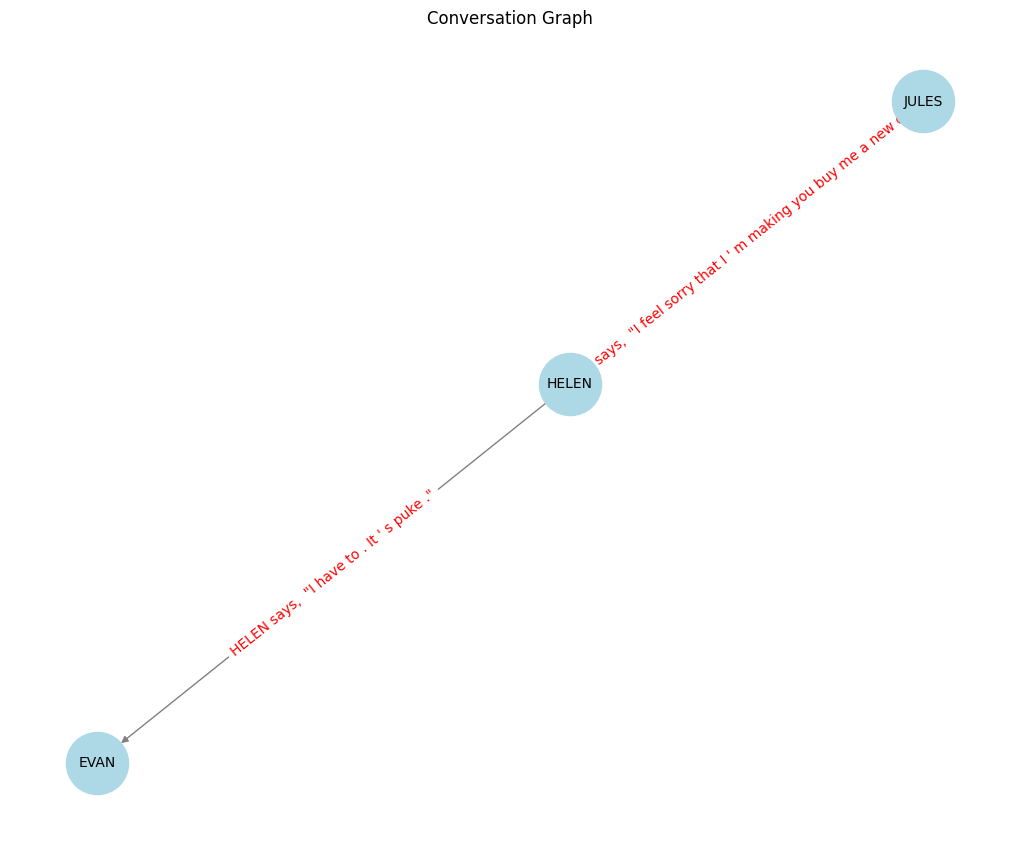

Subgraph 2:
Nodes: ['EVAN', 'SETH']
Edges: [('EVAN', 'SETH', {'line': 'EVAN says,  "Holy shit !"', 'temporal_idx': 5})]


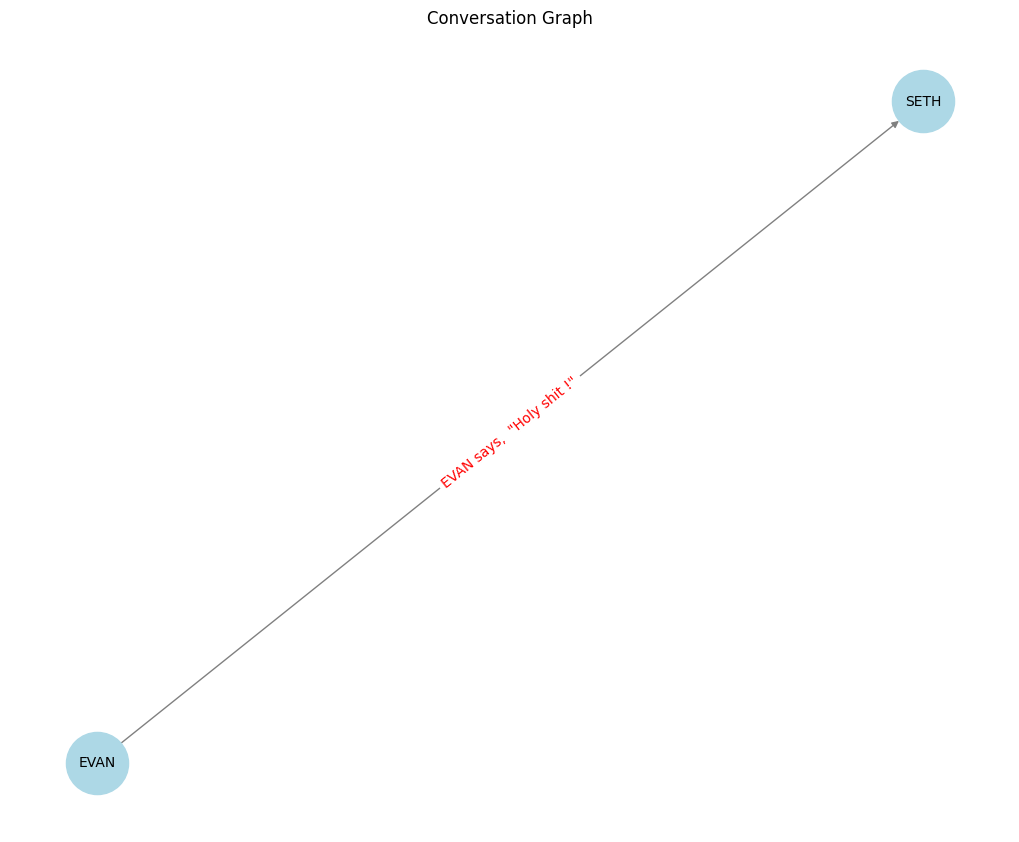

Subgraph 3:
Nodes: ['SETH', 'EVAN']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "Is that them ?"', 'temporal_idx': 7})]


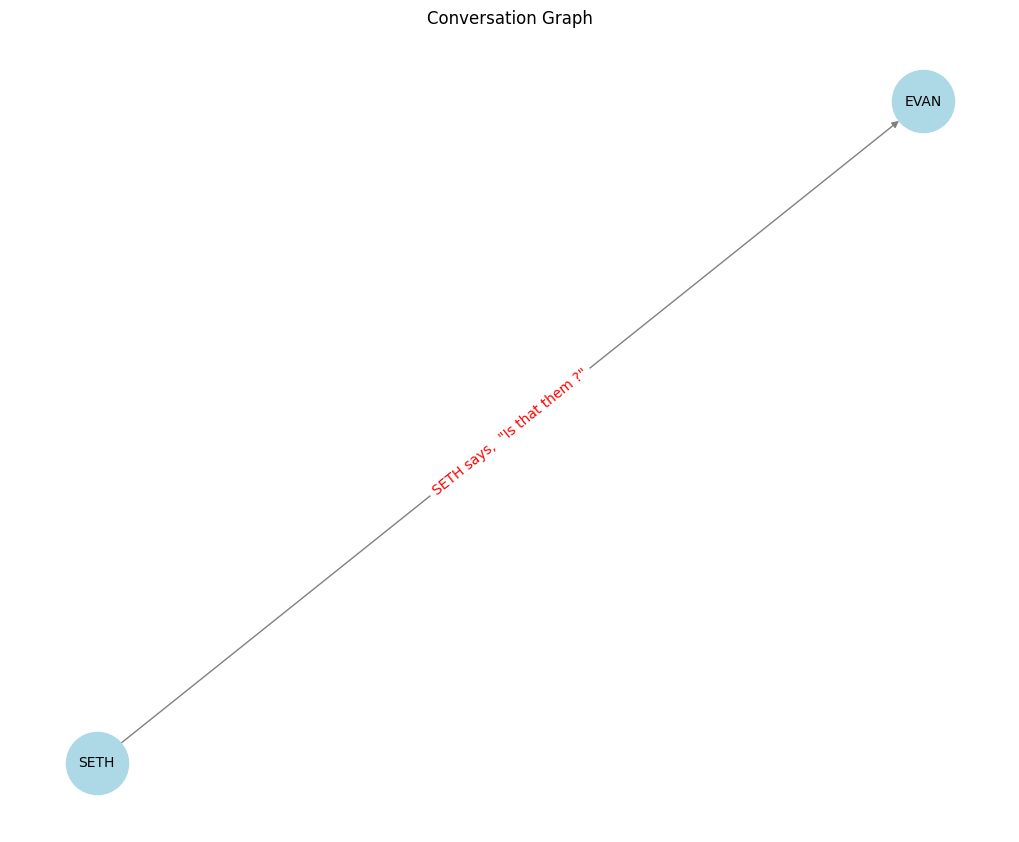

Subgraph 4:
Nodes: ['EVAN', 'SETH']
Edges: [('EVAN', 'SETH', {'line': 'EVAN says,  "Should we hide ?"', 'temporal_idx': 9})]


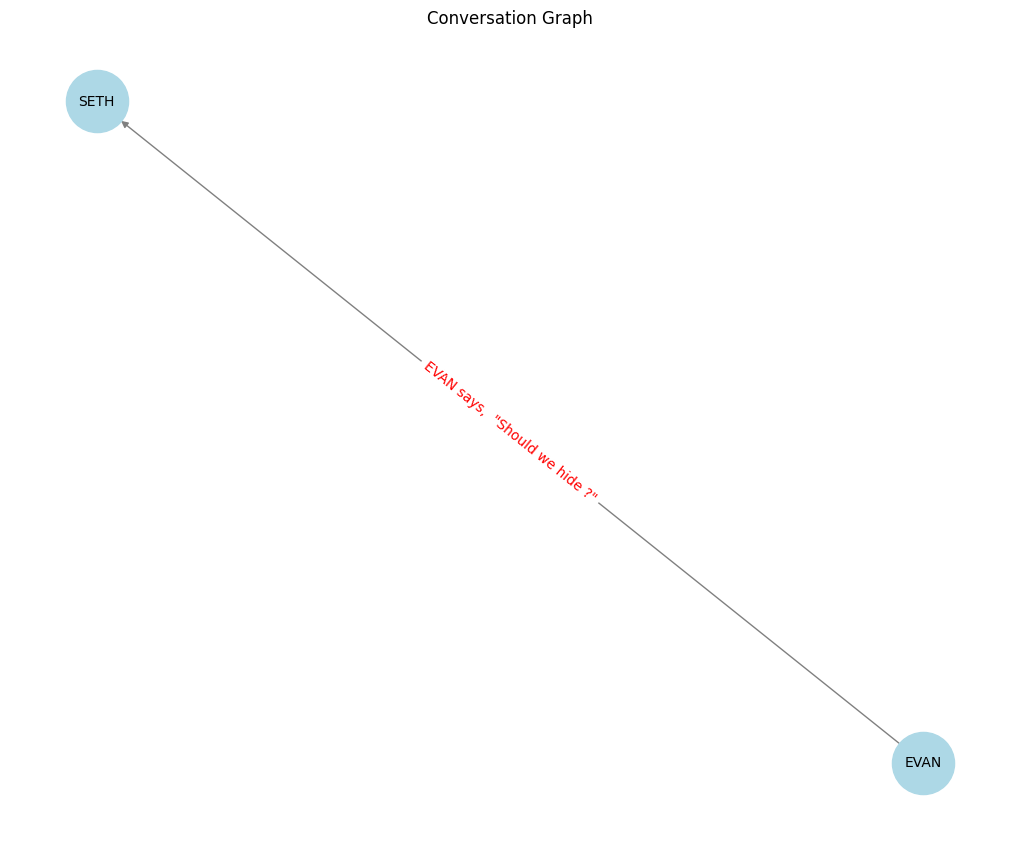

Subgraph 5:
Nodes: ['SETH', 'EVAN', 'HELEN']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "Fuck that , man . I can \' t talk to her , look what I did to her !"', 'temporal_idx': 11}), ('EVAN', 'HELEN', {'line': 'EVAN says,  "Helen called me a pussy to my face ! What am I going to say to her ?"', 'temporal_idx': 12})]


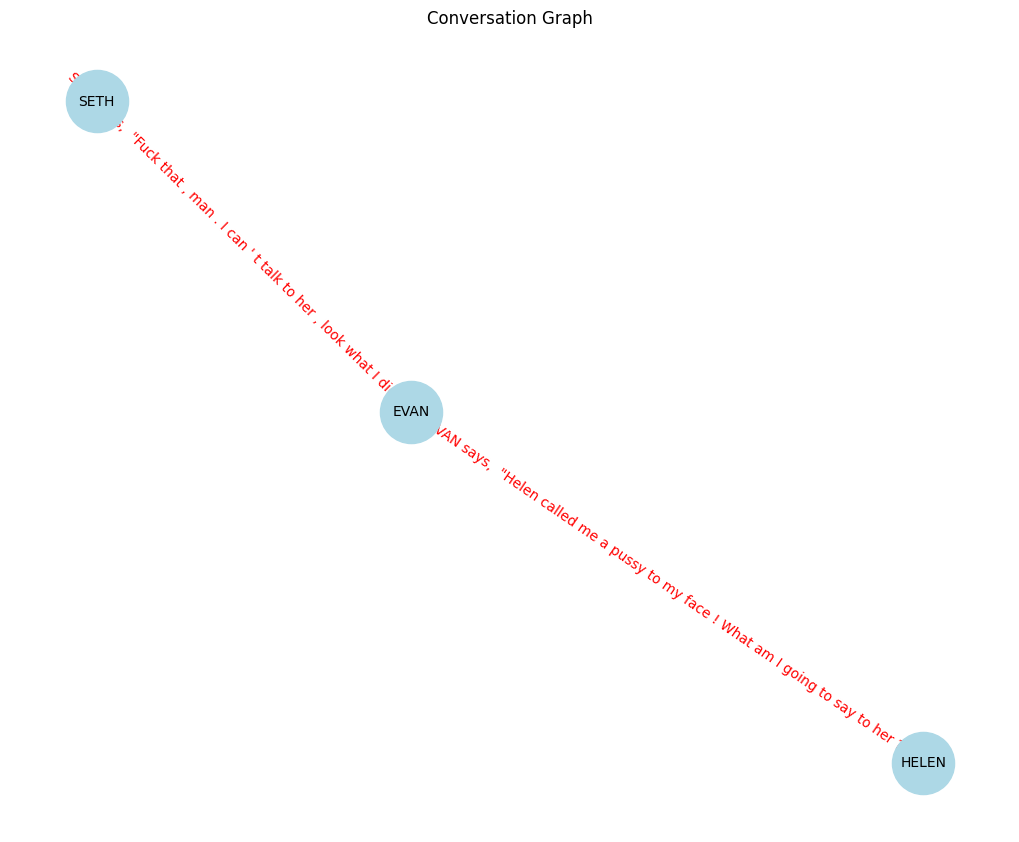

Subgraph 6:
Nodes: ['HELEN', 'EVAN', 'JULES', 'SETH']
Edges: [('HELEN', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14}), ('EVAN', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15}), ('JULES', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14}), ('SETH', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15})]


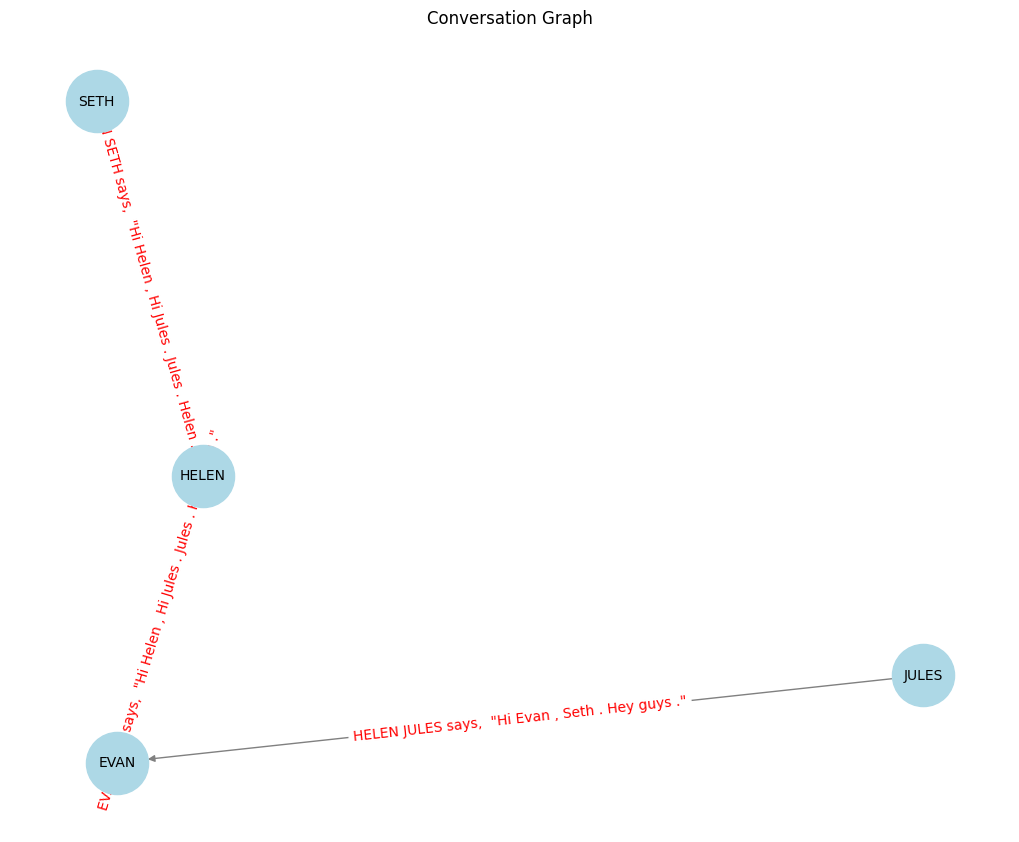

Subgraph 7:
Nodes: ['SETH', 'JULES']
Edges: [('SETH', 'JULES', {'line': 'SETH says,  "Oh my god . I \' m so sorry , Jules ."', 'temporal_idx': 17})]


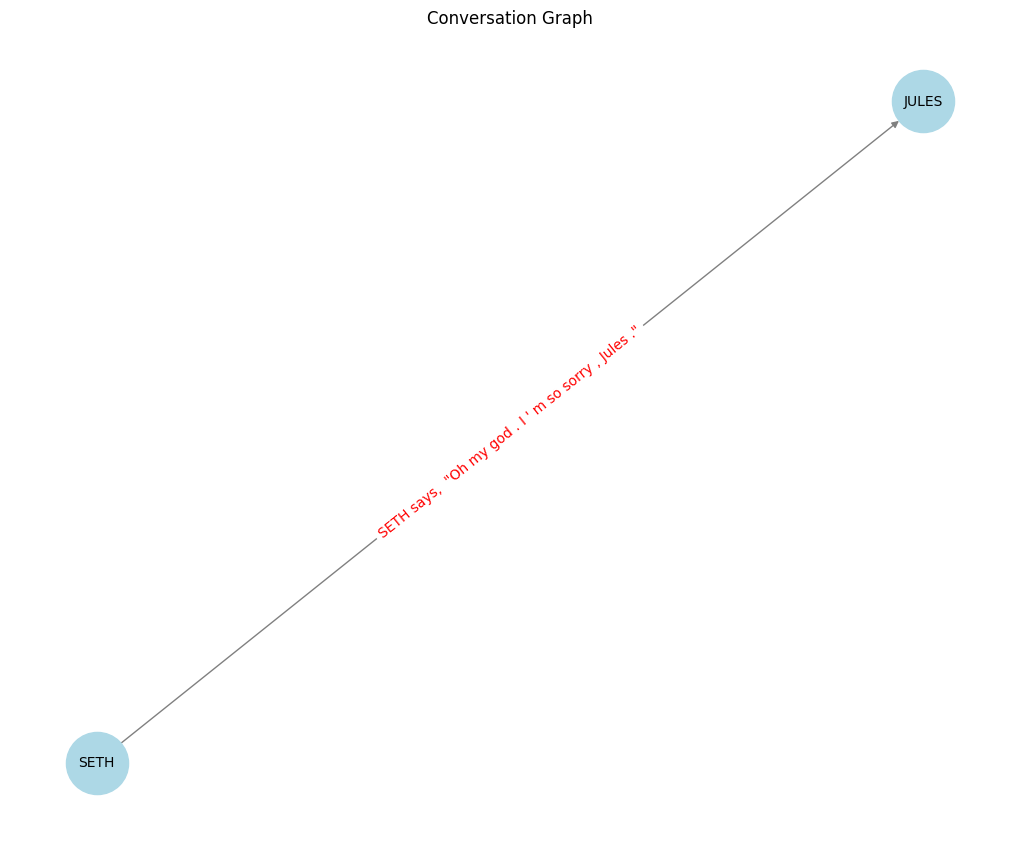

Subgraph 8:
Nodes: ['JULES', 'SETH', 'EVAN', 'HELEN']
Edges: [('JULES', 'SETH', {'line': 'JULES says,  "Do you remember much ?"', 'temporal_idx': 25}), ('SETH', 'JULES', {'line': 'SETH says,  "That looks terrible . No ! I mean , it doesn \' t look terrible , it looks -"', 'temporal_idx': 22}), ('SETH', 'HELEN', {'line': 'SETH says,  "Not really . I remember looking up , and you screaming at me . That \' s about it ."', 'temporal_idx': 27}), ('EVAN', 'HELEN', {'line': 'EVAN says,  "Did you have fun last night ?"', 'temporal_idx': 24}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "Not bad , but not great , how about you ?"', 'temporal_idx': 21}), ('HELEN', 'SETH', {'line': 'HELEN says,  "I really don \' t remember much ."', 'temporal_idx': 26})]


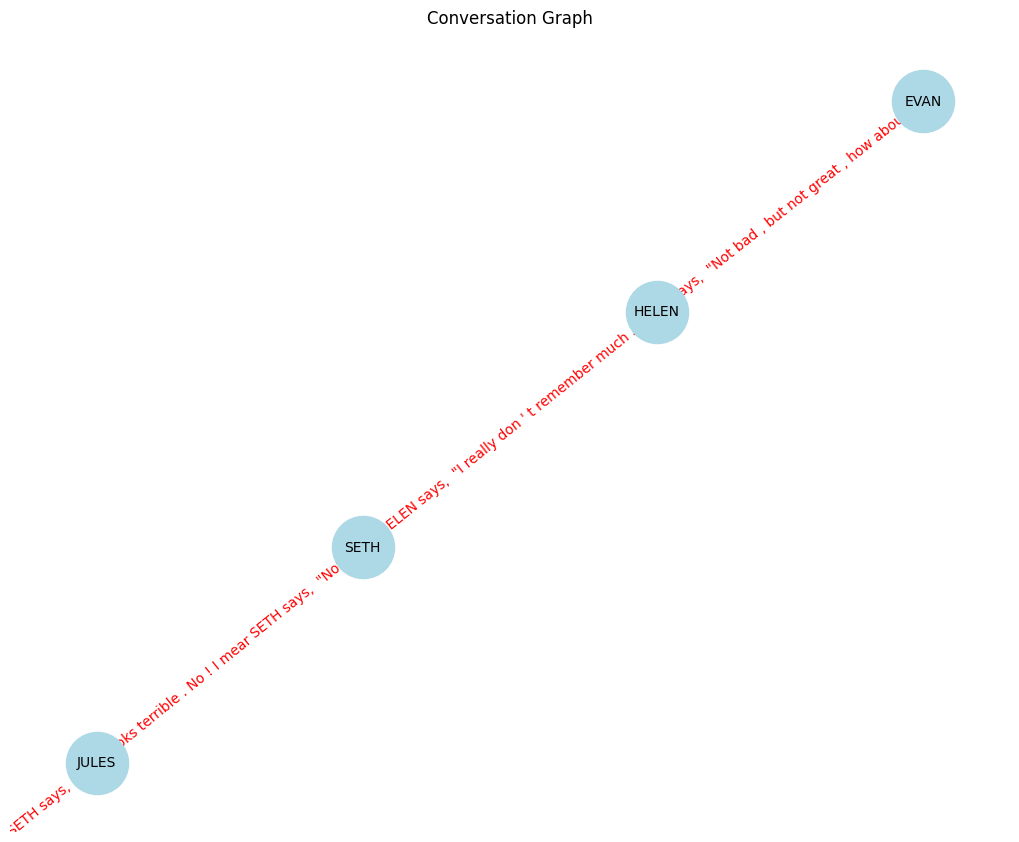

Subgraph 9:
Nodes: ['HELEN', 'SETH']
Edges: [('HELEN', 'SETH', {'line': 'HELEN says,  "I didn \' t puke on you , did I ?"', 'temporal_idx': 29})]


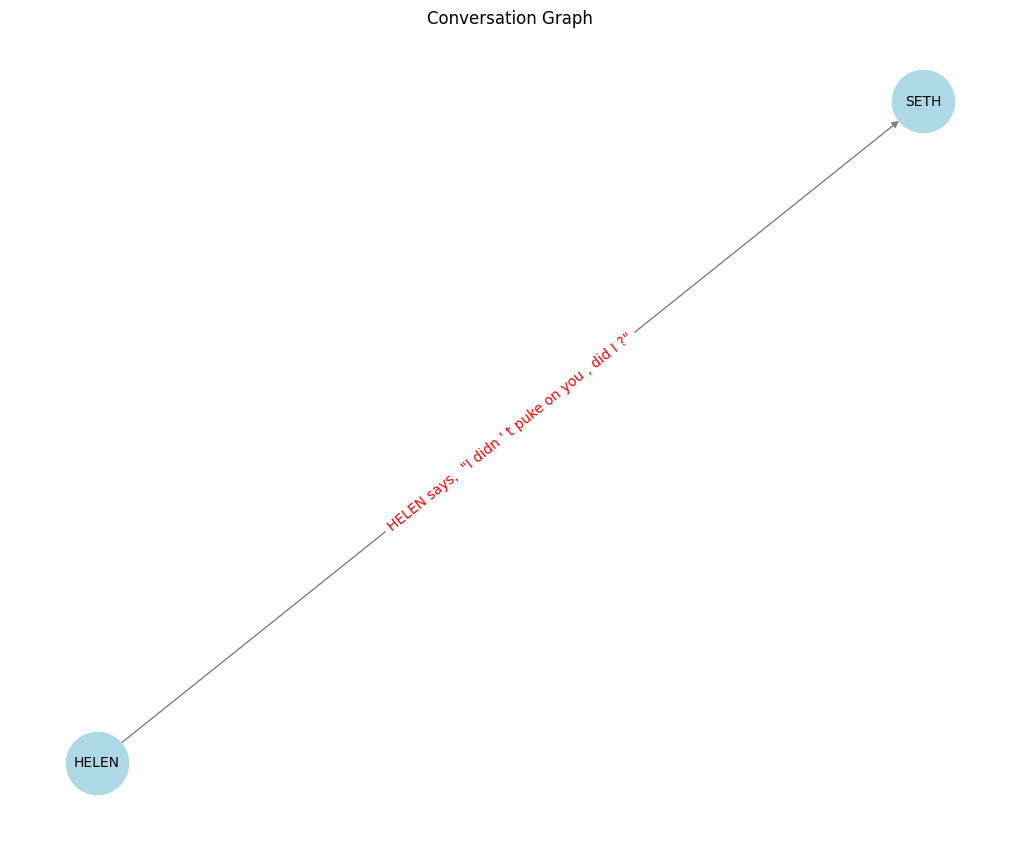

Subgraph 10:
Nodes: ['EVAN', 'HELEN', 'SETH']
Edges: [('EVAN', 'HELEN', {'line': 'EVAN says,  "No , I dodged it . Whizzed right by me ."', 'temporal_idx': 31}), ('SETH', 'HELEN', {'line': 'SETH says,  "But seriously , I acted like a fuckin \' idiot last night . I \' m really sorry , you didn \' t deserve that ."', 'temporal_idx': 32})]


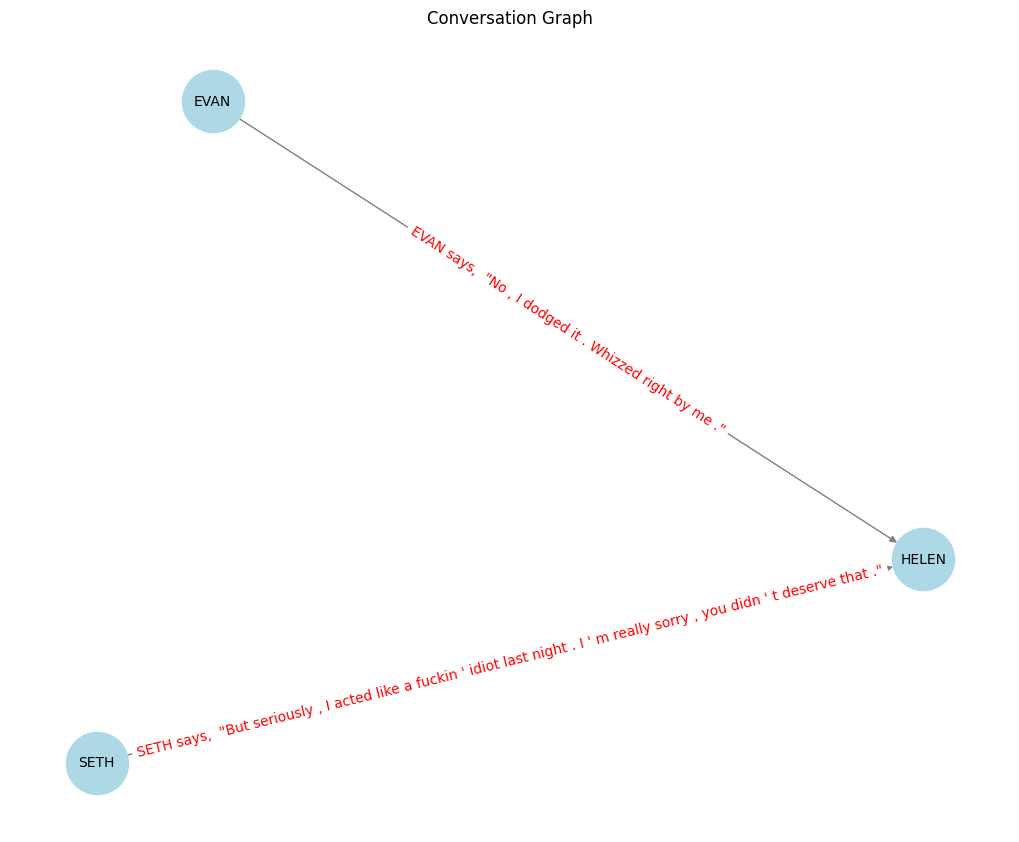

Subgraph 11:
Nodes: ['HELEN', 'EVAN']
Edges: [('HELEN', 'EVAN', {'line': 'HELEN says,  "Yeah , I ... um ... I \' m sorry , about all that . Thanks for being such a gentleman ."', 'temporal_idx': 34})]


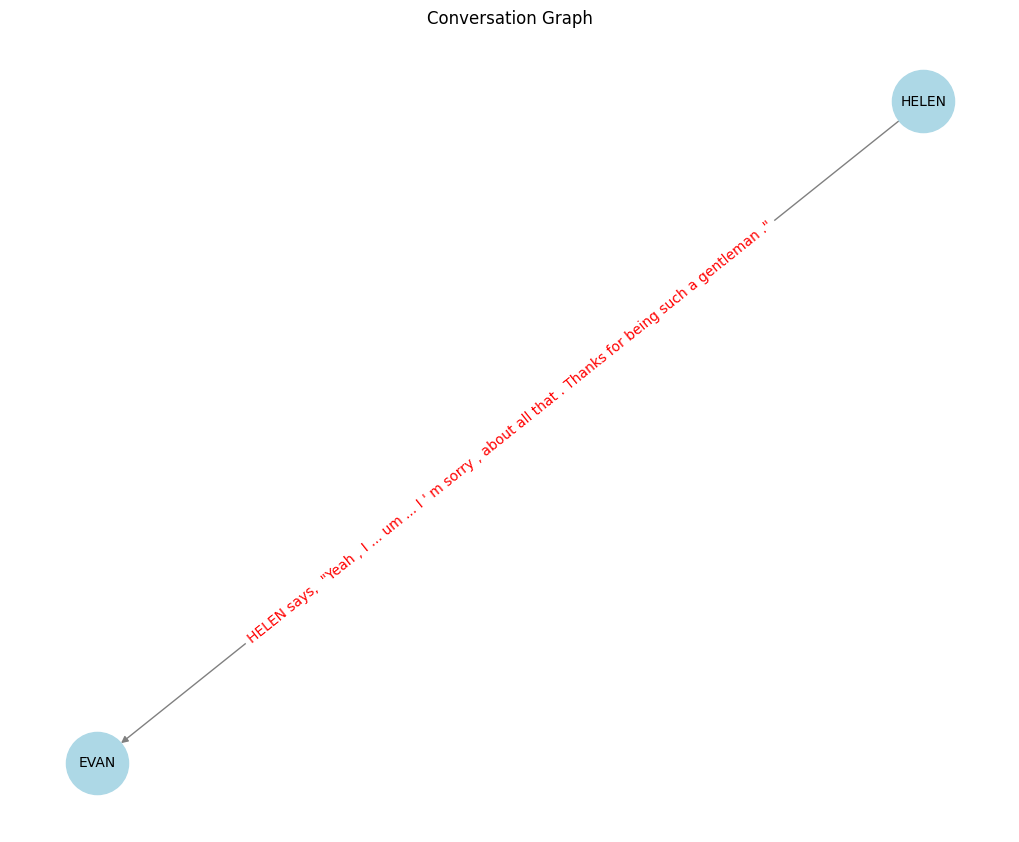

Subgraph 12:
Nodes: ['SETH', 'HELEN']
Edges: [('SETH', 'HELEN', {'line': 'SETH says,  "You look good with a black eye ."', 'temporal_idx': 36})]


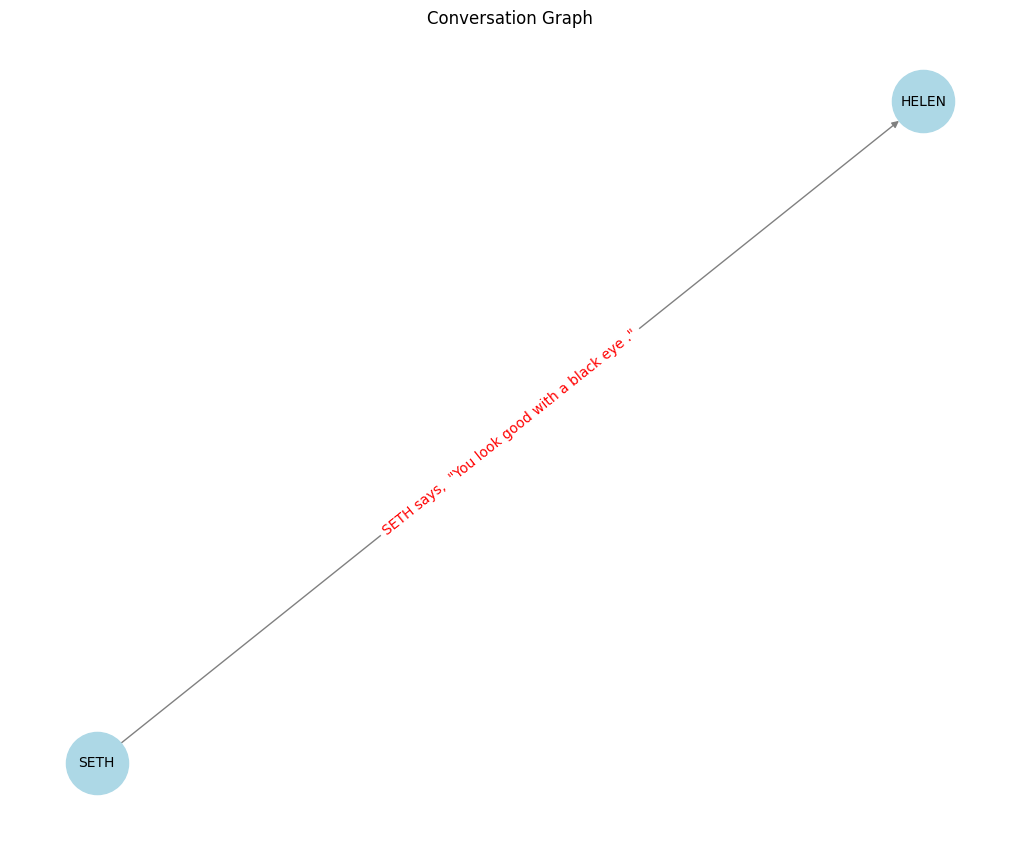

Subgraph 13:
Nodes: ['JULES', 'SETH', 'HELEN', 'EVAN']
Edges: [('JULES', 'SETH', {'line': 'JULES says,  "I \' ve got my dad \' s car . I \' ll take you home , and Evan can give Helen a lift ."', 'temporal_idx': 46}), ('SETH', 'JULES', {'line': 'SETH says,  "Yeah , but wait ... you drove me here , Evan drove me here , how do we -"', 'temporal_idx': 45}), ('HELEN', 'JULES', {'line': 'HELEN says,  "Yeah , and I \' m going to Linen Brothers to buy Jules a new comforter ."', 'temporal_idx': 40}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "That sounds good ."', 'temporal_idx': 47}), ('EVAN', 'JULES', {'line': 'EVAN says,  "You could get your college pants there ."', 'temporal_idx': 44})]


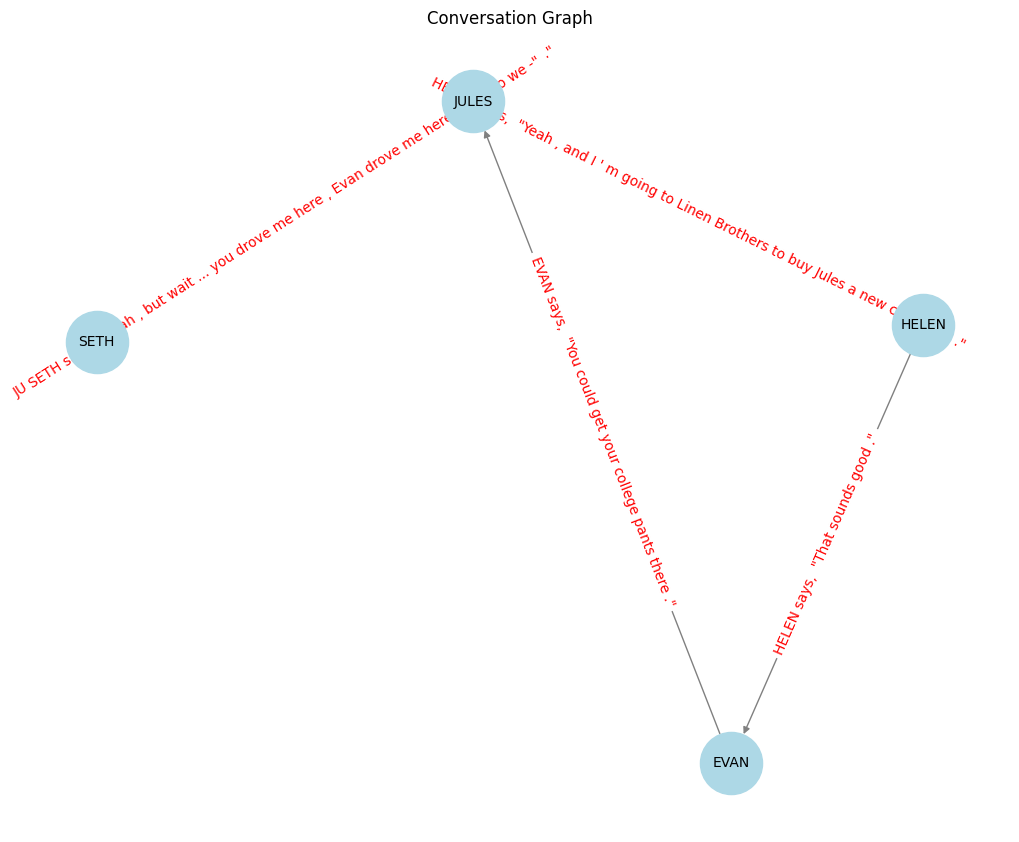

Subgraph 14:
Nodes: ['EVAN', 'HELEN']
Edges: [('EVAN', 'HELEN', {'line': 'EVAN says,  "Maybe we can go eat after ?"', 'temporal_idx': 49}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "Sweet ."', 'temporal_idx': 50})]


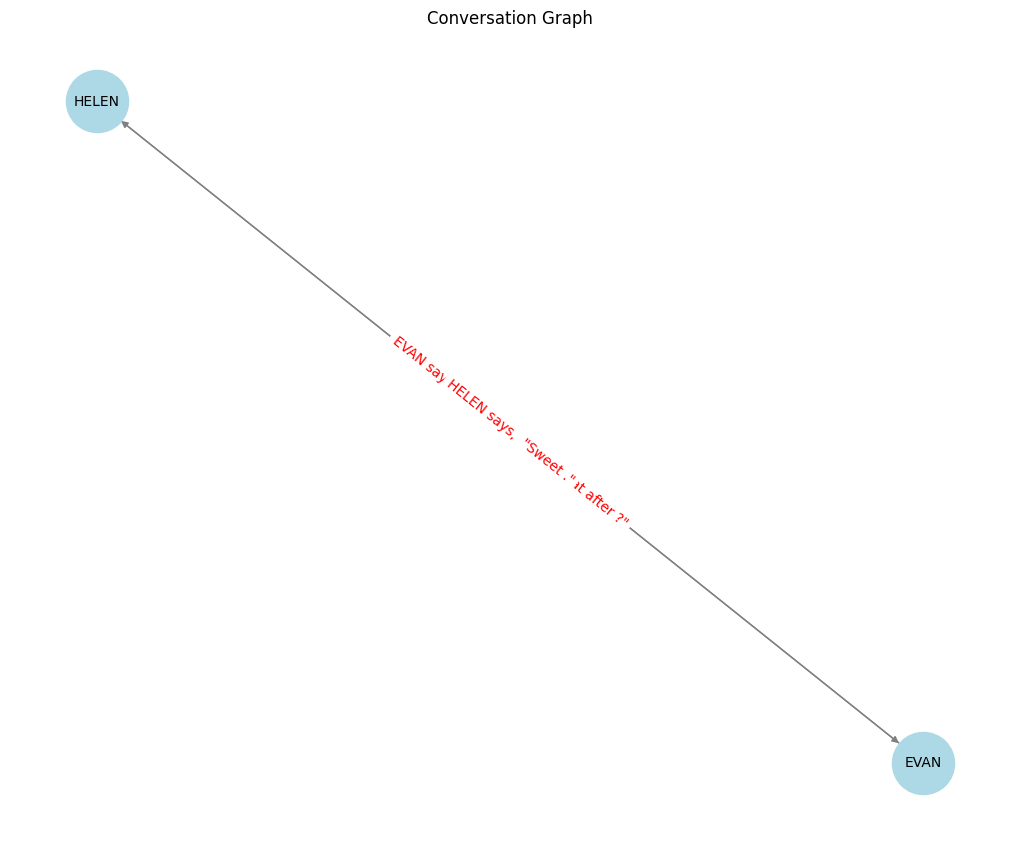

Subgraph 15:
Nodes: ['SETH', 'EVAN', 'JULES']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "So , uh , I \' ll call you later ."', 'temporal_idx': 52}), ('EVAN', 'SETH', {'line': 'EVAN says,  "Yeah man , have a good one ."', 'temporal_idx': 53}), ('JULES', 'SETH', {'line': 'JULES says,  "Come on , Seth . Let \' s go ."', 'temporal_idx': 54})]


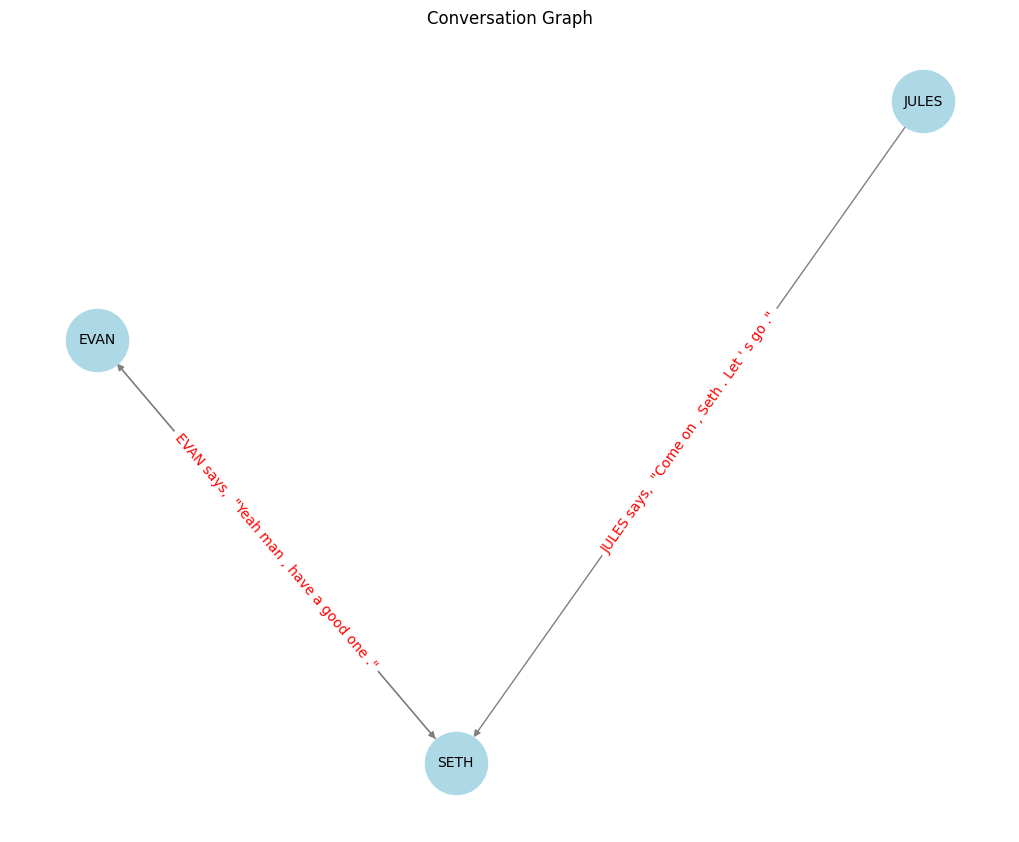

In [209]:
def build_directed_graph_with_temporal_aspect(preprocessed_scene, conversational_targets):
    """
    Build a directed graph with temporal information from the scene's conversational relationships.

    Args:
        preprocessed_scene (list): List of lines in the scene.
        conversational_targets (list): List of tuples (line, recipient).

    Returns:
        networkx.MultiDiGraph: A directed graph with temporal edges representing the conversations.
    """
    import re  # For additional name cleaning if needed
    G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple edges

    for idx, (line, recipient_info) in enumerate(conversational_targets):
        if recipient_info == "No target (narration)":
            # Add narration as a node
            G.add_node(f"Narration_{idx}", type="narration", line=line)
            continue

        # Extract the current speaker
        if "says," in line:
            try:
                speaker, _ = line.split(" says, ", 1)
                # Split multiple names by spaces and treat them as individual speakers
                speakers = [name.strip() for name in speaker.split() if name.strip()]
            except ValueError:
                print(f"Malformed line (could not extract speaker): {line}")
                continue
        else:
            print(f"Non-dialogue line skipped: {line}")
            continue

        # Extract the recipient
        if " is speaking to " in recipient_info:
            try:
                recipient = recipient_info.split(" is speaking to ")[-1].strip()
                recipient = re.sub(r"\s+", " ", recipient)
            except IndexError:
                print(f"Malformed recipient info: {recipient_info}")
                continue
        else:
            print(f"Malformed recipient info (no 'is speaking to'): {recipient_info}")
            continue

        # Add nodes and edges with temporal data
        for speaker in speakers:  # Handle each speaker separately
            G.add_node(speaker, type="speaker")
            G.add_node(recipient, type="speaker")
            G.add_edge(
                speaker,
                recipient,
                key=idx,  # Use temporal index as the unique key
                line=preprocessed_scene[idx],
                temporal_idx=idx
            )

    print("\nGraph Construction Completed.")
    print(f"Number of Nodes: {len(G.nodes())}")
    print(f"Number of Edges: {len(G.edges())}")
    return G


def temporal_clustering(graph, threshold=1):
    """
    Segment the directed graph into subgraphs based on temporal continuity.

    Args:
        graph (networkx.MultiDiGraph): The directed graph with temporal edges.
        threshold (int): The maximum allowable gap in temporal indices for continuity.

    Returns:
        list: List of subgraphs representing temporally segmented conversations.
    """
    # Sort edges by temporal index
    edges = sorted(graph.edges(data=True, keys=True), key=lambda x: x[3]["temporal_idx"])

    # Create subgraphs based on temporal continuity
    subgraphs = []
    current_subgraph = nx.MultiDiGraph()
    prev_idx = None

    for u, v, key, attr in edges:
        current_idx = attr["temporal_idx"]
        if prev_idx is not None and current_idx - prev_idx > threshold:
            # Save the current subgraph and start a new one
            subgraphs.append(current_subgraph)
            current_subgraph = nx.MultiDiGraph()
        # Add edge to the current subgraph
        current_subgraph.add_edge(u, v, key=key, **attr)
        prev_idx = current_idx

    # Append the last subgraph
    if current_subgraph.edges:
        subgraphs.append(current_subgraph)

    return subgraphs

def structural_clustering(subgraph):
    """
    Cluster nodes within a temporal subgraph based on connectivity.

    Args:
        subgraph (networkx.MultiDiGraph): A temporal subgraph.

    Returns:
        list: List of connected subgraphs representing distinct conversations.
    """
    # Find connected components
    clusters = []
    for component in nx.weakly_connected_components(subgraph):
        cluster = subgraph.subgraph(component).copy()
        clusters.append(cluster)
    return clusters

def cluster_conversations(graph, temporal_threshold=1):
    """
    Cluster conversations using temporal and structural continuity.

    Args:
        graph (networkx.MultiDiGraph): The directed graph with temporal edges.
        temporal_threshold (int): The maximum allowable gap in temporal indices for temporal clustering.

    Returns:
        list: List of subgraphs representing distinct conversations.
    """
    # Step 1: Temporal Clustering
    temporal_subgraphs = temporal_clustering(graph, threshold=temporal_threshold)

    # Step 2: Structural Clustering
    conversation_clusters = []
    for subgraph in temporal_subgraphs:
        structural_clusters = structural_clustering(subgraph)
        conversation_clusters.extend(structural_clusters)

    return conversation_clusters



def segment_graph_temporally(graph, threshold=1):
    """
    Segment the directed graph into subgraphs based on temporal gaps.

    Args:
        graph (networkx.DiGraph): The directed graph with temporal edges.
        threshold (int): The maximum allowable gap in temporal indices for continuity.

    Returns:
        list: List of subgraphs representing separate conversations.
    """
    # Sort edges by temporal index
    edges = sorted(graph.edges(data=True), key=lambda x: x[2]["temporal_idx"])
    
    # Create subgraphs based on temporal continuity
    subgraphs = []
    current_subgraph = nx.DiGraph()
    prev_idx = None

    for u, v, attr in edges:
        current_idx = attr["temporal_idx"]
        if prev_idx is not None and current_idx - prev_idx > threshold:
            # Save the current subgraph and start a new one
            subgraphs.append(current_subgraph)
            current_subgraph = nx.DiGraph()
        # Add edge to the current subgraph
        current_subgraph.add_edge(u, v, **attr)
        prev_idx = current_idx

    # Append the last subgraph
    if current_subgraph.edges:
        subgraphs.append(current_subgraph)

    return subgraphs


def visualize_graph(graph):
    """
    Visualize the directed graph.

    Args:
        graph (networkx.DiGraph): Directed graph to visualize.
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)
    labels = nx.get_edge_attributes(graph, "line")
    nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color="red")
    plt.title("Conversation Graph")
    plt.show()

def visualize_all_subgraphs(graph):
    """
    Visualize all subgraphs of a directed graph on a single plot.

    Args:
        graph (networkx.DiGraph): Directed graph to visualize.
    """
    # Extract strongly connected components
    subgraphs = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]

    plt.figure(figsize=(12, 10))
    layout = nx.spring_layout(graph)  # Shared layout for consistency

    for i, subgraph in enumerate(subgraphs, start=1):
        # Draw each subgraph with a distinct color
        pos = {node: layout[node] for node in subgraph.nodes()}  # Use shared layout
        nx.draw(
            subgraph,
            pos,
            with_labels=True,
            node_color=f"C{i % 10}",  # Cycle through 10 distinct colors
            edge_color="gray",
            node_size=2000,
            font_size=10,
            label=f"Subgraph {i}",
        )
        labels = nx.get_edge_attributes(subgraph, "line")
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_color="red")

    plt.title("Conversation Subgraphs")
    plt.legend(loc="best")
    plt.show()

# Example usage
# visualize_all_subgraphs(conversation_graph)
# Example usage
conversation_graph = build_directed_graph_with_temporal_aspect(preprocessed_scene, conversational_targets)
conversation_subgraphs = segment_graph_temporally(conversation_graph, threshold=1)

# Print and visualize each subgraph
for idx, subgraph in enumerate(conversation_subgraphs, 1):
    print(f"Subgraph {idx}:")
    print("Nodes:", subgraph.nodes)
    print("Edges:", list(subgraph.edges(data=True)))
    visualize_graph(subgraph)

In [104]:
from networkx.algorithms.community import louvain_communities

def cluster_graph(graph):
    communities = louvain_communities(graph)
    clusters = {idx: list(community) for idx, community in enumerate(communities)}
    return clusters

clusters = cluster_graph(conversation_graph)
print("Clusters:", clusters)

Clusters: {0: ['JULES', 'HELEN'], 1: ['SETH', 'EVAN']}


In [106]:
full_scene = reconstructed_scenes[150]
full_scene

['S: INT . DEPARTMENT STORE',
 'N: 150 150 They walk through the department store , when suddenly , Evan sees Helen and Jules looking at comforters . ANGLE ON : Helen and Jules ( CONTINUED ) 150 CONTINUED : 150',
 'C: HELEN',
 "D: Again , I ' m so sorry . I can ' t believe I actually did that .",
 'C: JULES',
 "D: I feel sorry that I ' m making you buy me a new one .",
 'C: HELEN',
 "D: I have to . It ' s puke .",
 'N: ANGLE ON : Seth and Evan',
 'C: EVAN',
 'D: Holy shit !',
 'N: Helen looks like hell and Jules has a horrible black eye .',
 'C: SETH',
 'D: Is that them ?',
 'N: They stare at the two girls from afar .',
 'C: EVAN',
 'D: Should we hide ?',
 'N: Helen looks and notices them . She waves and points them out to Jules . Seth and Evan wave back . The girls get up and start to walk over .',
 'C: SETH',
 'E: ( pretending to smile )',
 "D: Fuck that , man . I can ' t talk to her , look what I did to her !",
 'C: EVAN',
 'E: ( pretending to smile )',
 'D: Helen called me a pussy 

In [107]:
preprocessed_scene = preprocess_scene(full_scene)
preprocessed_scene

['This happens in the scene: "150 150 They walk through the department store , when suddenly , Evan sees Helen and Jules looking at comforters . ANGLE ON : Helen and Jules ( CONTINUED ) 150 CONTINUED : 150"',
 'HELEN says,  "Again , I \' m so sorry . I can \' t believe I actually did that ."',
 'JULES says,  "I feel sorry that I \' m making you buy me a new one ."',
 'HELEN says,  "I have to . It \' s puke ."',
 'This happens in the scene: "ANGLE ON : Seth and Evan"',
 'EVAN says,  "Holy shit !"',
 'This happens in the scene: "Helen looks like hell and Jules has a horrible black eye ."',
 'SETH says,  "Is that them ?"',
 'This happens in the scene: "They stare at the two girls from afar ."',
 'EVAN says,  "Should we hide ?"',
 'This happens in the scene: "Helen looks and notices them . She waves and points them out to Jules . Seth and Evan wave back . The girls get up and start to walk over ."',
 'SETH says,  "Fuck that , man . I can \' t talk to her , look what I did to her !"',
 'EVA

In [115]:
def get_context_within_limit_simple(preprocessed_scene, idx, num_lines=3):
    """
    Extract a fixed number of lines before and after the current line in the scene.

    Args:
        preprocessed_scene (list): List of strings representing the scene.
        idx (int): Index of the current line in the scene.
        num_lines (int): Number of lines to include before and after the current line (default: 3).

    Returns:
        str: The context window with surrounding lines and the current line.
    """
    start_idx = max(0, idx - num_lines)  # Ensure the start index is not negative
    end_idx = min(len(preprocessed_scene), idx + num_lines + 1)  # Ensure the end index is within bounds

    # Slice the context and join it into a single string
    context = "\n".join(preprocessed_scene[start_idx:end_idx])
    return context

In [117]:
# Define characters from the preprocessed scene
characters = ["HELEN", "JULES", "EVAN", "SETH"]

# Initialize predictions
conversational_targets = []

preprocessed_scene = preprocess_scene(full_scene)

# Process each line in the preprocessed scene
for idx, line in enumerate(preprocessed_scene):
    # Skip non-dialogue lines
    if "says," not in line:
        conversational_targets.append((line, "No target (narration)"))
        continue

    # Extract current speaker and dialogue
    speaker, dialogue = line.split(" says, ")
    dialogue = dialogue.strip()

    # Use the context window to limit the number of tokens
    context_window = get_context_within_limit_simple(preprocessed_scene, idx, 3)

    # Provide limited context, highlighting the current line
    context = (
        f"Limited Scene Context:\n{context_window}\n\n"
        f"Now analyzing:\nSpeaker: {speaker}\nLine: {dialogue}"
    )

    # Formulate hypotheses
    hypotheses = [f"{speaker} is speaking to {character}" for character in characters if character != speaker]

    # Use zero-shot classification
    result = classifier(context, hypotheses)

    # Select the most likely target
    target = result["labels"][0]
    conversational_targets.append((line, target))
    print((line, target))

# Print the results
for dialogue, target in conversational_targets:
    print(f"{dialogue} -> {target}")

('HELEN says,  "Again , I \' m so sorry . I can \' t believe I actually did that ."', 'HELEN is speaking to JULES')
('JULES says,  "I feel sorry that I \' m making you buy me a new one ."', 'JULES is speaking to HELEN')
('HELEN says,  "I have to . It \' s puke ."', 'HELEN is speaking to EVAN')
('EVAN says,  "Holy shit !"', 'EVAN is speaking to SETH')
('SETH says,  "Is that them ?"', 'SETH is speaking to EVAN')
('EVAN says,  "Should we hide ?"', 'EVAN is speaking to SETH')
('SETH says,  "Fuck that , man . I can \' t talk to her , look what I did to her !"', 'SETH is speaking to EVAN')
('EVAN says,  "Helen called me a pussy to my face ! What am I going to say to her ?"', 'EVAN is speaking to HELEN')
('HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'HELEN JULES is speaking to EVAN')
('EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'EVAN SETH is speaking to HELEN')
('SETH says,  "Oh my god . I \' m so sorry , Jules ."', 'SETH is speaking to JULES')
('JULES says,  "It \

In [183]:
conversational_targets

[('This happens in the scene: "150 150 They walk through the department store , when suddenly , Evan sees Helen and Jules looking at comforters . ANGLE ON : Helen and Jules ( CONTINUED ) 150 CONTINUED : 150"',
  'No target (narration)'),
 ('HELEN says,  "Again , I \' m so sorry . I can \' t believe I actually did that ."',
  'HELEN is speaking to JULES'),
 ('JULES says,  "I feel sorry that I \' m making you buy me a new one ."',
  'JULES is speaking to HELEN'),
 ('HELEN says,  "I have to . It \' s puke ."', 'HELEN is speaking to EVAN'),
 ('This happens in the scene: "ANGLE ON : Seth and Evan"',
  'No target (narration)'),
 ('EVAN says,  "Holy shit !"', 'EVAN is speaking to SETH'),
 ('This happens in the scene: "Helen looks like hell and Jules has a horrible black eye ."',
  'No target (narration)'),
 ('SETH says,  "Is that them ?"', 'SETH is speaking to EVAN'),
 ('This happens in the scene: "They stare at the two girls from afar ."',
  'No target (narration)'),
 ('EVAN says,  "Should w

In [201]:
conversation_graph = build_directed_graph_with_temporal_aspect(preprocessed_scene, conversational_targets)
conversation_subgraphs = segment_graph_temporally(conversation_graph, threshold=5)


Processing index 0:
Line: This happens in the scene: "150 150 They walk through the department store , when suddenly , Evan sees Helen and Jules looking at comforters . ANGLE ON : Helen and Jules ( CONTINUED ) 150 CONTINUED : 150"
Recipient Info: No target (narration)
Adding narration node.

Processing index 1:
Line: HELEN says,  "Again , I ' m so sorry . I can ' t believe I actually did that ."
Recipient Info: HELEN is speaking to JULES
Extracted Speaker: HELEN
Extracted Recipient: JULES
Added Edge: HELEN -> JULES with Temporal Index: 1

Processing index 2:
Line: JULES says,  "I feel sorry that I ' m making you buy me a new one ."
Recipient Info: JULES is speaking to HELEN
Extracted Speaker: JULES
Extracted Recipient: HELEN
Added Edge: JULES -> HELEN with Temporal Index: 2

Processing index 3:
Line: HELEN says,  "I have to . It ' s puke ."
Recipient Info: HELEN is speaking to EVAN
Extracted Speaker: HELEN
Extracted Recipient: EVAN
Added Edge: HELEN -> EVAN with Temporal Index: 3

Pro


Graph Construction Completed.
Number of Nodes: 20
Number of Edges: 42

Cluster 1:
Nodes: ['HELEN', 'JULES', 'EVAN']
Edges: [('HELEN', 'JULES', {'line': 'HELEN says,  "Again , I \' m so sorry . I can \' t believe I actually did that ."', 'temporal_idx': 1}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "I have to . It \' s puke ."', 'temporal_idx': 3}), ('JULES', 'HELEN', {'line': 'JULES says,  "I feel sorry that I \' m making you buy me a new one ."', 'temporal_idx': 2})]


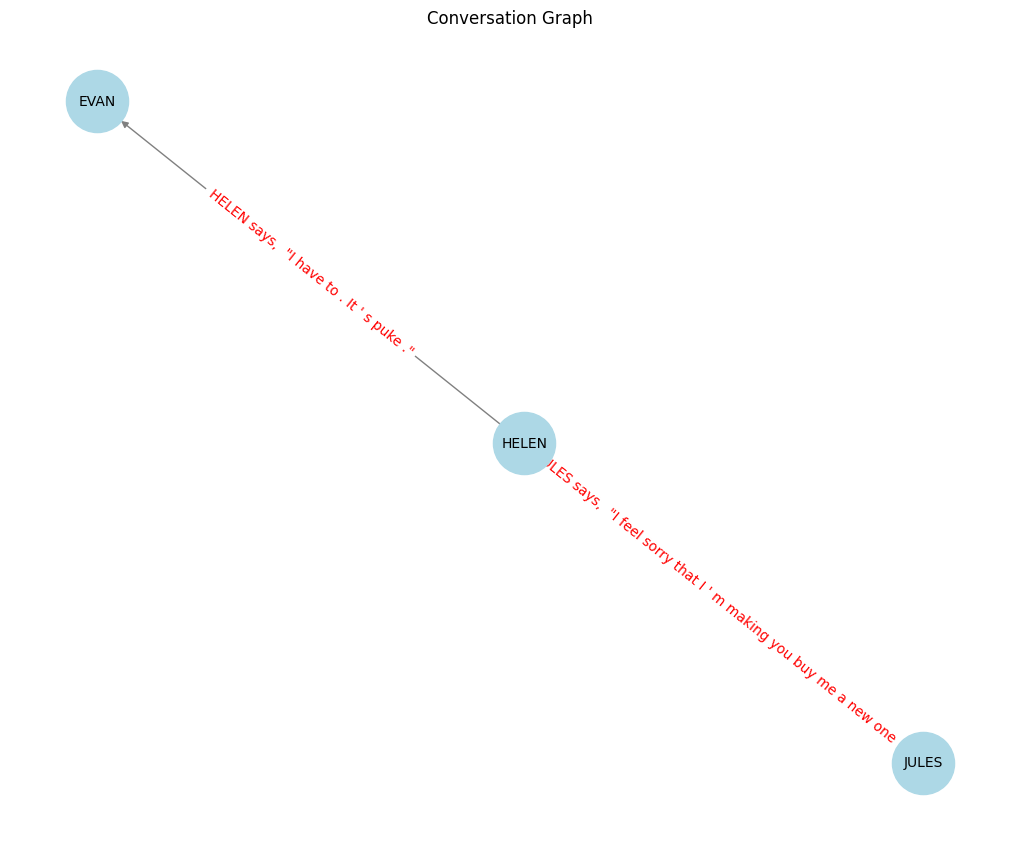


Cluster 2:
Nodes: ['EVAN', 'SETH']
Edges: [('EVAN', 'SETH', {'line': 'EVAN says,  "Holy shit !"', 'temporal_idx': 5})]


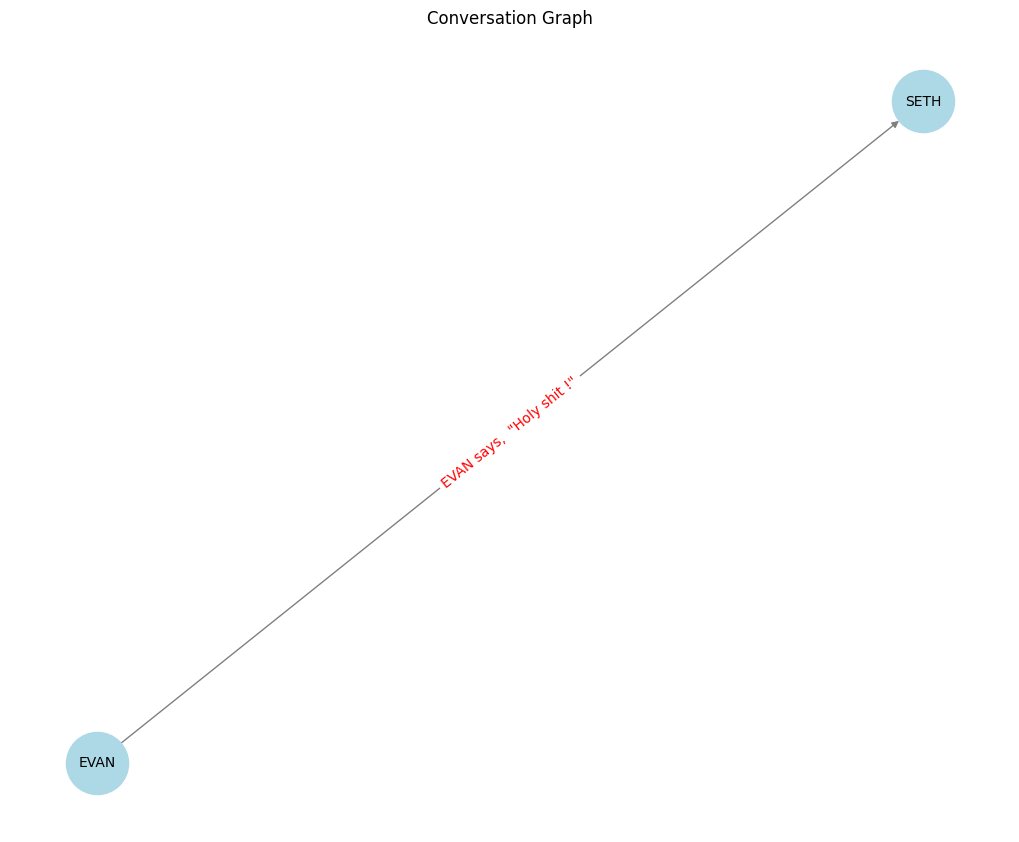


Cluster 3:
Nodes: ['SETH', 'EVAN']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "Is that them ?"', 'temporal_idx': 7})]


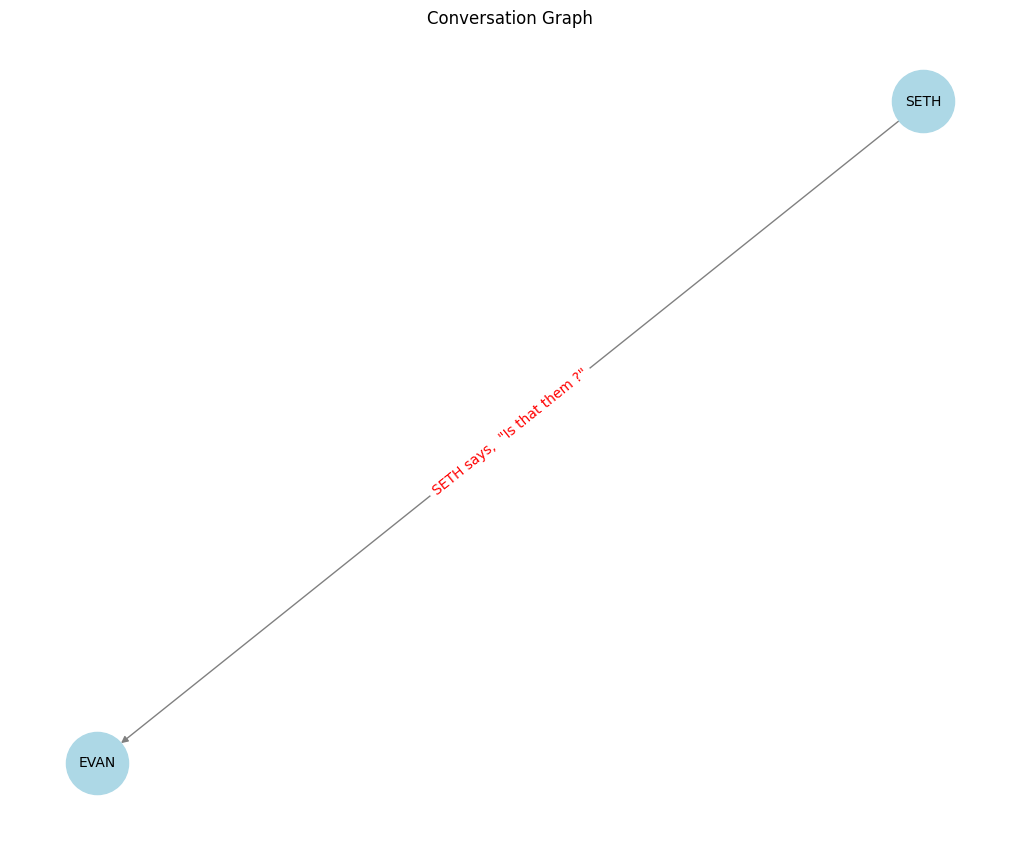


Cluster 4:
Nodes: ['EVAN', 'SETH']
Edges: [('EVAN', 'SETH', {'line': 'EVAN says,  "Should we hide ?"', 'temporal_idx': 9})]


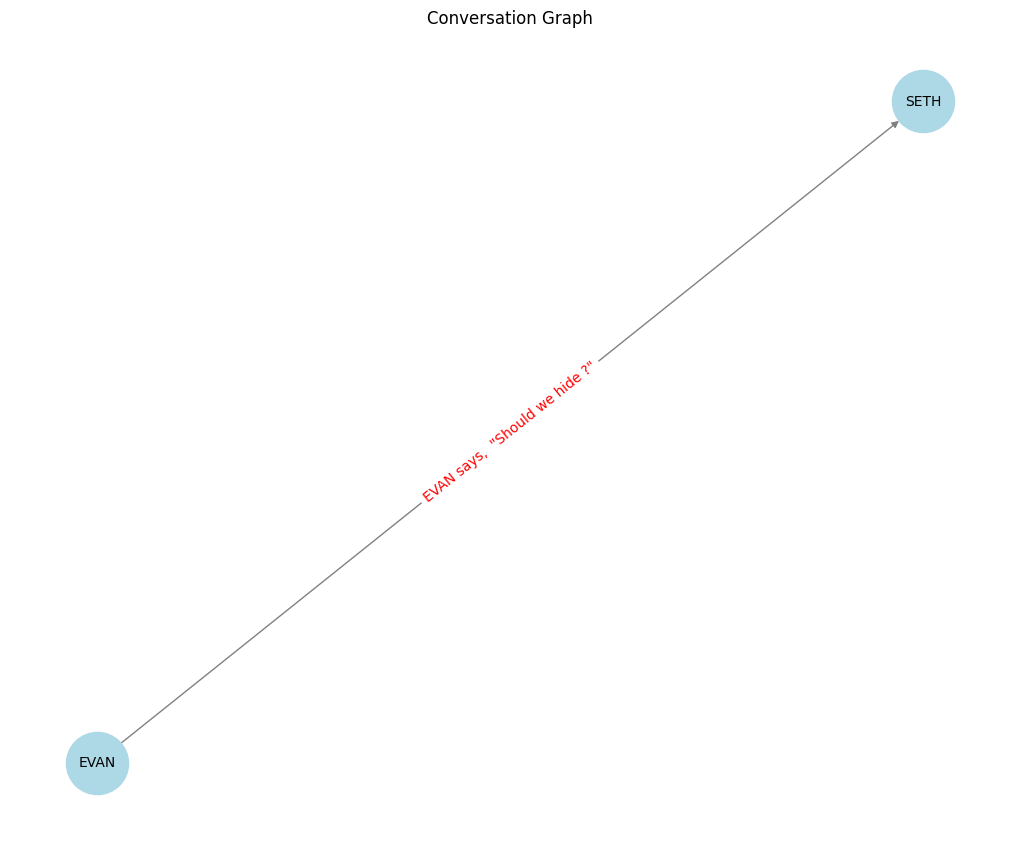


Cluster 5:
Nodes: ['SETH', 'EVAN', 'HELEN']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "Fuck that , man . I can \' t talk to her , look what I did to her !"', 'temporal_idx': 11}), ('EVAN', 'HELEN', {'line': 'EVAN says,  "Helen called me a pussy to my face ! What am I going to say to her ?"', 'temporal_idx': 12})]


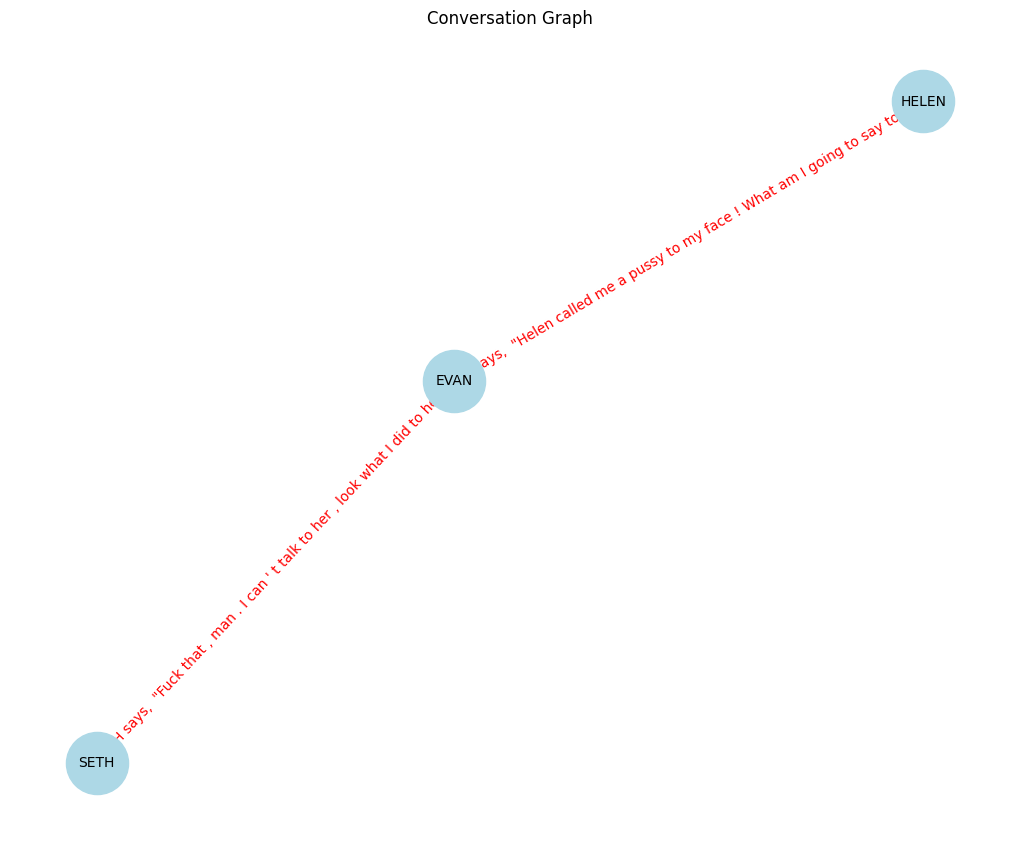


Cluster 6:
Nodes: ['HELEN', 'EVAN', 'JULES', 'SETH']
Edges: [('HELEN', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14}), ('EVAN', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15}), ('JULES', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14}), ('SETH', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15})]


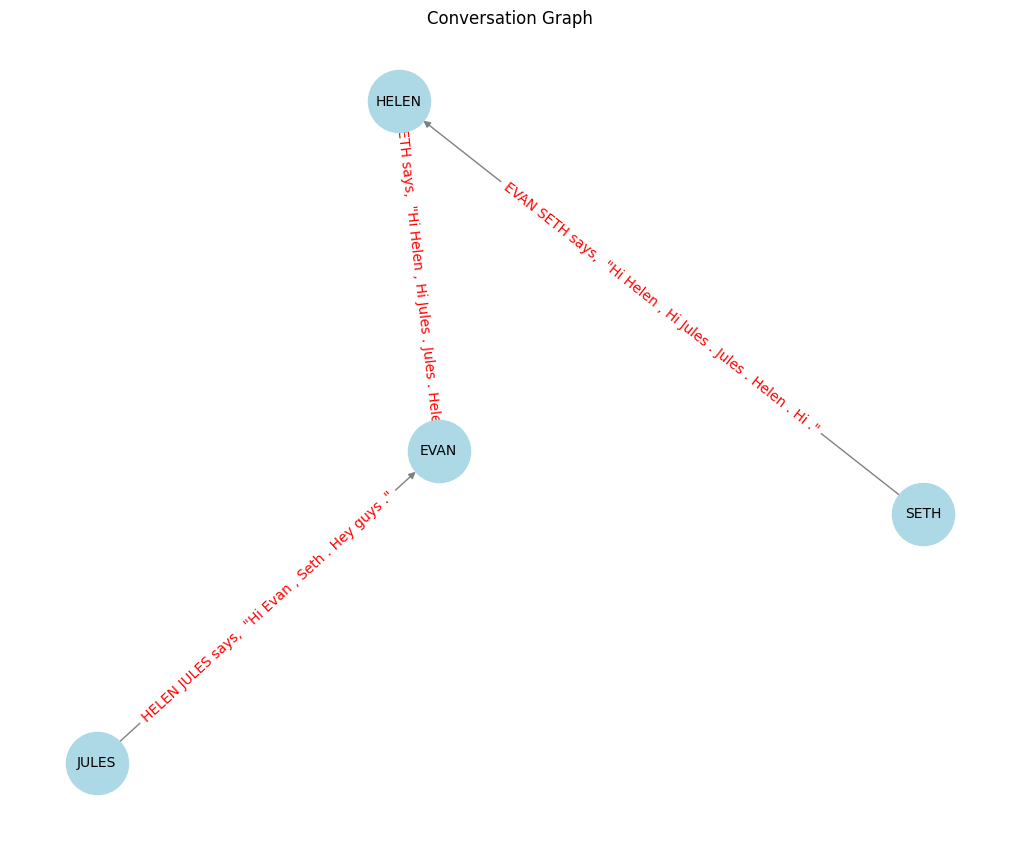


Cluster 7:
Nodes: ['SETH', 'JULES']
Edges: [('SETH', 'JULES', {'line': 'SETH says,  "Oh my god . I \' m so sorry , Jules ."', 'temporal_idx': 17})]


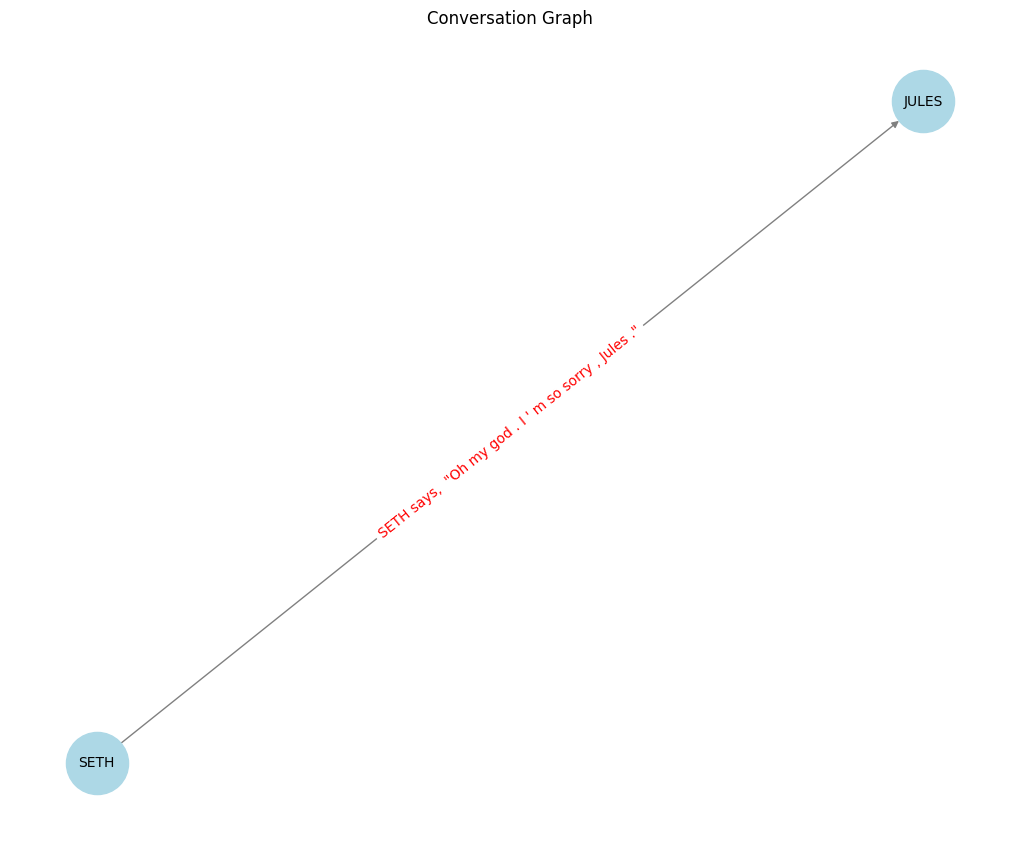


Cluster 8:
Nodes: ['JULES', 'SETH', 'EVAN', 'HELEN']
Edges: [('JULES', 'SETH', {'line': 'JULES says,  "It \' s okay ."', 'temporal_idx': 19}), ('JULES', 'SETH', {'line': 'JULES says,  "Don \' t worry about it , Seth . It was an accident ."', 'temporal_idx': 23}), ('JULES', 'SETH', {'line': 'JULES says,  "Do you remember much ?"', 'temporal_idx': 25}), ('SETH', 'JULES', {'line': 'SETH says,  "That looks terrible . No ! I mean , it doesn \' t look terrible , it looks -"', 'temporal_idx': 22}), ('SETH', 'HELEN', {'line': 'SETH says,  "Not really . I remember looking up , and you screaming at me . That \' s about it ."', 'temporal_idx': 27}), ('EVAN', 'HELEN', {'line': 'EVAN says,  "How are you feeling ?"', 'temporal_idx': 20}), ('EVAN', 'HELEN', {'line': 'EVAN says,  "Did you have fun last night ?"', 'temporal_idx': 24}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "Not bad , but not great , how about you ?"', 'temporal_idx': 21}), ('HELEN', 'SETH', {'line': 'HELEN says,  "I really don \' t

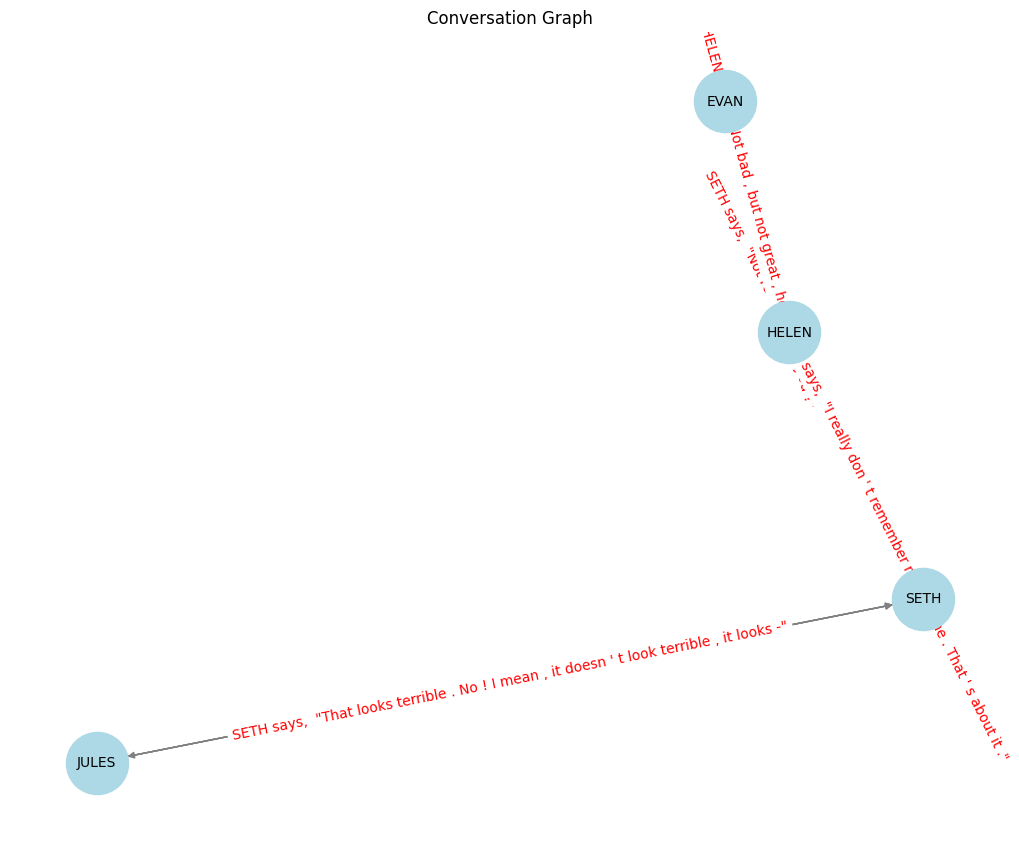


Cluster 9:
Nodes: ['HELEN', 'SETH']
Edges: [('HELEN', 'SETH', {'line': 'HELEN says,  "I didn \' t puke on you , did I ?"', 'temporal_idx': 29})]


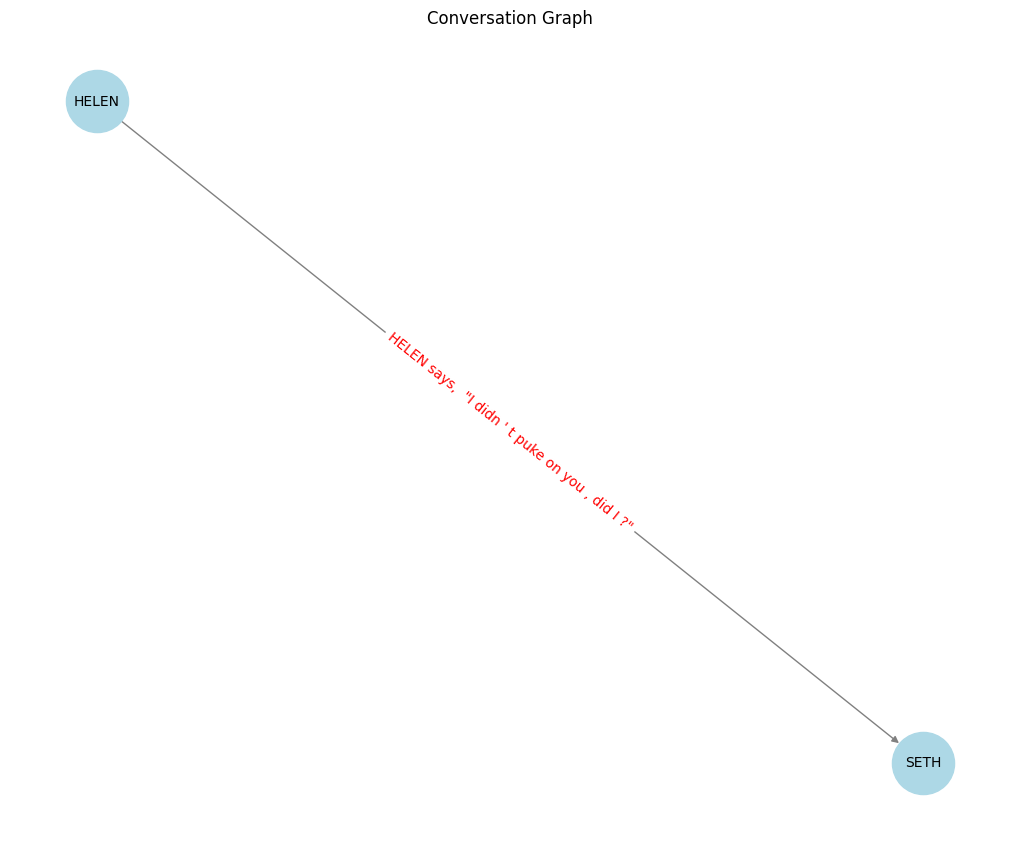


Cluster 10:
Nodes: ['EVAN', 'HELEN', 'SETH']
Edges: [('EVAN', 'HELEN', {'line': 'EVAN says,  "No , I dodged it . Whizzed right by me ."', 'temporal_idx': 31}), ('SETH', 'HELEN', {'line': 'SETH says,  "But seriously , I acted like a fuckin \' idiot last night . I \' m really sorry , you didn \' t deserve that ."', 'temporal_idx': 32})]


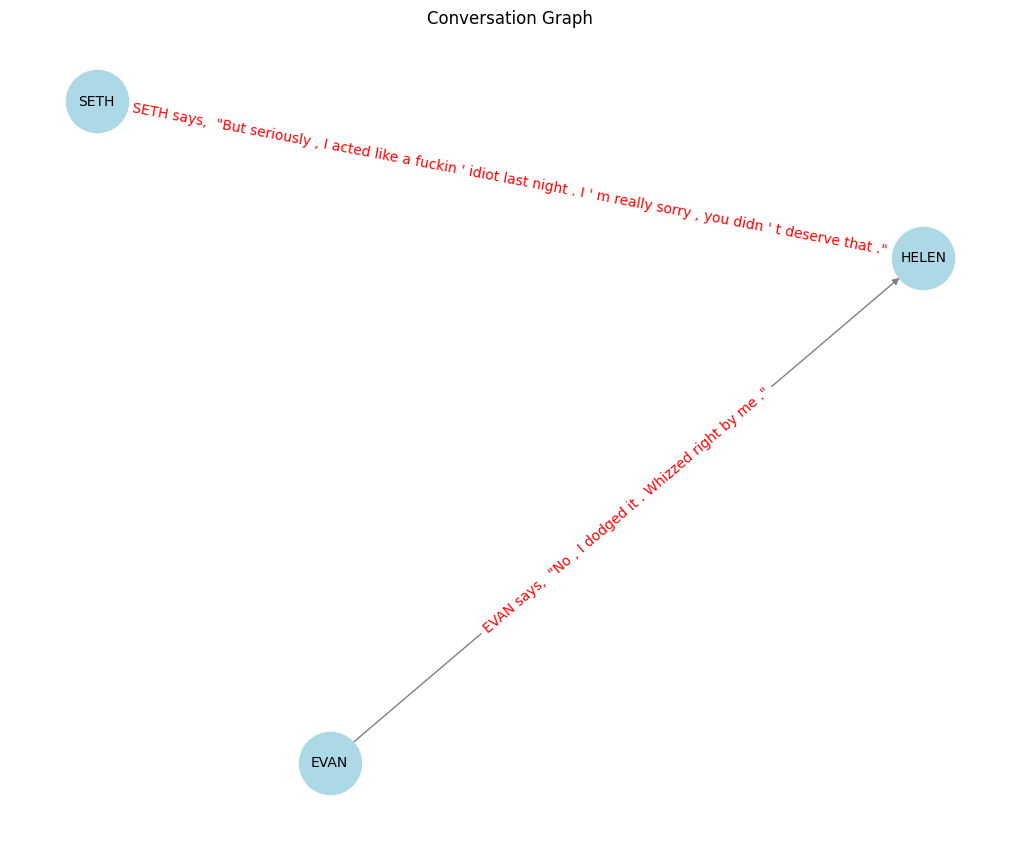


Cluster 11:
Nodes: ['HELEN', 'EVAN']
Edges: [('HELEN', 'EVAN', {'line': 'HELEN says,  "Yeah , I ... um ... I \' m sorry , about all that . Thanks for being such a gentleman ."', 'temporal_idx': 34})]


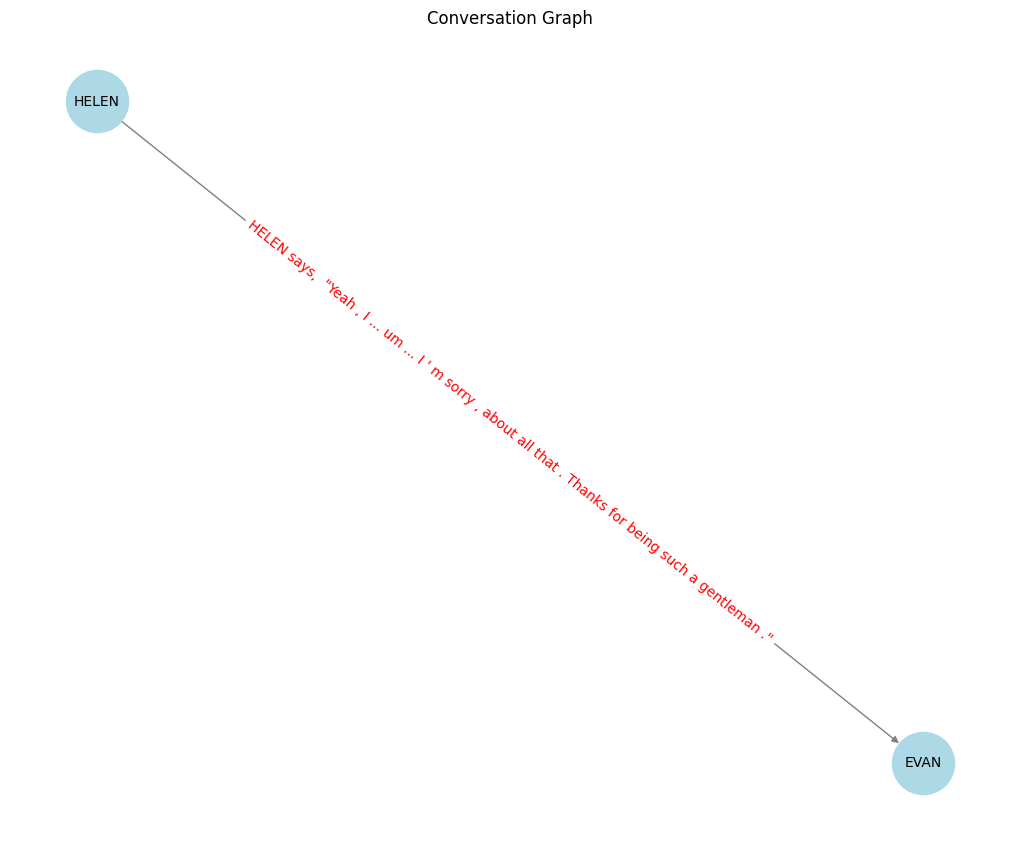


Cluster 12:
Nodes: ['SETH', 'HELEN']
Edges: [('SETH', 'HELEN', {'line': 'SETH says,  "You look good with a black eye ."', 'temporal_idx': 36})]


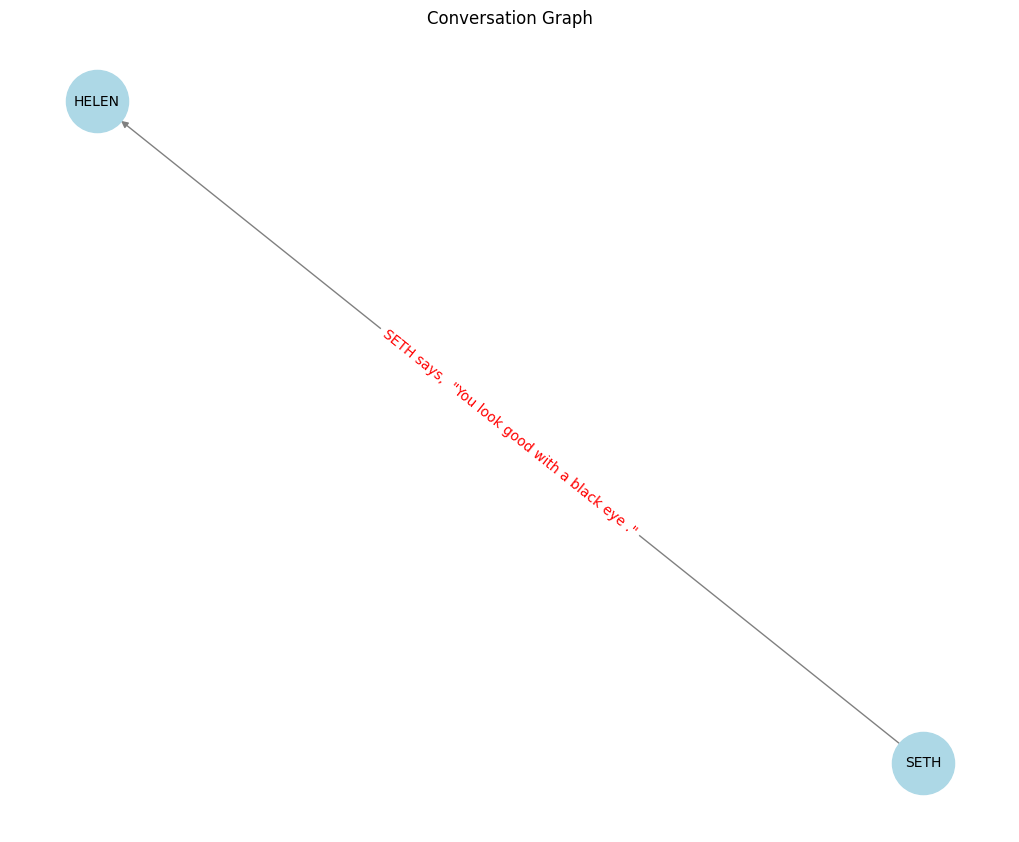


Cluster 13:
Nodes: ['JULES', 'SETH', 'HELEN', 'EVAN']
Edges: [('JULES', 'SETH', {'line': 'JULES says,  "Thanks , smart guy . That \' s why I \' m here . I have to go to Macy \' s to get a shitload of cover - up for the grad photo ."', 'temporal_idx': 38}), ('JULES', 'SETH', {'line': 'JULES says,  "So , you gon na come with me to Macy \' s and buy me my cover - up , or what ?"', 'temporal_idx': 42}), ('JULES', 'SETH', {'line': 'JULES says,  "I \' ve got my dad \' s car . I \' ll take you home , and Evan can give Helen a lift ."', 'temporal_idx': 46}), ('SETH', 'JULES', {'line': 'SETH says,  "Oh man ..."', 'temporal_idx': 39}), ('SETH', 'JULES', {'line': 'SETH says,  "Yes ! Definitely . I \' d love to . I had such bad acne last year , I became an expert on the stuff ."', 'temporal_idx': 43}), ('SETH', 'JULES', {'line': 'SETH says,  "Yeah , but wait ... you drove me here , Evan drove me here , how do we -"', 'temporal_idx': 45}), ('HELEN', 'JULES', {'line': 'HELEN says,  "Yeah , and I \'

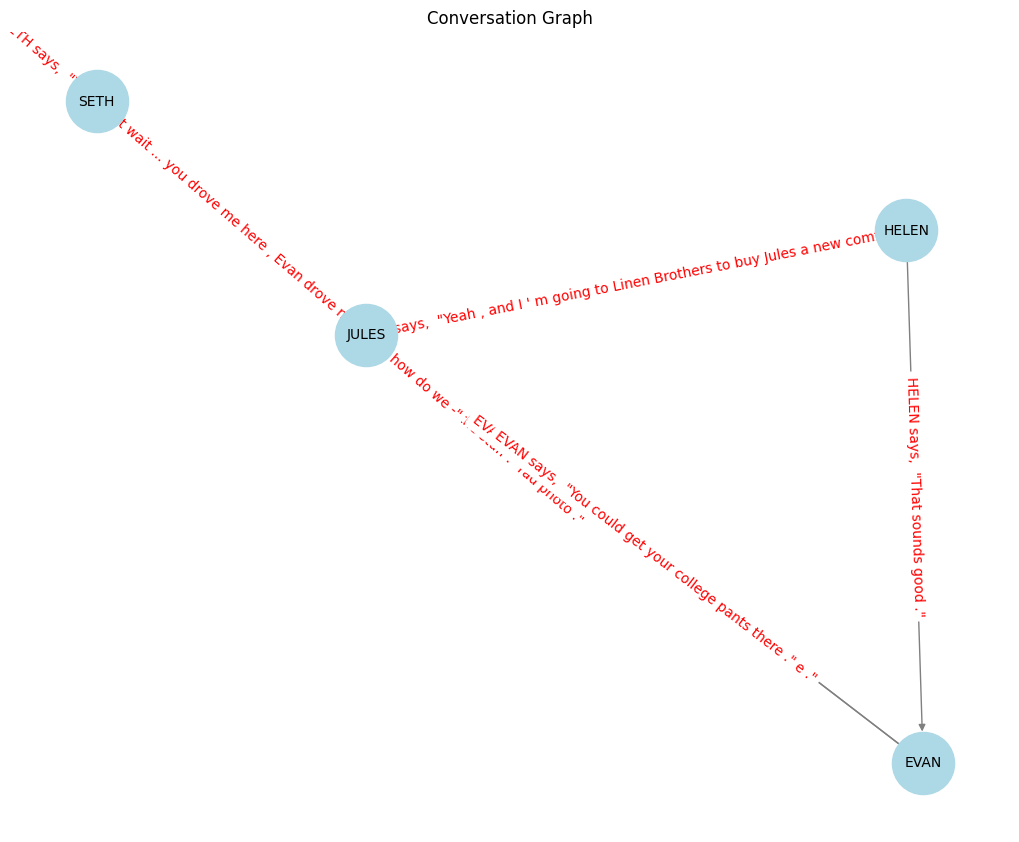


Cluster 14:
Nodes: ['EVAN', 'HELEN']
Edges: [('EVAN', 'HELEN', {'line': 'EVAN says,  "Maybe we can go eat after ?"', 'temporal_idx': 49}), ('HELEN', 'EVAN', {'line': 'HELEN says,  "Sweet ."', 'temporal_idx': 50})]


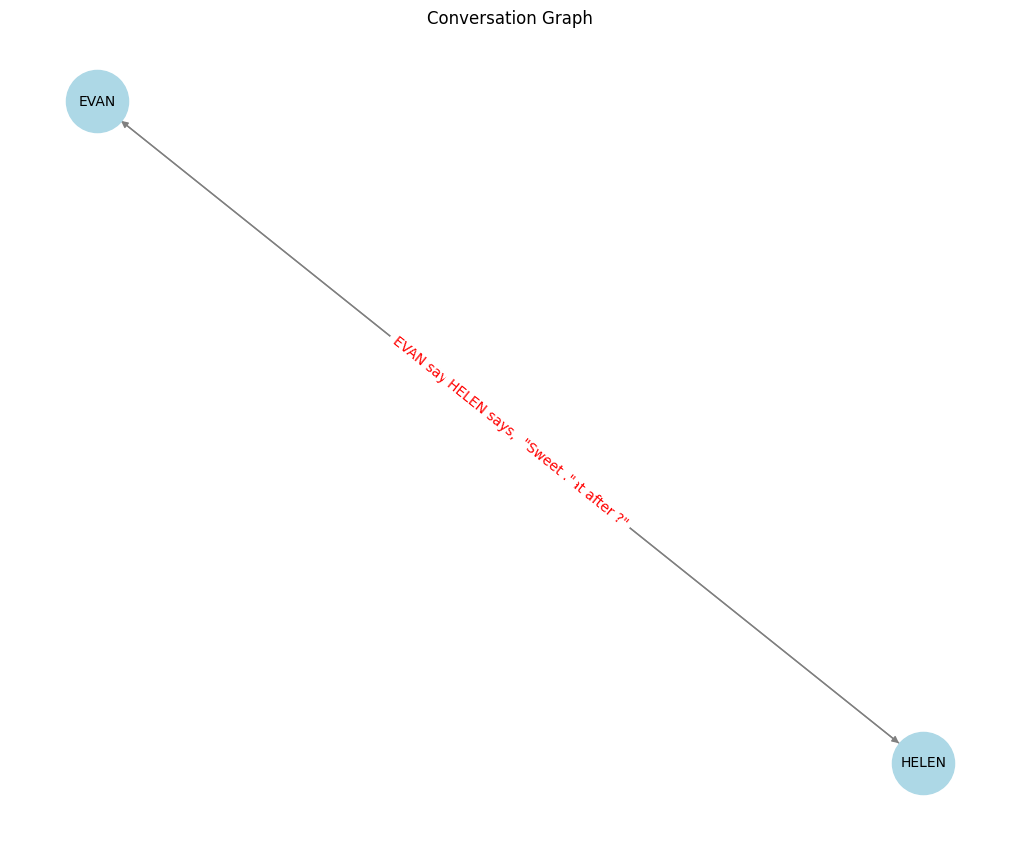


Cluster 15:
Nodes: ['SETH', 'EVAN', 'JULES']
Edges: [('SETH', 'EVAN', {'line': 'SETH says,  "So , uh , I \' ll call you later ."', 'temporal_idx': 52}), ('EVAN', 'SETH', {'line': 'EVAN says,  "Yeah man , have a good one ."', 'temporal_idx': 53}), ('JULES', 'SETH', {'line': 'JULES says,  "Come on , Seth . Let \' s go ."', 'temporal_idx': 54})]


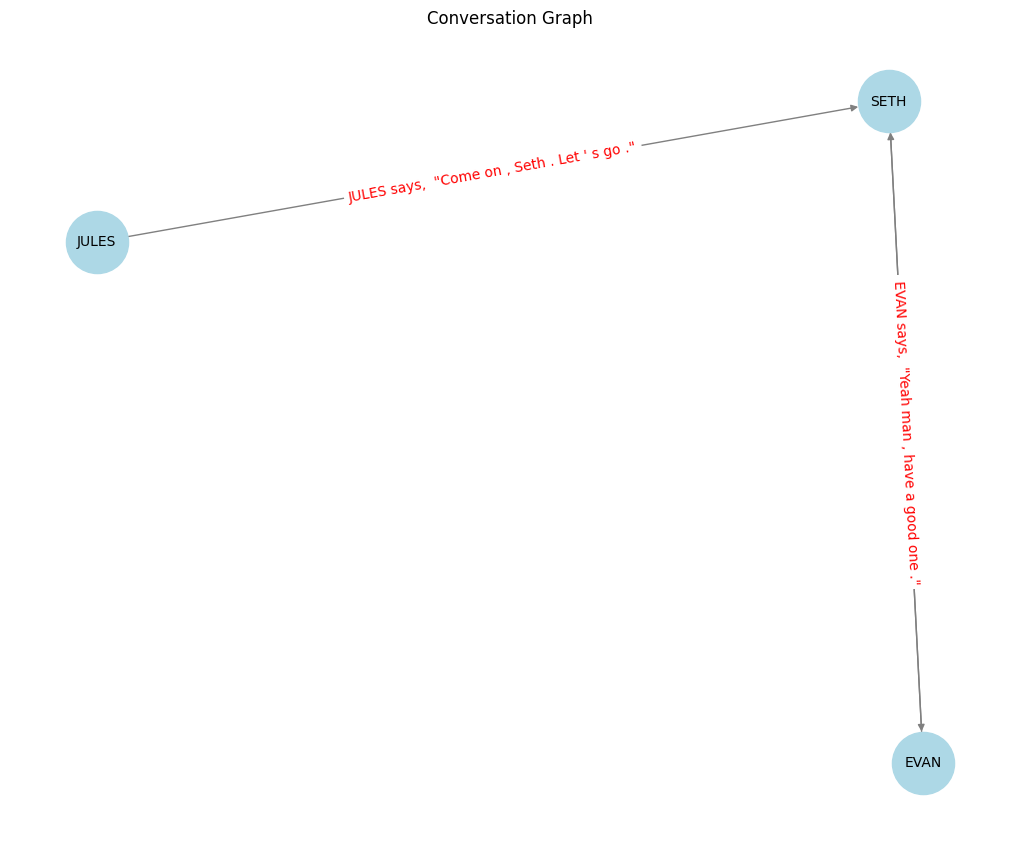

In [211]:
# Build the graph from preprocessed_scene and conversational_targets
conversation_graph = build_directed_graph_with_temporal_aspect(preprocessed_scene, conversational_targets)

# Cluster conversations
conversation_clusters = cluster_conversations(conversation_graph, temporal_threshold=1)

# Print and visualize the clusters
for i, cluster in enumerate(conversation_clusters, 1):
    print(f"\nCluster {i}:")
    print(f"Nodes: {list(cluster.nodes())}")
    print(f"Edges: {list(cluster.edges(data=True))}")
    visualize_graph(cluster)  # Visualize each cluster

In [212]:
conversation_graph.edges(data='True')

OutMultiEdgeDataView([('HELEN', 'JULES', None), ('HELEN', 'JULES', None), ('HELEN', 'EVAN', None), ('HELEN', 'EVAN', None), ('HELEN', 'EVAN', None), ('HELEN', 'EVAN', None), ('HELEN', 'EVAN', None), ('HELEN', 'EVAN', None), ('HELEN', 'SETH', None), ('HELEN', 'SETH', None), ('JULES', 'HELEN', None), ('JULES', 'EVAN', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('JULES', 'SETH', None), ('EVAN', 'SETH', None), ('EVAN', 'SETH', None), ('EVAN', 'SETH', None), ('EVAN', 'HELEN', None), ('EVAN', 'HELEN', None), ('EVAN', 'HELEN', None), ('EVAN', 'HELEN', None), ('EVAN', 'HELEN', None), ('EVAN', 'HELEN', None), ('EVAN', 'JULES', None), ('EVAN', 'JULES', None), ('SETH', 'EVAN', None), ('SETH', 'EVAN', None), ('SETH', 'EVAN', None), ('SETH', 'HELEN', None), ('SETH', 'HELEN', None), ('SETH', 'HELEN', None), ('SETH', 'HELEN', None), ('SETH', 'JULES', None), ('SETH', 'JULES', None), ('SETH

In [172]:
def visualize_all_subgraphs(subgraphs):
    """
    Visualize all subgraphs on a single plot.

    Args:
        subgraphs (list of networkx.DiGraph): List of directed subgraphs to visualize.
    """
    plt.figure(figsize=(15, 10))
    pos_dict = {}
    color_map = plt.cm.get_cmap("tab20")  # Use a colormap for distinct subgraphs
    
    # Iterate through each subgraph
    for idx, subgraph in enumerate(subgraphs):
        pos = nx.spring_layout(subgraph, seed=idx)  # Generate positions for each subgraph
        pos_dict.update(pos)  # Add to a global position dictionary
        
        # Draw nodes and edges
        nx.draw_networkx_nodes(
            subgraph, pos, node_size=2000, node_color=[color_map(idx % 20)], label=f"Subgraph {idx + 1}"
        )
        nx.draw_networkx_edges(subgraph, pos, edge_color="gray")
        nx.draw_networkx_labels(subgraph, pos, font_size=10)
        
        # Add edge labels
        edge_labels = nx.get_edge_attributes(subgraph, "line")
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color="red")
    
    # Add a legend and finalize the plot
    plt.title("All Conversation Subgraphs")
    plt.legend(loc="upper left", fontsize=10)
    plt.axis("off")
    plt.show()

In [202]:
# Visualize all subgraphs
visualize_all_subgraphs(conversation_subgraphs)

AttributeError: 'list' object has no attribute 'is_directed'

In [174]:
for idx, subgraph in enumerate(conversation_subgraphs, 1):
    print(f"Subgraph {idx}:")
    print("Nodes:", subgraph.nodes)
    print("Edges:", list(subgraph.edges(data=True)))

Subgraph 1:
Nodes: ['JULES', 'HELEN']
Edges: [('JULES', 'HELEN', {'line': 'JULES says,  "I feel sorry that I \' m making you buy me a new one ."', 'temporal_idx': 2})]
Subgraph 2:
Nodes: ['HELEN JULES', 'EVAN', 'EVAN SETH', 'HELEN']
Edges: [('HELEN JULES', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14}), ('EVAN SETH', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15})]
Subgraph 3:
Nodes: ['HELEN', 'SETH']
Edges: [('HELEN', 'SETH', {'line': 'HELEN says,  "I didn \' t puke on you , did I ?"', 'temporal_idx': 29})]
Subgraph 4:
Nodes: ['SETH', 'HELEN', 'JULES', 'EVAN']
Edges: [('SETH', 'HELEN', {'line': 'SETH says,  "You look good with a black eye ."', 'temporal_idx': 36}), ('SETH', 'JULES', {'line': 'SETH says,  "Yeah , but wait ... you drove me here , Evan drove me here , how do we -"', 'temporal_idx': 45}), ('SETH', 'EVAN', {'line': 'SETH says,  "So , uh , I \' ll call you later ."', 'temporal

In [181]:
# Assuming `conversation_subgraphs` is a list of subgraphs from segment_graph_temporally
edges_list = []

for idx, subgraph in enumerate(conversation_subgraphs):
    print(f"Subgraph {idx + 1}:")
    for edge in subgraph.edges(data=True):
        edges_list.append(edge)
        print(edge)  # Print each edge with data for debugging

# Optional: Sort the edges list by temporal index (if needed)
edges_list_sorted = sorted(edges_list, key=lambda x: x[2]["temporal_idx"])

print("\nEdges in order (sorted by temporal index):")
for edge in edges_list_sorted:
    print(edge)

Subgraph 1:
('JULES', 'HELEN', {'line': 'JULES says,  "I feel sorry that I \' m making you buy me a new one ."', 'temporal_idx': 2})
Subgraph 2:
('HELEN JULES', 'EVAN', {'line': 'HELEN JULES says,  "Hi Evan , Seth . Hey guys ."', 'temporal_idx': 14})
('EVAN SETH', 'HELEN', {'line': 'EVAN SETH says,  "Hi Helen , Hi Jules . Jules . Helen . Hi ."', 'temporal_idx': 15})
Subgraph 3:
('HELEN', 'SETH', {'line': 'HELEN says,  "I didn \' t puke on you , did I ?"', 'temporal_idx': 29})
Subgraph 4:
('SETH', 'HELEN', {'line': 'SETH says,  "You look good with a black eye ."', 'temporal_idx': 36})
('SETH', 'JULES', {'line': 'SETH says,  "Yeah , but wait ... you drove me here , Evan drove me here , how do we -"', 'temporal_idx': 45})
('SETH', 'EVAN', {'line': 'SETH says,  "So , uh , I \' ll call you later ."', 'temporal_idx': 52})
('HELEN', 'JULES', {'line': 'HELEN says,  "Yeah , and I \' m going to Linen Brothers to buy Jules a new comforter ."', 'temporal_idx': 40})
('HELEN', 'EVAN', {'line': 'HELE

In [170]:
from networkx.algorithms.community import louvain_communities

def cluster_graph(graph):
    communities = louvain_communities(graph)
    clusters = {idx: list(community) for idx, community in enumerate(communities)}
    return clusters

clusters = cluster_graph(conversation_subgraphs)
print("Clusters:", clusters)

AttributeError: 'list' object has no attribute 'nodes'

In [240]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def create_edge_embeddings_with_features(graph):
    """
    Generate embeddings for graph edges with additional features, excluding narration edges.

    Args:
        graph (networkx.MultiDiGraph): The graph.

    Returns:
        dict: Edge-to-embedding mapping for non-narration edges.
    """
    edge_embeddings = {}
    sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]["temporal_idx"])

    for idx, (u, v, attrs) in enumerate(sorted_edges):
        # Exclude edges involving narration nodes
        if "Narration" in u or "Narration" in v:
            continue
        
        # Extract temporal index and current line information
        temporal_idx = attrs["temporal_idx"]

        # Determine previous and next edges
        prev_edge = sorted_edges[idx - 1] if idx > 0 else None
        next_edge = sorted_edges[idx + 1] if idx < len(sorted_edges) - 1 else None

        # Feature: Is the speaker the recipient in the previous or next line?
        speaker_in_prev_recipient = bool(prev_edge and prev_edge[1] == u)
        speaker_in_next_recipient = bool(next_edge and next_edge[1] == u)

        # Feature: Is the recipient the speaker in the previous or next line?
        recipient_in_prev_speaker = bool(prev_edge and prev_edge[0] == v)
        recipient_in_next_speaker = bool(next_edge and next_edge[0] == v)

        # Create embedding using node and edge attributes + features
        embedding = [
            hash(u),                              # Hash for the source node
            hash(v),                              # Hash for the target node
            temporal_idx,                         # Temporal index
            int(speaker_in_prev_recipient),       # Feature: Speaker matches previous recipient
            # int(speaker_in_next_recipient),       # Feature: Speaker matches next recipient
            int(recipient_in_prev_speaker),       # Feature: Recipient matches previous speaker
            # int(recipient_in_next_speaker),       # Feature: Recipient matches next speaker
        ]
        edge_embeddings[(u, v, temporal_idx)] = np.array(embedding)

    return edge_embeddings

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def cluster_edges_dynamic(edge_embeddings, eps=0.5, min_samples=2):
    """
    Perform dynamic clustering of edge embeddings using DBSCAN.

    Args:
        edge_embeddings (dict): Edge-to-embedding mapping.
        eps (float): Maximum distance between two points to be considered neighbors.
        min_samples (int): Minimum number of points required to form a cluster.

    Returns:
        dict: Mapping of edges to cluster labels.
    """
    # Extract embeddings as a matrix
    embeddings = np.array(list(edge_embeddings.values()))

    # Standardize features
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
    cluster_labels = dbscan.fit_predict(embeddings_scaled)

    # Map edges to cluster labels
    edges = list(edge_embeddings.keys())
    edge_clusters = {edges[i]: cluster_labels[i] for i in range(len(edges))}

    return edge_clusters

def refine_edge_clusters(edge_clusters, temporal_threshold=2):
    """
    Refine edge clusters by considering temporal continuity.

    Args:
        edge_clusters (dict): Original edge-to-cluster mapping.
        temporal_threshold (int): Maximum allowable temporal gap within a cluster.

    Returns:
        dict: Updated edge-to-cluster mapping.
    """
    refined_clusters = {}
    cluster_id_counter = max(edge_clusters.values()) + 1
    seen_clusters = {}

    for edge, cluster in sorted(edge_clusters.items(), key=lambda x: x[1]):
        if cluster == -1:
            # Skip unclustered edges
            refined_clusters[edge] = -1
            continue

        u, v, temporal_idx = edge
        if cluster not in seen_clusters:
            seen_clusters[cluster] = {"last_temporal_idx": temporal_idx, "current_cluster": cluster}

        cluster_data = seen_clusters[cluster]
        last_temporal_idx = cluster_data["last_temporal_idx"]

        if abs(temporal_idx - last_temporal_idx) > temporal_threshold:
            # If temporal gap is too large, assign a new cluster ID
            cluster_data["current_cluster"] = cluster_id_counter
            cluster_id_counter += 1

        # Update cluster assignment
        refined_clusters[edge] = cluster_data["current_cluster"]
        cluster_data["last_temporal_idx"] = temporal_idx

    return refined_clusters

def visualize_edge_clusters_no_narration(graph, edge_clusters):
    """
    Visualize the graph with edge clusters, excluding narration nodes and edges.

    Args:
        graph (networkx.MultiDiGraph): The directed graph.
        edge_clusters (dict): Mapping of edges to cluster labels.
    """
    plt.figure(figsize=(12, 10))
    
    # Filter out narration nodes
    filtered_graph = graph.copy()
    narration_nodes = [node for node, attr in graph.nodes(data=True) if attr.get("type") == "narration"]
    filtered_graph.remove_nodes_from(narration_nodes)
    
    # Get positions for filtered graph
    pos = nx.spring_layout(filtered_graph)
    
    # Assign edge colors based on clusters
    unique_clusters = set(edge_clusters.values())
    cluster_colors = {cluster: idx for idx, cluster in enumerate(unique_clusters)}
    edge_colors = [
        cluster_colors.get(edge_clusters.get((u, v), -1), -1) for u, v in filtered_graph.edges()
    ]
    
    # Draw the filtered graph
    nx.draw(filtered_graph, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10)
    nx.draw_networkx_edges(
        filtered_graph, pos, edge_color=edge_colors, edge_cmap=plt.cm.rainbow, width=2
    )
    
    plt.title("Dynamic Edge Clusters (Excluding Narration Nodes)")
    plt.show()


Graph Construction Completed.
Number of Nodes: 20
Number of Edges: 42


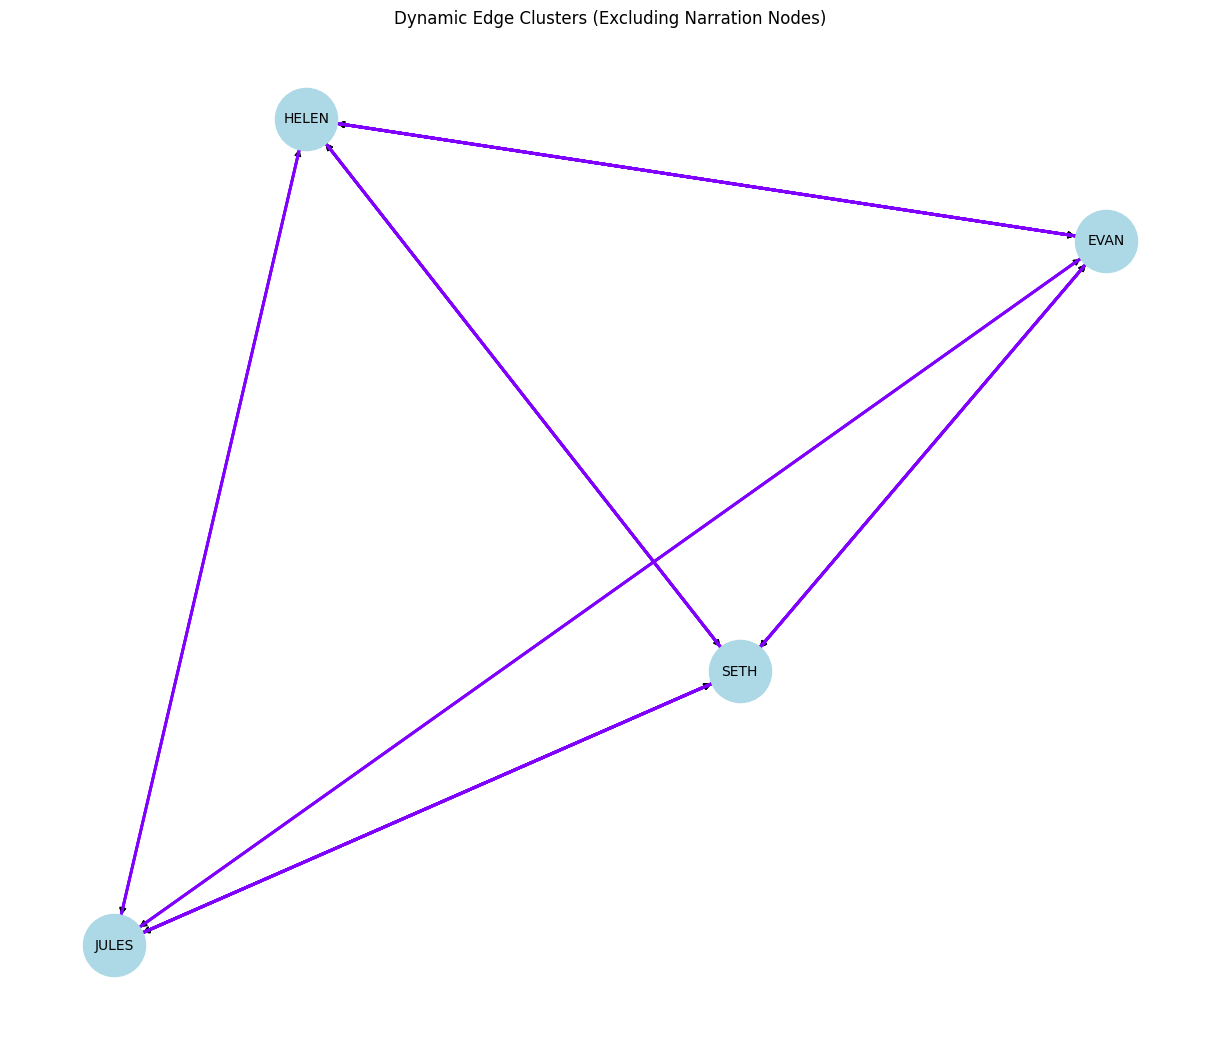

In [241]:
# Step 1: Build Graph
graph = build_directed_graph_with_temporal_aspect(preprocessed_scene, conversational_targets)

# Step 2: Generate Edge Embeddings
edge_embeddings = create_edge_embeddings_with_features(graph)

# Step 3: Perform Dynamic Clustering
edge_clusters = cluster_edges_dynamic(edge_embeddings, eps=0.7, min_samples=2)

refined_edge_clusters = refine_edge_clusters(edge_clusters, temporal_threshold=2)

# Step 4: Visualize Dynamic Clusters
visualize_edge_clusters_no_narration(graph, refined_edge_clusters)

In [242]:
refined_edge_clusters

{('HELEN', 'JULES', 1): -1,
 ('JULES', 'HELEN', 2): -1,
 ('HELEN', 'EVAN', 3): -1,
 ('EVAN', 'SETH', 5): -1,
 ('JULES', 'EVAN', 14): -1,
 ('SETH', 'HELEN', 15): -1,
 ('JULES', 'SETH', 25): -1,
 ('HELEN', 'SETH', 26): -1,
 ('SETH', 'HELEN', 27): -1,
 ('HELEN', 'SETH', 29): -1,
 ('EVAN', 'HELEN', 31): -1,
 ('SETH', 'HELEN', 32): -1,
 ('HELEN', 'EVAN', 34): -1,
 ('SETH', 'HELEN', 36): -1,
 ('JULES', 'SETH', 38): -1,
 ('JULES', 'SETH', 42): -1,
 ('EVAN', 'HELEN', 49): -1,
 ('HELEN', 'EVAN', 50): -1,
 ('JULES', 'SETH', 54): -1,
 ('SETH', 'EVAN', 7): 0,
 ('SETH', 'EVAN', 11): 11,
 ('EVAN', 'SETH', 9): 1,
 ('JULES', 'SETH', 19): 12,
 ('JULES', 'SETH', 23): 13,
 ('EVAN', 'HELEN', 12): 2,
 ('EVAN', 'HELEN', 15): 14,
 ('HELEN', 'EVAN', 14): 3,
 ('HELEN', 'EVAN', 21): 15,
 ('SETH', 'JULES', 17): 4,
 ('SETH', 'JULES', 22): 16,
 ('EVAN', 'HELEN', 20): 5,
 ('EVAN', 'HELEN', 24): 17,
 ('SETH', 'JULES', 39): 6,
 ('SETH', 'JULES', 43): 18,
 ('HELEN', 'JULES', 40): 7,
 ('HELEN', 'EVAN', 47): 19,
 ('EVAN

In [224]:
edge_clusters

{('HELEN', 'JULES'): 0,
 ('HELEN', 'EVAN'): 0,
 ('HELEN', 'SETH'): -1,
 ('JULES', 'HELEN'): -1,
 ('JULES', 'EVAN'): -1,
 ('JULES', 'SETH'): 1,
 ('EVAN', 'SETH'): 1,
 ('EVAN', 'HELEN'): -1,
 ('EVAN', 'JULES'): -1,
 ('SETH', 'EVAN'): 2,
 ('SETH', 'HELEN'): -1,
 ('SETH', 'JULES'): 2}

In [261]:
from transformers import AutoTokenizer

# Pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def tokenize_dialogue_lines(dialogue_lines):
    """
    Tokenize dialogue lines and keep track of token indices.

    Args:
        dialogue_lines (list): List of dialogue lines.

    Returns:
        list: List of tokenized words.
        list: Metadata to reconstruct original lines.
    """
    tokens = []
    metadata = []  # Store (line_index, token_index_in_line) for each token

    for line_index, line in enumerate(dialogue_lines):
        line_tokens = tokenizer.tokenize(line)
        for token_index, token in enumerate(line_tokens):
            tokens.append(token)
            metadata.append({"line_index": line_index, "token_index": token_index})
    
    return tokens, metadata


tokens, metadata = tokenize_dialogue_lines(preprocessed_scene)

In [262]:
tokens

['this',
 'happens',
 'in',
 'the',
 'scene',
 ':',
 '"',
 '150',
 '150',
 'they',
 'walk',
 'through',
 'the',
 'department',
 'store',
 ',',
 'when',
 'suddenly',
 ',',
 'evan',
 'sees',
 'helen',
 'and',
 'jules',
 'looking',
 'at',
 'comfort',
 '##ers',
 '.',
 'angle',
 'on',
 ':',
 'helen',
 'and',
 'jules',
 '(',
 'continued',
 ')',
 '150',
 'continued',
 ':',
 '150',
 '"',
 'helen',
 'says',
 ',',
 '"',
 'again',
 ',',
 'i',
 "'",
 'm',
 'so',
 'sorry',
 '.',
 'i',
 'can',
 "'",
 't',
 'believe',
 'i',
 'actually',
 'did',
 'that',
 '.',
 '"',
 'jules',
 'says',
 ',',
 '"',
 'i',
 'feel',
 'sorry',
 'that',
 'i',
 "'",
 'm',
 'making',
 'you',
 'buy',
 'me',
 'a',
 'new',
 'one',
 '.',
 '"',
 'helen',
 'says',
 ',',
 '"',
 'i',
 'have',
 'to',
 '.',
 'it',
 "'",
 's',
 'pu',
 '##ke',
 '.',
 '"',
 'this',
 'happens',
 'in',
 'the',
 'scene',
 ':',
 '"',
 'angle',
 'on',
 ':',
 'seth',
 'and',
 'evan',
 '"',
 'evan',
 'says',
 ',',
 '"',
 'holy',
 'shit',
 '!',
 '"',
 'this',
 'ha

In [270]:
from sklearn.cluster import DBSCAN

def cluster_tokens(embeddings, metadata, eps=0.5, min_samples=2):
    """
    Cluster tokens using embeddings and metadata.

    Args:
        embeddings (np.array): Token embeddings.
        metadata (list): Metadata for reconstructing lines.
        eps (float): DBSCAN parameter.
        min_samples (int): DBSCAN parameter.

    Returns:
        list: Cluster labels for each token.
    """
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    cluster_labels = clustering.fit_predict(embeddings)
    
    # Map clusters to original lines
    line_clusters = {}
    for token_idx, cluster in enumerate(cluster_labels):
        line_index = metadata[token_idx]["line_index"]
        if cluster not in line_clusters:
            line_clusters[cluster] = []
        line_clusters[cluster].append(line_index)
    
    return line_clusters

# Example clustering (embedding per token required)
token_embeddings = model.encode(tokens)  # Generate token-level embeddings
line_clusters = cluster_tokens(token_embeddings, metadata)
print("Line Clusters:")
print(line_clusters)

Line Clusters:
{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,

In [272]:
line_clusters.keys()

dict_keys([0, 1, 2, 3, 4, -1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [271]:
def reconstruct_lines_with_clusters(tokens, metadata, line_clusters):
    """
    Reconstruct lines from token clusters and assign cluster labels to lines.

    Args:
        tokens (list): List of tokenized words.
        metadata (list): Metadata for each token with line_index and token_index.
        line_clusters (dict): Mapping of cluster labels to token indices.

    Returns:
        dict: Mapping of line indices to their cluster labels and reconstructed text.
    """
    # Initialize a dictionary to hold line clusters and their reconstructed text
    line_to_cluster = {}

    # Iterate over the clusters
    for cluster_label, token_indices in line_clusters.items():
        # Group tokens by their original line index
        line_token_map = {}
        for token_idx in token_indices:
            line_index = metadata[token_idx]["line_index"]
            if line_index not in line_token_map:
                line_token_map[line_index] = []
            line_token_map[line_index].append(tokens[token_idx])

        # Reconstruct lines for this cluster
        for line_index, line_tokens in line_token_map.items():
            reconstructed_line = tokenizer.convert_tokens_to_string(line_tokens)
            line_to_cluster[line_index] = {
                "cluster": cluster_label,
                "text": reconstructed_line,
            }

    return line_to_cluster

# Reconstruct lines with clusters
lines_with_clusters = reconstruct_lines_with_clusters(tokens, metadata, line_clusters)

# Output results
for line_idx, data in lines_with_clusters.items():
    print(f"Line {line_idx} (Cluster {data['cluster']}): {data['text']}")

Line 0 (Cluster 25): 150
Line 1 (Cluster 25): says


In [254]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

def cluster_dialogue_lines(embeddings, eps=0.5, min_samples=2):
    """
    Cluster dialogue lines using DBSCAN.

    Args:
        embeddings (np.array): Sentence embeddings for dialogue lines.
        eps (float): Maximum distance for DBSCAN clustering.
        min_samples (int): Minimum samples per cluster.

    Returns:
        list: Cluster labels for each dialogue line.
    """
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    cluster_labels = clustering.fit_predict(1 - cosine_similarity(embeddings))
    return cluster_labels

# Perform clustering
cluster_labels = cluster_dialogue_lines(embeddings)

In [255]:
def map_clusters_to_dialogues(dialogue_lines, metadata, cluster_labels):
    """
    Map cluster labels back to original dialogue lines and metadata.
    
    Args:
        dialogue_lines (list): Dialogue lines.
        metadata (list): Metadata for each dialogue line.
        cluster_labels (list): Cluster labels from clustering algorithm.
    
    Returns:
        dict: Mapping of cluster ID to dialogue lines and metadata.
    """
    clusters = {}
    for line, meta, label in zip(dialogue_lines, metadata, cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append({"line": line, "metadata": meta})
    return clusters

# Map clusters
clusters = map_clusters_to_dialogues(dialogue_lines, metadata, cluster_labels)

# Display results
for cluster_id, cluster_lines in clusters.items():
    print(f"\nCluster {cluster_id}:")
    for entry in cluster_lines:
        print(f"Speaker: {entry['metadata']['speaker']}, Line: {entry['line']}")


Cluster 0:
Speaker: HELEN, Line: "Again , I ' m so sorry . I can ' t believe I actually did that ."
Speaker: JULES, Line: "I feel sorry that I ' m making you buy me a new one ."
Speaker: HELEN, Line: "I have to . It ' s puke ."
Speaker: EVAN, Line: "Holy shit !"
Speaker: SETH, Line: "Is that them ?"
Speaker: EVAN, Line: "Should we hide ?"
Speaker: SETH, Line: "Fuck that , man . I can ' t talk to her , look what I did to her !"
Speaker: EVAN, Line: "Helen called me a pussy to my face ! What am I going to say to her ?"
Speaker: HELEN JULES, Line: "Hi Evan , Seth . Hey guys ."
Speaker: EVAN SETH, Line: "Hi Helen , Hi Jules . Jules . Helen . Hi ."
Speaker: SETH, Line: "Oh my god . I ' m so sorry , Jules ."
Speaker: JULES, Line: "It ' s okay ."
Speaker: EVAN, Line: "How are you feeling ?"
Speaker: HELEN, Line: "Not bad , but not great , how about you ?"
Speaker: SETH, Line: "That looks terrible . No ! I mean , it doesn ' t look terrible , it looks -"
Speaker: JULES, Line: "Don ' t worry ab

In [273]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load BERT uncased model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name)

def compute_sentence_embedding(sentences, temporal_indices, sentiment_scores):
    """
    Compute sentence embeddings using BERT CLS token with additional features.

    Args:
        sentences (list): List of sentences.
        temporal_indices (list): Temporal index for each sentence.
        sentiment_scores (list): Sentiment score for each sentence.

    Returns:
        np.ndarray: Array of embeddings augmented with sentiment and temporal features.
    """
    sentence_embeddings = []

    for idx, sentence in enumerate(sentences):
        # Tokenize the sentence and get input tensors
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Forward pass through the BERT model
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # CLS token

        # Augment CLS embedding with temporal index and sentiment score
        embedding = torch.cat([
            cls_embedding, 
            torch.tensor([temporal_indices[idx]], dtype=torch.float32),
            torch.tensor([sentiment_scores[idx]], dtype=torch.float32)
        ])
        sentence_embeddings.append(embedding.numpy())

    return np.array(sentence_embeddings)

def cluster_sentences(embeddings, eps=0.7, min_samples=2):
    """
    Perform clustering on sentence embeddings.

    Args:
        embeddings (np.ndarray): Sentence embeddings.
        eps (float): DBSCAN epsilon parameter.
        min_samples (int): DBSCAN minimum samples parameter.

    Returns:
        dict: Mapping of sentence indices to cluster labels.
    """
    # Scale embeddings for DBSCAN
    scaled_embeddings = StandardScaler().fit_transform(embeddings)

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(scaled_embeddings)

    # Map sentence indices to cluster labels
    clusters = {idx: label for idx, label in enumerate(db.labels_)}
    return clusters

# Example Sentences
sentences = [
    "I can't believe this happened.",
    "Me neither, it's just unbelievable.",
    "What should we do now?",
    "Look, Helen is coming over.",
    "Hey Helen, how's it going?",
    "It's been a crazy day for all of us."
]
temporal_indices = list(range(len(sentences)))  # Assign temporal indices
sentiment_scores = [0.5, 0.6, 0.4, 0.7, 0.8, 0.9]  # Dummy sentiment scores

# Step 1: Compute Sentence Embeddings
embeddings = compute_sentence_embedding(sentences, temporal_indices, sentiment_scores)

# Step 2: Cluster Sentences
clusters = cluster_sentences(embeddings, eps=1.5, min_samples=2)

# Step 3: Display Clusters
for sentence_idx, cluster_label in clusters.items():
    print(f"Sentence: {sentences[sentence_idx]} -> Cluster: {cluster_label}")

Sentence: I can't believe this happened. -> Cluster: -1
Sentence: Me neither, it's just unbelievable. -> Cluster: -1
Sentence: What should we do now? -> Cluster: -1
Sentence: Look, Helen is coming over. -> Cluster: -1
Sentence: Hey Helen, how's it going? -> Cluster: -1
Sentence: It's been a crazy day for all of us. -> Cluster: -1


In [114]:
token_lengths

[53,
 27,
 24,
 19,
 17,
 12,
 23,
 13,
 18,
 13,
 42,
 29,
 28,
 16,
 19,
 24,
 14,
 21,
 23,
 14,
 14,
 21,
 28,
 23,
 16,
 15,
 17,
 28,
 13,
 22,
 13,
 21,
 34,
 23,
 31,
 16,
 16,
 15,
 45,
 11,
 30,
 23,
 33,
 34,
 16,
 28,
 34,
 13,
 23,
 16,
 11,
 32,
 19,
 16,
 19,
 85]

In [135]:
from openai import OpenAI
import json
import logging

# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


# Set the OpenAI API key
client = OpenAI(
    api_key='KEY'
)

def analyze_speaker_relationship(scene_line, previous_lines, current_speaker, candidates):
    """
    Analyze whether the current speaker is addressing the previous speaker
    or another candidate in the context of a scene.

    Args:
        scene_line (str): The current line in the scene.
        previous_lines (str): Context from previous lines in the scene.
        current_speaker (str): The speaker of the current line.
        candidates (list): A list of possible conversation targets.

    Returns:
        str: The name of the identified conversation target.
    """
    prompt = f"""
You are an assistant analyzing conversations in a movie scene. Your goal is to determine
who the current speaker is addressing based on context.

Context:
{previous_lines}

Current Speaker:
{current_speaker}

Current Line:
{scene_line}

Candidates:
{', '.join(candidates)}

Please identify the recipient of the current line based on the context. Format your response as JSON:
{{
  "recipient": "Name of the person being addressed (or NONE if unclear)"
}}
"""

    try:
        # Send prompt to OpenAI API
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an expert in analyzing conversational context in scripts."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0,
        )
        content = response.choices[0].message.content

        # Log the raw response
        logger.info(f"Raw line: {scene_line}")
        logger.info(f"Raw response: {content}")

        # Parse the JSON response
        content = content.strip()
        if content.startswith("```json"):
            content = content[7:-3].strip()
        result = json.loads(content)

        recipient = result
        return recipient
    except Exception as e:
        logger.error(f"Error analyzing speaker relationship: {e}")
        return "NONE"

In [244]:
# Process the scene line by line
def process_scene(scene, candidates):
    results = []
    for idx, line in enumerate(scene):
        if line.startswith("This happens in the scene:"):
            # Skip narration lines
            results.append({"line": line, "recipient": "NONE"})
            continue

        # Extract the current speaker and dialogue
        try:
            current_speaker, scene_line = line.split(" says, ", 1)
        except ValueError:
            logger.error(f"Malformed line: {line}")
            continue

        # Construct previous lines context
        previous_lines = " ".join(scene)

        # Identify recipient using analyze_speaker_relationship
        recipient = analyze_speaker_relationship(scene_line, previous_lines, current_speaker, candidates)
        results.append({"line": line, "recipient": recipient})
    return results

In [245]:
short_scene = preprocess_scene(scene)
short_scene

['HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
 'JULES says,  "I feel sorry that I\'m making you buy me a new one."',
 'HELEN says,  "I have to. It\'s puke."',
 'This happens in the scene: "ANGLE ON: SETH and EVAN"',
 'EVAN says,  "Holy shit!"',
 'SETH says,  "Is that them?"',
 'EVAN says,  "Should we hide?"']

In [246]:
results = []
for idx, line in enumerate(short_scene[:1]):
    if line.startswith("This happens in the scene:"):
        # Skip narration lines
        results.append({"line": line, "recipient": "NONE"})
        continue

    # Extract the current speaker and dialogue
    try:
        current_speaker, scene_line = line.split(" says, ", 1)
    except ValueError:
        logger.error(f"Malformed line: {line}")
        continue

    # Construct previous lines context
    previous_lines = " ".join(short_scene)

    # Identify recipient using analyze_speaker_relationship
    recipient = analyze_speaker_relationship(scene_line, previous_lines, current_speaker, candidates)
    results.append({"line": line, "recipient": recipient})

results

[{'line': 'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."',
  'recipient': {'recipient': 'NONE'}}]

In [137]:
previous_lines

'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that." JULES says,  "I feel sorry that I\'m making you buy me a new one." HELEN says,  "I have to. It\'s puke." This happens in the scene: "ANGLE ON: SETH and EVAN" EVAN says,  "Holy shit!" SETH says,  "Is that them?" EVAN says,  "Should we hide?"'

In [129]:
analyze_speaker_relationship(scene_line, previous_lines, current_speaker, candidates)

'NONE'

In [125]:
results = process_scene(short_scene, candidates)

# Print results
for result in results:
    print(result)

{'line': 'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that."', 'recipient': 'NONE'}
{'line': 'JULES says,  "I feel sorry that I\'m making you buy me a new one."', 'recipient': 'HELEN'}
{'line': 'HELEN says,  "I have to. It\'s puke."', 'recipient': 'JULES'}
{'line': 'This happens in the scene: "ANGLE ON: SETH and EVAN"', 'recipient': 'NONE'}
{'line': 'EVAN says,  "Holy shit!"', 'recipient': 'SETH'}
{'line': 'SETH says,  "Is that them?"', 'recipient': 'Seth'}
{'line': 'EVAN says,  "Should we hide?"', 'recipient': 'SETH'}


In [46]:
previous_lines = preprocessed_scene
current_speaker = 'HELEN'
scene_line = {'line': 'HELEN says,  "I have to. It\'s puke."', 'recipient': 'NONE'}


In [126]:
" ".join(short_scene) if idx > 0 else "NONE"

'HELEN says,  "Again, I\'m so sorry. I can\'t believe I actually did that." JULES says,  "I feel sorry that I\'m making you buy me a new one." HELEN says,  "I have to. It\'s puke." This happens in the scene: "ANGLE ON: SETH and EVAN" EVAN says,  "Holy shit!" SETH says,  "Is that them?" EVAN says,  "Should we hide?"'

In [51]:
prompt = f"""
You are an assistant analyzing conversations in a movie scene. Your goal is to determine
who the current speaker is addressing based on context.

Context:
{previous_lines}

Current Speaker:
{current_speaker}

Current Line:
{scene_line}

Candidates:
{', '.join(candidates)}

Please identify the recipient of the current line based on the context. Format your response as JSON:
{{
  "recipient": "Name of the person being addressed (or NONE if unclear)"
}}
"""

try:
    # Send prompt to OpenAI API
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in analyzing conversational context in scripts."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100,
        temperature=0,
    )
    content = response.choices[0].message.content

    # Log the raw response
    logger.info(f"Raw line: {scene_line}")
    logger.info(f"Raw response: {content}")

    # Parse the JSON response
    content = content.strip()
    if content.startswith("```json"):
        content = content[7:-3].strip()
    result = json.loads(content)

    recipient = result.get("recipient", "NONE")
    print(recipient)
except Exception as e:
    logger.error(f"Error analyzing speaker relationship: {e}")
    print("NONE")

JULES


In [50]:
response['choices']

TypeError: 'ChatCompletion' object is not subscriptable

In [2]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [3]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [4]:
print(dir(corpus))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_collect_speaker_data', '_merge_utterances', '_reinitialize_index_helper', '_update_corpus_speaker_data', '_vector_matrices', 'add_meta', 'add_utterances', 'append_vector_matrix', 'backend', 'backend_mapper', 'config', 'conversations', 'corpus_dirpath', 'delete_metadata', 'delete_vector_matrix', 'directed_pairwise_exchanges', 'dump', 'dump_info', 'dump_vectors', 'filter_conversations_by', 'filter_utterances', 'from_pandas', 'get_attribute_table', 'get_conversation', 'get_conversation_ids', 'get_conversations_dataframe', 'get_full_attribute_table', 'get_meta', 'get_object', 'get_object_ids', 'get_speaker', 'get_speaker_convo_attribute_table', 'get

In [5]:
corpus.get_full_attribute_table

<bound method Corpus.get_full_attribute_table of <convokit.model.corpus.Corpus object at 0x10a24ead0>>

In [316]:
corpus.filename

AttributeError: 'Corpus' object has no attribute 'filename'

In [6]:
import pandas as pd
import numpy as np

# Enhanced utterance extraction
utterance_data = []
for convo_idx, convo in enumerate(corpus.iter_conversations()):
    convo_id = convo.id
    movie_name = convo.meta.get("movie_name", "Unknown")
    movie_id = convo.meta.get("movie_idx", 0)

    # Process each utterance in the conversation
    for i, utt in enumerate(convo.iter_utterances()):
        text = utt.text
        utterance_id = utt.id
        label = 1 if i == 0 else 0  # Start of a conversation
        speaker_id = utt.speaker.id
        speaker_name = utt.speaker.meta.get("character_name", "Unknown")
        line_tag = utt.meta.get("tag", "DIALOGUE")  # Default to "DIALOGUE" if no tag

        utterance_data.append({
            "utterance": text,
            "utterance_id": utterance_id,
            "label": label,
            "conversation_id": convo_id,
            "movie_id": movie_id,
            "movie_name": movie_name,
            "speaker_id": speaker_id,
            "speaker_name": speaker_name,
            "line_tag": line_tag,
        })

# Convert to DataFrame
df = pd.DataFrame(utterance_data)

# Add helper column to check speaker continuity
df["same_speaker_2_lines_ago"] = 0  # Initialize column with default value

# Efficiently compute continuity using shift
df["same_speaker_2_lines_ago"] = (
    (df["speaker_id"] == df["speaker_id"].shift(2)).astype(int)
)

df.head()

,utterance,utterance_id,label,conversation_id,movie_id,movie_name,speaker_id,speaker_name,line_tag,same_speaker_2_lines_ago
0,They do not!,L1045,1,L1044,m0,10 things i hate about you,u0,BIANCA,DIALOGUE,0
1,They do to!,L1044,0,L1044,m0,10 things i hate about you,u2,CAMERON,DIALOGUE,0
2,I hope so.,L985,1,L984,m0,10 things i hate about you,u0,BIANCA,DIALOGUE,1
3,She okay?,L984,0,L984,m0,10 things i hate about you,u2,CAMERON,DIALOGUE,1
4,Let's go.,L925,1,L924,m0,10 things i hate about you,u0,BIANCA,DIALOGUE,1


In [18]:
df[df['movie_name']=='the avengers'].head(20)

,utterance,utterance_id,label,conversation_id,movie_id,movie_name,speaker_id,speaker_name,line_tag,same_speaker_2_lines_ago
10738,No need. I'll call again.,L57766,1,L57755,m23,the avengers,u387,STEED,DIALOGUE,0
10739,The technology is brand new. Soon it will be m...,L57765,0,L57755,m23,the avengers,u378,BAILEY,DIALOGUE,0
10740,There are limits?,L57764,0,L57755,m23,the avengers,u387,STEED,DIALOGUE,1
10741,As real as you wish. Hot or cold. Humid or dry...,L57763,0,L57755,m23,the avengers,u378,BAILEY,DIALOGUE,1
10742,You don't say. How real does it feel?,L57762,0,L57755,m23,the avengers,u387,STEED,DIALOGUE,1
10743,Of course. Natural weather delivered to your d...,L57761,0,L57755,m23,the avengers,u378,BAILEY,DIALOGUE,1
10744,Seriously?,L57760,0,L57755,m23,the avengers,u387,STEED,DIALOGUE,1
10745,"Normally, we'd be eager to oblige --",L57759,0,L57755,m23,the avengers,u378,BAILEY,DIALOGUE,1
10746,Sir August Merryweather? I was looking for som...,L57758,0,L57755,m23,the avengers,u387,STEED,DIALOGUE,1
10747,Really?,L57757,0,L57755,m23,the avengers,u378,BAILEY,DIALOGUE,1


In [19]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Step 1: Data Preprocessing
# Sample DataFrame creation (use your actual `df`)
# Assuming `df` already has the columns: `utterance`, `label`, `same_speaker_2_lines_ago`

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data and extract numerical features
def tokenize_data_with_features(df, feature_column="same_speaker_2_lines_ago", max_len=512):
    """
    Tokenizes utterance + context and extracts numerical features.

    Args:
        df (pd.DataFrame): The input DataFrame containing utterances and features.
        feature_column (str): The column name for additional numerical features.
        max_len (int): Maximum length for tokenized input.

    Returns:
        dict, torch.Tensor: Tokenized input data and additional numerical features.
    """
    utterance_with_context = []

    # Prepare utterance + context
    for i in range(len(df)):
        if i == 0:  # First utterance in the dataset
            context = "Start of conversation"
        else:
            context = df.loc[i - 1, "utterance"]  # Preceding utterance

        current_utterance = df.loc[i, "utterance"]
        input_text = f"[CLS] {context} [SEP] {current_utterance} [SEP]"
        utterance_with_context.append(input_text)

    # Tokenize the utterance + context
    tokenized = tokenizer(
        utterance_with_context,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )

    # Extract numerical feature as a tensor
    additional_features = torch.tensor(df[feature_column].values, dtype=torch.float32)

    return tokenized, additional_features


# Tokenize and extract features
tokenized_inputs, same_speaker_tensor = tokenize_data_with_features(df)
labels = torch.tensor(df["label"].values, dtype=torch.long)

# Step 2: Dataset Class
class ContextualizedDatasetWithFeature(Dataset):
    def __init__(self, encodings, labels, speaker_feature):
        self.encodings = encodings
        self.labels = labels
        self.speaker_feature = speaker_feature

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "speaker_feature": self.speaker_feature[idx],
        }

# Create dataset and dataloader
dataset = ContextualizedDatasetWithFeature(tokenized_inputs, labels, same_speaker_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 3: Custom BERT Model
class BertWithSpeakerFeature(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, output_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)  # Load pre-trained BERT
        
        # Define the classification head with multiple hidden layers
        self.fc1 = nn.Linear(self.bert.config.hidden_size + 1, 512)  # Input size + speaker feature
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100, 50)
        self.out = nn.Linear(50, output_dim)  # Output layer
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, speaker_feature):
        # Forward pass through BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = bert_output.pooler_output  # [CLS] token embedding
        
        # Concatenate speaker feature
        combined = torch.cat((cls_embedding, speaker_feature.unsqueeze(1)), dim=1)

        # Pass through the classification head with multiple hidden layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        output = self.out(x)

        return output

# Step 4: Training the Model
# Initialize model, optimizer, and loss function
# Initialize the model
model = BertWithSpeakerFeature("bert-base-cased", hidden_dim=512, output_dim=2)

# Unfreeze the last layer of the BERT encoder
for param in model.bert.encoder.layer[:-1]:  # Freeze all but the last layer
    for p in param.parameters():
        p.requires_grad = False

# Define optimizer and criterion
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
model.train()
for epoch in range(1):
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()

        # Move batch data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        speaker_feature = batch["speaker_feature"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask, speaker_feature)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")

/var/folders/tv/7ydtp1js41qb0mxn5cql9tkr0000gn/T/ipykernel_77175/426348783.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(self.labels[idx], dtype=torch.long),


IndexError: index out of range in self

### Connect with original DF for Evaluation

In [7]:
import numpy as np
from movie_coref.movie_coref import MovieCoreference
from movie_coref.data import CorefDocument

In [ ]:
829482

In [91]:
import pandas as pd

df = pd.read_csv(r'/Users/alecnaidoo/Downloads/MIDS/DATASCI_266_NLP_with_DL/W266_Project/Table_1_Exploratory_Data_With_Scripts.csv')
df.rename(columns={'0':'imdb_movie_id'}, inplace=True)

In [92]:
df.head()

,imdb_movie_id,script_date,script,bechdel_id,title,release_year,bechdel_rating,language,popularity,vote_average,...,Thriller,War,Comedy,Music,Western,Horror,Science Fiction,Action,Animation,History
0,22958,NaN,GRAND H...,1328,Grand Hotel,1932,3,en,85.188,6.959,...,0,0,0,0,0,0,0,0,0,0
1,32138,March 1939,FADE IN -- Title:\r\n\r\nFor nearly forty year...,174,"Wizard of Oz, The",1939,3,en,81.243,7.600,...,0,0,0,0,0,0,0,0,0,0
2,33467,NaN,Citizen Kane \r\n\r\n ...,1266,Citizen Kane,1941,1,en,331.301,8.008,...,0,0,0,0,0,0,0,0,0,0
3,113101,NaN,"""FOUR ROOMS""\r\n\r\n ...",986,Four rooms,1995,3,en,21.231,5.829,...,0,0,1,0,0,0,0,0,0,0
4,42192,NaN,FADE IN:\r\n\nINT. DINING HALL - SARAH SIDDONS...,139,All About Eve,1950,3,en,18.633,8.100,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df['imdb_movie_id'] = df['imdb_movie_id'].astype(str)

In [94]:
bechd = df[['imdb_movie_id', 'bechdel_rating']].copy()
bechd['binary_bechdel_rating'] = bechd['bechdel_rating'].apply(lambda x: 1 if x == 3 else 0)
bechd['binary_bechdel_rating2'] = bechd['bechdel_rating'].apply(lambda x: 1 if x == 2 else 0)

In [95]:
bechd

,imdb_movie_id,bechdel_rating,binary_bechdel_rating,binary_bechdel_rating2
0,22958,3,1,0
1,32138,3,1,0
2,33467,1,0,0
3,113101,3,1,0
4,42192,3,1,0
...,...,...,...,...
421,6139732,3,1,0
422,837563,3,1,0
423,4566758,3,1,0
424,11245972,3,1,0


In [96]:
scores = scores.merge(bechd, on = 'imdb_movie_id', how='left')

In [86]:
from sklearn.metrics import accuracy_score

# Assuming scores DataFrame is available
y_true = scores['binary_bechdel_rating']
y_pred = scores['score_3']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6996336996336996


In [312]:
from sklearn.metrics import accuracy_score

# Assuming scores DataFrame is available
y_true = scores['binary_bechdel_rating']
y_pred = scores['score_3']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

KeyError: 'binary_bechdel_rating'

In [ ]:
# Identify rows where binary_bechdel_rating does not equal score_3
mismatched_rows = scores[scores['binary_bechdel_rating'] != scores['score_3']]

# Extract the IMDb movie IDs for these rows
mismatched_movie_ids = mismatched_rows['imdb_movie_id'].tolist()

In [100]:
df

,imdb_movie_id,script_date,script,bechdel_id,title,release_year,bechdel_rating,language,popularity,vote_average,...,Thriller,War,Comedy,Music,Western,Horror,Science Fiction,Action,Animation,History
0,22958,NaN,GRAND H...,1328,Grand Hotel,1932,3,en,85.188,6.959,...,0,0,0,0,0,0,0,0,0,0
1,32138,March 1939,FADE IN -- Title:\r\n\r\nFor nearly forty year...,174,"Wizard of Oz, The",1939,3,en,81.243,7.600,...,0,0,0,0,0,0,0,0,0,0
2,33467,NaN,Citizen Kane \r\n\r\n ...,1266,Citizen Kane,1941,1,en,331.301,8.008,...,0,0,0,0,0,0,0,0,0,0
3,113101,NaN,"""FOUR ROOMS""\r\n\r\n ...",986,Four rooms,1995,3,en,21.231,5.829,...,0,0,1,0,0,0,0,0,0,0
4,42192,NaN,FADE IN:\r\n\nINT. DINING HALL - SARAH SIDDONS...,139,All About Eve,1950,3,en,18.633,8.100,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,6139732,December 1992,ALADDIN: THE COMPLETE SCRIPT\r\nCOMPILED BY B...,8750,Aladdin,2019,3,en,189.589,7.107,...,0,0,0,0,0,0,0,0,0,0
422,837563,January 1986,"\t\t\t""PET SEMATARY""\r\n\r\n\t\t\t by\r\n...",8824,Pet Sematary,2019,3,en,191.301,5.739,...,1,0,0,0,0,1,0,0,0,0
423,4566758,December 1998,Disney's Mulan\r\nCompiled by Barry Adams dur...,9265,Mulan,2020,3,en,61.971,6.880,...,0,0,0,0,0,0,0,1,0,0
424,11245972,July 1995,\n SCREAM\r\n ...,10221,Scream,2022,3,en,82.686,6.700,...,1,0,0,0,0,1,0,0,0,0


In [113]:
# Assuming 'title' is the column containing movie titles
for _, row in df.loc[df['imdb_movie_id'].isin(mismatched_movie_ids)].iterrows():
    print(f"Title: {row['title']}, Year: {row['release_year']}, IMDb ID: {row['imdb_movie_id']}, Bechdel Rating: {row['bechdel_rating']}")

Title: Strangers on a Train, Year: 1951, IMDb ID: 44079, Bechdel Rating: 2
Title: Rebel Without a Cause, Year: 1955, IMDb ID: 48545, Bechdel Rating: 1
Title: Graduate, The, Year: 1967, IMDb ID: 61722, Bechdel Rating: 2
Title: American Graffiti, Year: 1973, IMDb ID: 69704, Bechdel Rating: 2
Title: Rocky, Year: 1976, IMDb ID: 75148, Bechdel Rating: 1
Title: Jaws 2, Year: 1978, IMDb ID: 77766, Bechdel Rating: 2
Title: Alien, Year: 1979, IMDb ID: 78748, Bechdel Rating: 3
Title: Dragonslayer, Year: 1981, IMDb ID: 82288, Bechdel Rating: 1
Title: Fast Times at Ridgemont High, Year: 1982, IMDb ID: 83929, Bechdel Rating: 2
Title: 48 Hrs., Year: 1982, IMDb ID: 83511, Bechdel Rating: 2
Title: Scarface, Year: 1983, IMDb ID: 86250, Bechdel Rating: 1
Title: Under Fire, Year: 1983, IMDb ID: 86510, Bechdel Rating: 1
Title: Abyss, The, Year: 1989, IMDb ID: 96754, Bechdel Rating: 3
Title: Dances with Wolves, Year: 1990, IMDb ID: 99348, Bechdel Rating: 1
Title: Terminator 2: Judgement Day, Year: 1991, IM

In [216]:
for idx, title in enumerate(df.title):
    print(idx, title)

0 Grand Hotel
1 Wizard of Oz, The
2 Citizen Kane
3 Four rooms
4 All About Eve
5 Sunset Blvd.
6 Strangers on a Train
7 From Here to Eternity
8 White Christmas
9 Rebel Without a Cause
10 Bad Day at Black Rock
11 Searchers, The
12 Sweet Smell of Success
13 Apartment, The
14 Psycho
15 Mary Poppins
16 Graduate, The
17 Bonnie and Clyde
18 Midnight Cowboy
19 Five Easy Pieces
20 Klute
21 American Graffiti
22 Mean Streets
23 Dark Star
24 Barry Lyndon
25 Rocky
26 Heat
27 Deer Hunter, The
28 Midnight Express
29 Jaws 2
30 Alien
31 Star Trek: The Motion Picture
32 Being There
33 Shining, The
34 Raging Bull
35 Escape from New York
36 Heavy Metal
37 Body Heat
38 Dragonslayer
39 Blade Runner
40 TRON
41 Fast Times at Ridgemont High
42 48 Hrs.
43 Verdict, The
44 Scarface
45 Under Fire
46 Gremlins
47 Indiana Jones and the Temple of Doom
48 Supergirl
49 Agnes of God
50 Commando
51 Aliens
52 Highlander
53 Blue Velvet
54 Platoon
55 Princess Bride, The
56 Predator
57 Hellraiser
58 Broadcast News
59 Twins
60 

In [53]:
df.iloc[266]

0                                                             829482
script_date                                                July 2006
script                                             SUPERBAD\r\n\r...
bechdel_id                                                       651
title                                                       Superbad
release_year                                                    2007
bechdel_rating                                                     3
language                                                          en
popularity                                                    67.854
vote_average                                                   7.247
vote_count                                                      7033
overview           Two co-dependent high school seniors are force...
Drama                                                              0
Romance                                                            0
Adventure                         

In [217]:
df.iloc[341]

0                                                            1219289
script_date                                            December 2009
script                                                LIMITLESS\r...
bechdel_id                                                      2162
title                                                      Limitless
release_year                                                    2011
bechdel_rating                                                     1
language                                                          en
popularity                                                    46.325
vote_average                                                   7.192
vote_count                                                     10317
overview           A paranoia-fueled action thriller about an uns...
Drama                                                              0
Romance                                                            0
Adventure                         